# Introduction

In this benchmarking challenge, you will be tasked to create an [AutoRA experimentalist](https://autoresearch.github.io/autora/experimentalist/) that efficiently samples experiments in order to advance model discovery.

You can use this notebook to benchmark your experimentalist. Here, we will simulate a discovery experiment in which three different theorists are at work after each data collection cycle. You get to try out your experimentalist for two different ground truth models.

## Workflow

Your goal is to optimize the data collection process in the following workflow:

1. Sample 10 initial data points
2. Fit all theorists to those data points.

For 20 data points:
3. Pick a single novel data point using your experimentalist method. Your method may or may not take into account any of the theorists' models.
4. Add the data point to the experiment data.
5. Fit all theorists to the experiment data
6. Repeat steps 3-6 until 20 data points were collected

This workflow can be repeated two ground-truth models.








## Benchmarking Challenge Rules

- All contributing teams must publish a pip package of their experimentalist (we recommend using a pre-release) or have a working git repository that can be installed via ``!pip install git+https://github.com/musslick/autora-experimentalist-example``
- The package name must be ``autora-experimentalist-yourexperimentalist``
- The **experimentalist must have a sample function (see [this guide](https://autoresearch.github.io/autora/contribute/modules/experimentalist/))**, and it must be **compatible with the state logic** in this notebook.

- Teams will be ranked based on the final fit to a ground-truth model. Observations will be sampled across the entire domain of the ground-truth model. The rank will be accumulated across all benchmarking challenges. The team with the best accumulated rank will win a prize at the end of the workshop.
- The teams must provide a **brief presentation** (less than 5 minutes) of their experimentalist just before the final evaluation. You may use [this template for your slides](https://docs.google.com/presentation/d/1qCKqH9uXkQmGqDmROh1Jn4UcauALkMRhqlbAHubns2Q/edit?usp=sharing).

*Hint: You may take some inspiration (or come up with a combination of) the [existing experimentalists](https://autoresearch.github.io/autora/experimentalist/).*

## Grading

- Due date: **August 30**
- Submission: Through ``Stud.IP -> Tasks -> Experiment Sampling Challenge``

The grading is independent of the outcome of the benchmarking challenge.

The following points will be provided:
- A demonstration of the theorist in the ``doc/Basic Usage.ipynb``:
  -  2 points: Demonstrating how to use the experimentalist for sampling
  -  8 points: Demonstrating how the expeirmentalist compares to random sampling. This should be done by simulating closed-loop discovery process with a theorist of your choice (e.g., autora-theorist-bms) on at least two ground-truth models (*Hint: You could use the benchmarking part of the notebook below as a starting point*).
- The documentation of the experimentalist in ``doc/index.md`` must speak to the following information:
  - 2 points: the inputs: Which inputs is your experiment sampling method considering and why?
  - 2 points: sampling method: which sampling method are you using and why?
- 2 points: The code contains at least two useful unit tests for the experimentalist method (either doc tests or separate tests)
- 1 point: the contributors used issues to track bugs and work on features.
- 1 point: the contributors used (helpful) code reviews for their PRs.
- 1 point: Unit tests are automatically executed when a pull request is created.
- 1 point: The documentation is hosted automatically.

Finally, teams must outline the contributions of each team member in their submission on ``Stud.IP -> Tasks -> Experiment Sampling Challenge``.

In total, you can obtain 20 points.

## Additional Resources

- You can learn more about how to write AutoRA experimentalists in the [Contributor Guide](https://autoresearch.github.io/autora/contribute/modules/experimentalist/).

- You can learn more about how to use AutoRA in the [User Tutorial](https://autoresearch.github.io/autora/tutorials/).

- If you want to learn more about AutoRA states, you can check out [this tutorial on using AutoRA states](https://colab.research.google.com/drive/1yK1OBRpPZM1NgTMV9arHlE5j8xXjsGqq?usp=sharing).

# Code for Benchmarking your Experimentalist

## Installation

*Hint: You may want to add ``autora`` as a development dependency in your ``pyproject.tml``.*

In [1]:
%%capture
!pip install autora
!pip install autora[all-theorists]
!pip install autora[all-experimentalists]
!pip install git+https://github.com/musslick/autora-experimentalist-challenge

## Imports

In [2]:
# autora state
from autora.state import State, StandardState, on_state, estimator_on_state, Delta, VariableCollection

# experiment_runner
from autora.experiment_runner.synthetic.psychology.luce_choice_ratio import luce_choice_ratio
from autora.experiment_runner.synthetic.psychology.exp_learning import exp_learning
from autora.experiment_runner.synthetic.economics.expected_value_theory import expected_value_theory

# experimentalist
from autora.experimentalist.grid import grid_pool
from autora.experimentalist.random import random_pool, random_sample
from autora.experimentalist.falsification import falsification_sample
from autora.experimentalist.model_disagreement import model_disagreement_sample
from autora.experimentalist.uncertainty import uncertainty_sample

# theorist
from autora.theorist.bms import BMSRegressor

# sklearn
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Optional, List


## AutoRA Components & State Wrappers

First, we will need some theorists. Here, we will use three theorists simultaneously:
- the Bayesian Machine Scientist
- a polynomial theorist (from the Equation Discovery Challenge)
- a linear regression theorist.

### Polynomial Theorist

Below, we will use a polynomial theorist for our discovery simulation. We saw that it did quite well in the equation discovery challenge, so why not give it a try.

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

class PolynomialRegressor:
    """
    This theorist fits a polynomial function to the data.
    """

    def __init__(self, degree: int = 3):
      self.poly = PolynomialFeatures(degree=degree, include_bias=False)
      self.model = LinearRegression()

    def fit(self, x, y):
      features = self.poly.fit_transform(x, y)
      self.model.fit(features, y)
      return self

    def predict(self, x):
      features = self.poly.fit_transform(x)
      return self.model.predict(features)

    def print_eqn(self):
        # Extract the coefficients and intercept
        coeffs = self.model.coef_
        intercept = self.model.intercept_

        # Handle multi-output case by iterating over each output's coefficients and intercept
        if coeffs.ndim > 1:
            for idx in range(coeffs.shape[0]):
                equation = f"y{idx+1} = {intercept[idx]:.3f}"
                feature_names = self.poly.get_feature_names_out()
                for coef, feature in zip(coeffs[idx], feature_names):
                    equation += f" + ({coef:.3f}) * {feature}"
                print(equation)
        else:
            equation = f"y = {intercept:.3f}"
            feature_names = self.poly.get_feature_names_out()
            for coef, feature in zip(coeffs, feature_names):
                equation += f" + ({coef:.3f}) * {feature}"
            print(equation)



## AutoRA State

Next, we define our AutoRA state which acts as modifiable "bucket" for all the data we are going to collect during the discovery cycle. Here, we will implement a more complicated AutoRA experiment in which we have simutlaneously fit 3 models (from 3 different theorists) and we want to keep track of all of them.

In [4]:
# SET UP STATE
# Here, we use a non-standard State to be able to use a multiple models
@dataclass(frozen=True)
class CustomState(State):
    variables: Optional[VariableCollection] = field(
        default=None, metadata={"delta": "replace"}
    )
    conditions: Optional[pd.DataFrame] = field(
        default=None, metadata={"delta": "replace", "converter": pd.DataFrame}
    )
    experiment_data: Optional[pd.DataFrame] = field(
        default=None, metadata={"delta": "extend", "converter": pd.DataFrame}
    )
    models_bms: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    models_lr: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    models_polyr: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )

## AutoRA State Wrappers

Next, we need to define a bunch of wrappers. These wrappers will make it easy to operate on the state. They specify which things are being pulled from the state and which things are being stored.

### Theorist Wrapper

In [5]:
# state wrapper for all theorists
@on_state()
def theorists_on_state(experiment_data, variables, bms_epochs):

  # extract conditions X and observations y from experiment data
  ivs = [iv.name for iv in variables.independent_variables]
  dvs = [dv.name for dv in variables.dependent_variables]
  X = experiment_data[ivs]
  y = experiment_data[dvs]


  print("Experiment data")
  print(experiment_data)
  # initialize and fit theorists
  theorist_bms = BMSRegressor(epochs=bms_epochs)
  theorist_polyr = PolynomialRegressor()
  theorist_lr = linear_model.LinearRegression()

  return Delta(models_bms = [theorist_bms.fit(X, y)],
               models_lr=[theorist_lr.fit(X, y)],
               models_polyr=[theorist_polyr.fit(X, y)])

### Experimentalist Wrappers

In [20]:
# state wrapper for grid pooler experimentalist (generates a grid of experiment conditions)
@on_state()
def grid_pool_on_state(variables):
  return Delta(conditions=grid_pool(variables))

# state wrapper for random pooler experimentalist (generates a pool of experiment conditions)
@on_state()
def random_pool_on_state(variables, num_samples, random_state=None):
  return Delta(conditions=random_pool(variables, num_samples, random_state))

# state wrapper for random experimentalist (samples experiment conditions from a set of conditions)
@on_state()
def random_sample_on_state(conditions, all_conditions, num_samples, random_state=None):
  return Delta(conditions=random_sample(all_conditions, num_samples, random_state))

# **** STATE WRAPPER FOR YOUR EXPERIMENTALIST ***
@on_state()
def custom_sample_on_state(variables,
                           experiment_data,
                           models_bms,
                           models_lr,
                           models_polyr,
                           all_conditions,
                           num_samples=1,
                           random_state=None):
  
  ivs = [iv.name for iv in variables.independent_variables]
  dvs = [dv.name for dv in variables.dependent_variables]
  X = experiment_data[ivs]
  y = experiment_data[dvs]

  # this is just an example where we integrate the model diagreement sampler
  # into the wrapper
  conditions = model_disagreement_sample(
          all_conditions,
          models = [models_bms[-1], models_lr[-1]],
          num_samples = 10
      )
  
  conditions = conditions.sample(n=1)
  return Delta(conditions=conditions)


### Experiment Runner Wrapper

In [21]:
# state wrapper for synthetic experiment runner
@on_state()
def run_experiment_on_state(conditions, experiment_runner):
  data = experiment_runner.run(conditions=conditions, added_noise=0.0)
  return Delta(experiment_data=data)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.ndimage import gaussian_filter

def quantum_clustering(X, sigma=1.0):
    """
    Perform quantum clustering on the given dataset.

    Parameters:
    X (numpy.ndarray): The input data array with shape (n_samples, n_features).
    sigma (float): The sigma parameter for the Gaussian kernel.

    Returns:
    numpy.ndarray: The cluster centers.
    numpy.ndarray: The cluster labels for each data point.
    """

    def potential_function(X, sigma):
        N = X.shape[0]
        potential = np.zeros(N)
        for i in range(N):
            diff = X - X[i]
            dist_sq = np.sum(diff ** 2, axis=1)
            potential[i] = np.sum(np.exp(-dist_sq / (2 * sigma ** 2)))
        return potential

    def assign_clusters(X, minima_indices):
        clusters = np.zeros(X.shape[0], dtype=int)
        for i, x in enumerate(X):
            distances = np.linalg.norm(x - X[minima_indices], axis=1)
            clusters[i] = minima_indices[np.argmin(distances)]
        return clusters

    # Step 3: Calculate the potential landscape
    potentials = potential_function(X, sigma)

    # Step 4: Identify clusters by finding local minima
    smoothed_potentials = gaussian_filter(potentials, sigma=1)
    minima_indices = np.argwhere(np.r_[True, smoothed_potentials[1:] < smoothed_potentials[:-1]] &
                                 np.r_[smoothed_potentials[:-1] < smoothed_potentials[1:], True]).flatten()

    # Assign points to the nearest local minima
    clusters = assign_clusters(X, minima_indices)

    # Return cluster centers and labels
    cluster_centers = X[minima_indices]
    print(clusters)
    print(cluster_centers)
    return cluster_centers, clusters



## Simulation Functions

First, we will need a function that we can use to evaluate the goodness of our theorists. We will use the one below (no need to parse it).

In [23]:
# the following function is used to compute the model performance
# on the validation set in terms of mean squared error
def get_validation_MSE(validation_experiment_data, working_state):
    ivs = [iv.name for iv in validation_experiment_data.variables.independent_variables]
    dvs = [dv.name for dv in validation_experiment_data.variables.dependent_variables]
    X = validation_experiment_data.experiment_data[ivs]
    y = validation_experiment_data.experiment_data[dvs]

    y_pred_bms = working_state.models_bms[-1].predict(X)
    y_pred_lr = working_state.models_lr[-1].predict(X)
    y_pred_polyr = working_state.models_polyr[-1].predict(X)

    MSE_bms = ((y - y_pred_bms)**2).mean()[0]
    MSE_lr = ((y - y_pred_lr)**2).mean()[0]
    MSE_polyr = ((y - y_pred_polyr)**2).mean()[0]

    min_MSE = min(MSE_bms, MSE_lr, MSE_polyr)

    return min_MSE

  Cloning https://github.com/musslick/autora-experimentalist-challenge to /tmp/pip-req-build-1om9r302
  Running command git clone --filter=blob:none --quiet https://github.com/musslick/autora-experimentalist-challenge /tmp/pip-req-build-1om9r302
  Resolved https://github.com/musslick/autora-experimentalist-challenge to commit bc558b320e05a434fe34faa5d91325b6bd7b00e1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for autora_experimentalist_example: filename=autora_experimentalist_example-0.1.dev8+gbc558b3-py3-none-any.whl size=6583 sha256=359a55cc5bb8c8003c9957b1466ff2fd5d0348c83e2df08c161f2e82715d3cc3
  Stored in directory: /tmp/pip-ephem-wheel-cache-69p2kvdb/wheels/31/0b/03/368119378127f9e50202aaca2afcc3c6ce7fdbfe42ef178c0e
Successfully built autora_experimentalist_example

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --u

We will use the following function for benchmarking our model for any given experiment runner. Have a closer look at the script below.

It uses four different AutoRA states:
- ``validation_conditions`` and ``validation_experiment_data``: These states contains our validation sets, sampled across the entire domain of the ground truth. It is used for tracking the validation MSE of all theorists.

- ``initial_state``: This state is used to initialize the discovery process. Both the random experimentalist (operating on the ``benchmark_state``) and your custom experimentalist (operating on the ``working_state`` will use the same initial state.)

- ``benchmark_state``: This state is used for a discovery process with random sampling.

- ``working_state``: This state is used for a discovery process with your custom experimentalist.

In [24]:


def run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner, sim=0):

  # VALIDATION STATE
  # at every step of our discovery process, we will evaluate the performance
  # of the theorist against the ground truth. Here, we will define the ground
  # truth as a grid of data points sampled across the domain of the experimental
  # design space. We will store this validation set in a separate validation states

  # create AutoRA state for validation purposes
  validation_conditions = CustomState(variables=experiment_runner.variables)
  validation_experiment_data = CustomState(variables=experiment_runner.variables)

  # our validation set will be consist of a grid of experiment conditons
  # across the entire experimental design domain
  validation_conditions = grid_pool_on_state(validation_conditions)
  validation_experiment_data = grid_pool_on_state(validation_experiment_data)
  validation_experiment_data = run_experiment_on_state(validation_experiment_data, experiment_runner=experiment_runner)


  benchmark_MSE_log = list()
  working_MSE_log = list()

  # INITIAL STATE
  # We begin our discovery experiment with randomly sampled data set for 10
  # conditions. We will use the same state for each experimentalist method.

  # create initial AutoRA state which we will use for our discovery expeirments
  initial_state = CustomState(variables=experiment_runner.variables)

  # we will initiate our discovery process with 10 randomly sampled experiment conditions
  initial_state = random_pool_on_state(initial_state,
                                      num_samples=num_initial_conditions,
                                      random_state = sim)

  # we obtain the corresponding experiment data
  initial_state = run_experiment_on_state(initial_state, experiment_runner=experiment_runner)

  # initialize benchmark state for random experimentalist
  benchmark_state = CustomState(**initial_state.__dict__)

  # initialize working state for your custom experimentalist
  working_state = CustomState(**initial_state.__dict__)

  # for each discovery cycle
  for cycle in range(num_cycles):

    print("SIMULATION " + str(sim)  + " / DISCOVERY CYCLE " + str(cycle))

    # first, we fit a model to the data
    print("Fitting models on benchmark state...")
    benchmark_state = theorists_on_state(benchmark_state, bms_epochs=bms_epochs)
    print("Fitting models on working state...")
    working_state = theorists_on_state(working_state, bms_epochs=bms_epochs)

    # now we can determine how well the models do on the validation set
    benchmark_MSE = get_validation_MSE(validation_experiment_data, benchmark_state)
    benchmark_MSE_log.append(benchmark_MSE)

    working_MSE = get_validation_MSE(validation_experiment_data, working_state)
    working_MSE_log.append(working_MSE)

    # then we determine the next experiment condition
    print("Sampling new experiment conditions...")
    benchmark_state = random_sample_on_state(benchmark_state,
                                              all_conditions=validation_conditions.conditions,
                                              num_samples=num_conditions_per_cycle)
    if cycle<= int(0.3*num_cycles):
      working_state = random_sample_on_state(working_state,
                                            all_conditions=validation_conditions.conditions,
                                          num_samples=num_conditions_per_cycle)
    else:
      working_state = custom_sample_on_state(working_state,
                                            all_conditions=validation_conditions.conditions,
                                          num_samples=num_conditions_per_cycle, experiment_data=working_state.experiment_data, variables=working_state.variables)

    print("Obtaining observations...")
    # we obtain the corresponding experiment data
    benchmark_state = run_experiment_on_state(benchmark_state, experiment_runner=experiment_runner)
    working_state = run_experiment_on_state(working_state, experiment_runner=experiment_runner)

  return benchmark_MSE_log, working_MSE_log, benchmark_state, working_state

## Benchmarking Script

Let's first set some meta-parameters.

In [25]:
# meta parameters

# DO NOT CHANGE THESE PARAMETERS
num_cycles = 20
num_conditions_per_cycle = 1
num_initial_conditions = 1

# YOU MAY CHANGE THESE PARAMETERS
num_discovery_simulations = 10
bms_epochs = 1 # Note, to speed things up, you can set bms_epochs = 10 or even bms_epochs = 1 (this will lead to poor performance of the BMS regressor but the other two theorists will still fit)

### Single Run

We recommend that you probe your experimentalist function for a single run. Once you are confident that your experimentalist works, we recommend running repeating the simulation experiment for at least iterations (``num_discovery_simulations``).

How do your results look like for other ground truths, such as
- ``luce_choice_ratio()`` or
- ``expected_value_theory()`` ?

In [26]:
# setting experiment runner and theorist
experiment_runner = exp_learning()

# run simulation
benchmark_MSE_log, working_MSE_log, benchmark_state, working_state = run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner)







INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 0 / DISCOVERY CYCLE 0
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0      0.91633


100%|██████████| 1/1 [00:00<00:00, 11.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0      0.91633


INFO:autora.theorist.bms.regressor:BMS fitting started
  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.06it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 1
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.212121   21.0     0.580382


100%|██████████| 1/1 [00:00<00:00, 12.07it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.070707   90.0     0.937546


100%|██████████| 1/1 [00:00<00:00, 11.30it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 2
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.212121   21.0     0.580382
2      0.439394   33.0     0.791692


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.070707   90.0     0.937546
2      0.343434   75.0     0.930798


100%|██████████| 1/1 [00:00<00:00, 11.97it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 3
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.212121   21.0     0.580382
2      0.439394   33.0     0.791692
3      0.202020   71.0     0.905170


100%|██████████| 1/1 [00:00<00:00, 11.96it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.070707   90.0     0.937546
2      0.343434   75.0     0.930798
3      0.237374   87.0     0.943921


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 4
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.212121   21.0     0.580382
2      0.439394   33.0     0.791692
3      0.202020   71.0     0.905170
4      0.469697   97.0     0.971111


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.070707   90.0     0.937546
2      0.343434   75.0     0.930798
3      0.237374   87.0     0.943921
4      0.242424   14.0     0.502237


100%|██████████| 1/1 [00:00<00:00,  9.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 5
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.212121   21.0     0.580382
2      0.439394   33.0     0.791692
3      0.202020   71.0     0.905170
4      0.469697   97.0     0.971111
5      0.494949   94.0     0.969896


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.070707   90.0     0.937546
2      0.343434   75.0     0.930798
3      0.237374   87.0     0.943921
4      0.242424   14.0     0.502237
5      0.323232   31.0     0.732979


100%|██████████| 1/1 [00:00<00:00, 14.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 6
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.212121   21.0     0.580382
2      0.439394   33.0     0.791692
3      0.202020   71.0     0.905170
4      0.469697   97.0     0.971111
5      0.494949   94.0     0.969896
6      0.202020   68.0     0.896240


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 10.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.070707   90.0     0.937546
2      0.343434   75.0     0.930798
3      0.237374   87.0     0.943921
4      0.242424   14.0     0.502237
5      0.323232   31.0     0.732979
6      0.222222   22.0     0.598005


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 7
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.212121   21.0     0.580382
2      0.439394   33.0     0.791692
3      0.202020   71.0     0.905170
4      0.469697   97.0     0.971111
5      0.494949   94.0     0.969896
6      0.202020   68.0     0.896240
7      0.101010    9.0     0.313730


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  9.41it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.070707   90.0     0.937546
2      0.343434   75.0     0.930798
3      0.237374   87.0     0.943921
4      0.242424   14.0     0.502237
5      0.323232   31.0     0.732979
6      0.222222   22.0     0.598005
7      0.343434   49.0     0.849039


100%|██████████| 1/1 [00:00<00:00, 10.74it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 8
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.212121   21.0     0.580382
2      0.439394   33.0     0.791692
3      0.202020   71.0     0.905170
4      0.469697   97.0     0.971111
5      0.494949   94.0     0.969896
6      0.202020   68.0     0.896240
7      0.101010    9.0     0.313730
8      0.186869   88.0     0.941974


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.070707   90.0     0.937546
2      0.343434   75.0     0.930798
3      0.237374   87.0     0.943921
4      0.242424   14.0     0.502237
5      0.323232   31.0     0.732979
6      0.222222   22.0     0.598005
7      0.343434   49.0     0.849039
8      0.020202    1.0     0.049159


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 9
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.212121   21.0     0.580382
2      0.439394   33.0     0.791692
3      0.202020   71.0     0.905170
4      0.469697   97.0     0.971111
5      0.494949   94.0     0.969896
6      0.202020   68.0     0.896240
7      0.101010    9.0     0.313730
8      0.186869   88.0     0.941974
9      0.363636    5.0     0.452277


100%|██████████| 1/1 [00:00<00:00, 11.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.070707   90.0     0.937546
2      0.343434   75.0     0.930798
3      0.237374   87.0     0.943921
4      0.242424   14.0     0.502237
5      0.323232   31.0     0.732979
6      0.222222   22.0     0.598005
7      0.343434   49.0     0.849039
8      0.020202    1.0     0.049159
9      0.500000  100.0     0.975106


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 10
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.212121   21.0     0.580382
2       0.439394   33.0     0.791692
3       0.202020   71.0     0.905170
4       0.469697   97.0     0.971111
5       0.494949   94.0     0.969896
6       0.202020   68.0     0.896240
7       0.101010    9.0     0.313730
8       0.186869   88.0     0.941974
9       0.363636    5.0     0.452277
10      0.454545   90.0     0.963342


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.070707   90.0     0.937546
2       0.343434   75.0     0.930798
3       0.237374   87.0     0.943921
4       0.242424   14.0     0.502237
5       0.323232   31.0     0.732979
6       0.222222   22.0     0.598005
7       0.343434   49.0     0.849039
8       0.020202    1.0     0.049159
9       0.500000  100.0     0.975106
10      0.005051  100.0     0.950464


100%|██████████| 1/1 [00:00<00:00, 11.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 11
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.212121   21.0     0.580382
2       0.439394   33.0     0.791692
3       0.202020   71.0     0.905170
4       0.469697   97.0     0.971111
5       0.494949   94.0     0.969896
6       0.202020   68.0     0.896240
7       0.101010    9.0     0.313730
8       0.186869   88.0     0.941974
9       0.363636    5.0     0.452277
10      0.454545   90.0     0.963342
11      0.318182   79.0     0.936263


100%|██████████| 1/1 [00:00<00:00, 11.51it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.070707   90.0     0.937546
2       0.343434   75.0     0.930798
3       0.237374   87.0     0.943921
4       0.242424   14.0     0.502237
5       0.323232   31.0     0.732979
6       0.222222   22.0     0.598005
7       0.343434   49.0     0.849039
8       0.020202    1.0     0.049159
9       0.500000  100.0     0.975106
10      0.005051  100.0     0.950464
11      0.025253    1.0     0.054061


100%|██████████| 1/1 [00:00<00:00,  9.88it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 12
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.212121   21.0     0.580382
2       0.439394   33.0     0.791692
3       0.202020   71.0     0.905170
4       0.469697   97.0     0.971111
5       0.494949   94.0     0.969896
6       0.202020   68.0     0.896240
7       0.101010    9.0     0.313730
8       0.186869   88.0     0.941974
9       0.363636    5.0     0.452277
10      0.454545   90.0     0.963342
11      0.318182   79.0     0.936263
12      0.287879   45.0     0.815390


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.070707   90.0     0.937546
2       0.343434   75.0     0.930798
3       0.237374   87.0     0.943921
4       0.242424   14.0     0.502237
5       0.323232   31.0     0.732979
6       0.222222   22.0     0.598005
7       0.343434   49.0     0.849039
8       0.020202    1.0     0.049159
9       0.500000  100.0     0.975106
10      0.005051  100.0     0.950464
11      0.025253    1.0     0.054061
12      0.015152  100.0     0.950967


100%|██████████| 1/1 [00:00<00:00, 13.29it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 13
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.212121   21.0     0.580382
2       0.439394   33.0     0.791692
3       0.202020   71.0     0.905170
4       0.469697   97.0     0.971111
5       0.494949   94.0     0.969896
6       0.202020   68.0     0.896240
7       0.101010    9.0     0.313730
8       0.186869   88.0     0.941974
9       0.363636    5.0     0.452277
10      0.454545   90.0     0.963342
11      0.318182   79.0     0.936263
12      0.287879   45.0     0.815390
13      0.303030   47.0     0.829840


100%|██████████| 1/1 [00:00<00:00, 10.59it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.070707   90.0     0.937546
2       0.343434   75.0     0.930798
3       0.237374   87.0     0.943921
4       0.242424   14.0     0.502237
5       0.323232   31.0     0.732979
6       0.222222   22.0     0.598005
7       0.343434   49.0     0.849039
8       0.020202    1.0     0.049159
9       0.500000  100.0     0.975106
10      0.005051  100.0     0.950464
11      0.025253    1.0     0.054061
12      0.015152  100.0     0.950967
13      0.005051    2.0     0.062992


100%|██████████| 1/1 [00:00<00:00, 12.39it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 0 / DISCOVERY CYCLE 14
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.212121   21.0     0.580382
2       0.439394   33.0     0.791692
3       0.202020   71.0     0.905170
4       0.469697   97.0     0.971111
5       0.494949   94.0     0.969896
6       0.202020   68.0     0.896240
7       0.101010    9.0     0.313730
8       0.186869   88.0     0.941974
9       0.363636    5.0     0.452277
10      0.454545   90.0     0.963342
11      0.318182   79.0     0.936263
12      0.287879   45.0     0.815390
13      0.303030   47.0     0.829840
14      0.429293   60.0     0.905663


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.070707   90.0     0.937546
2       0.343434   75.0     0.930798
3       0.237374   87.0     0.943921
4       0.242424   14.0     0.502237
5       0.323232   31.0     0.732979
6       0.222222   22.0     0.598005
7       0.343434   49.0     0.849039
8       0.020202    1.0     0.049159
9       0.500000  100.0     0.975106
10      0.005051  100.0     0.950464
11      0.025253    1.0     0.054061
12      0.015152  100.0     0.950967
13      0.005051    2.0     0.062992
14      0.474747  100.0     0.973849


100%|██████████| 1/1 [00:00<00:00, 10.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 15
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.212121   21.0     0.580382
2       0.439394   33.0     0.791692
3       0.202020   71.0     0.905170
4       0.469697   97.0     0.971111
5       0.494949   94.0     0.969896
6       0.202020   68.0     0.896240
7       0.101010    9.0     0.313730
8       0.186869   88.0     0.941974
9       0.363636    5.0     0.452277
10      0.454545   90.0     0.963342
11      0.318182   79.0     0.936263
12      0.287879   45.0     0.815390
13      0.303030   47.0     0.829840
14      0.429293   60.0     0.905663
15      0.242424    1.0     0.264814


100%|██████████| 1/1 [00:00<00:00, 10.52it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.070707   90.0     0.937546
2       0.343434   75.0     0.930798
3       0.237374   87.0     0.943921
4       0.242424   14.0     0.502237
5       0.323232   31.0     0.732979
6       0.222222   22.0     0.598005
7       0.343434   49.0     0.849039
8       0.020202    1.0     0.049159
9       0.500000  100.0     0.975106
10      0.005051  100.0     0.950464
11      0.025253    1.0     0.054061
12      0.015152  100.0     0.950967
13      0.005051    2.0     0.062992
14      0.474747  100.0     0.973849
15      0.000000    1.0     0.029554


100%|██████████| 1/1 [00:00<00:00, 14.97it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 16
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.212121   21.0     0.580382
2       0.439394   33.0     0.791692
3       0.202020   71.0     0.905170
4       0.469697   97.0     0.971111
5       0.494949   94.0     0.969896
6       0.202020   68.0     0.896240
7       0.101010    9.0     0.313730
8       0.186869   88.0     0.941974
9       0.363636    5.0     0.452277
10      0.454545   90.0     0.963342
11      0.318182   79.0     0.936263
12      0.287879   45.0     0.815390
13      0.303030   47.0     0.829840
14      0.429293   60.0     0.905663
15      0.242424    1.0     0.264814
16      0.292929    8.0     0.443798


100%|██████████| 1/1 [00:00<00:00, 12.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.070707   90.0     0.937546
2       0.343434   75.0     0.930798
3       0.237374   87.0     0.943921
4       0.242424   14.0     0.502237
5       0.323232   31.0     0.732979
6       0.222222   22.0     0.598005
7       0.343434   49.0     0.849039
8       0.020202    1.0     0.049159
9       0.500000  100.0     0.975106
10      0.005051  100.0     0.950464
11      0.025253    1.0     0.054061
12      0.015152  100.0     0.950967
13      0.005051    2.0     0.062992
14      0.474747  100.0     0.973849
15      0.000000    1.0     0.029554
16      0.500000  100.0     0.975106


100%|██████████| 1/1 [00:00<00:00,  6.56it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 17
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.212121   21.0     0.580382
2       0.439394   33.0     0.791692
3       0.202020   71.0     0.905170
4       0.469697   97.0     0.971111
5       0.494949   94.0     0.969896
6       0.202020   68.0     0.896240
7       0.101010    9.0     0.313730
8       0.186869   88.0     0.941974
9       0.363636    5.0     0.452277
10      0.454545   90.0     0.963342
11      0.318182   79.0     0.936263
12      0.287879   45.0     0.815390
13      0.303030   47.0     0.829840
14      0.429293   60.0     0.905663
15      0.242424    1.0     0.264814
16      0.292929    8.0     0.443798
17      0.237374   99.0     0.960875


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.070707   90.0     0.937546
2       0.343434   75.0     0.930798
3       0.237374   87.0     0.943921
4       0.242424   14.0     0.502237
5       0.323232   31.0     0.732979
6       0.222222   22.0     0.598005
7       0.343434   49.0     0.849039
8       0.020202    1.0     0.049159
9       0.500000  100.0     0.975106
10      0.005051  100.0     0.950464
11      0.025253    1.0     0.054061
12      0.015152  100.0     0.950967
13      0.005051    2.0     0.062992
14      0.474747  100.0     0.973849
15      0.000000    1.0     0.029554
16      0.500000  100.0     0.975106
17      0.020202    1.0     0.049159


100%|██████████| 1/1 [00:00<00:00, 12.09it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 18
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.212121   21.0     0.580382
2       0.439394   33.0     0.791692
3       0.202020   71.0     0.905170
4       0.469697   97.0     0.971111
5       0.494949   94.0     0.969896
6       0.202020   68.0     0.896240
7       0.101010    9.0     0.313730
8       0.186869   88.0     0.941974
9       0.363636    5.0     0.452277
10      0.454545   90.0     0.963342
11      0.318182   79.0     0.936263
12      0.287879   45.0     0.815390
13      0.303030   47.0     0.829840
14      0.429293   60.0     0.905663
15      0.242424    1.0     0.264814
16      0.292929    8.0     0.443798
17      0.237374   99.0     0.960875
18      0.287879   16.0     0.559351


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.070707   90.0     0.937546
2       0.343434   75.0     0.930798
3       0.237374   87.0     0.943921
4       0.242424   14.0     0.502237
5       0.323232   31.0     0.732979
6       0.222222   22.0     0.598005
7       0.343434   49.0     0.849039
8       0.020202    1.0     0.049159
9       0.500000  100.0     0.975106
10      0.005051  100.0     0.950464
11      0.025253    1.0     0.054061
12      0.015152  100.0     0.950967
13      0.005051    2.0     0.062992
14      0.474747  100.0     0.973849
15      0.000000    1.0     0.029554
16      0.500000  100.0     0.975106
17      0.020202    1.0     0.049159
18      0.500000   99.0     0.974348


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 19
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.212121   21.0     0.580382
2       0.439394   33.0     0.791692
3       0.202020   71.0     0.905170
4       0.469697   97.0     0.971111
5       0.494949   94.0     0.969896
6       0.202020   68.0     0.896240
7       0.101010    9.0     0.313730
8       0.186869   88.0     0.941974
9       0.363636    5.0     0.452277
10      0.454545   90.0     0.963342
11      0.318182   79.0     0.936263
12      0.287879   45.0     0.815390
13      0.303030   47.0     0.829840
14      0.429293   60.0     0.905663
15      0.242424    1.0     0.264814
16      0.292929    8.0     0.443798
17      0.237374   99.0     0.960875
18      0.287879   16.0     0.559351
19      0.404040   54.0     0.882060


100%|██████████| 1/1 [00:00<00:00, 14.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.070707   90.0     0.937546
2       0.343434   75.0     0.930798
3       0.237374   87.0     0.943921
4       0.242424   14.0     0.502237
5       0.323232   31.0     0.732979
6       0.222222   22.0     0.598005
7       0.343434   49.0     0.849039
8       0.020202    1.0     0.049159
9       0.500000  100.0     0.975106
10      0.005051  100.0     0.950464
11      0.025253    1.0     0.054061
12      0.015152  100.0     0.950967
13      0.005051    2.0     0.062992
14      0.474747  100.0     0.973849
15      0.000000    1.0     0.029554
16      0.500000  100.0     0.975106
17      0.020202    1.0     0.049159
18      0.500000   99.0     0.974348
19      0.010101    2.0     0.067748


100%|██████████| 1/1 [00:00<00:00,  9.59it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


We can now plot the results for a single discovery run.

    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.161616   48.0     0.801364
2       0.166667   99.0     0.957247
3       0.500000   92.0     0.968354
4       0.035354   93.0     0.940750
5       0.303030   95.0     0.959684
6       0.323232   59.0     0.884724
7       0.181818   43.0     0.774778
8       0.257576    1.0     0.279518
9       0.222222   82.0     0.933551
10      0.060606   34.0     0.661259
11      0.358586   30.0     0.739220
12      0.070707   30.0     0.622178
13      0.277778    7.0     0.414578
14      0.429293   41.0     0.833187
15      0.212121   22.0     0.592784
16      0.010101   14.0     0.349590
17      0.373737   63.0     0.905389
18      0.222222   21.0     0.585762
19      0.207071   91.0     0.948286
20      0.095960   40.0     0.727708
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.131313   53.0     0.822852
2       0.439394   42.0     0.840982
3       0.353535   75.0     0.931863
4

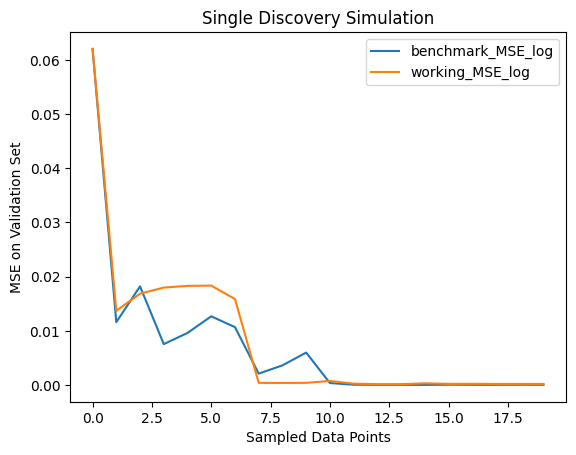

In [ ]:
# lets plot the benchmark_MSE_log and the workign_MSE_log
plt.plot(benchmark_MSE_log, label='benchmark_MSE_log')
plt.plot(working_MSE_log, label='working_MSE_log')
plt.xlabel('Sampled Data Points')
plt.ylabel('MSE on Validation Set')
plt.title('Single Discovery Simulation')
plt.legend()

# we can also investigate the final state more closely
# for example, these are all the experimental data collected
# under random sampling:
print(benchmark_state.experiment_data)
# and for your custom experimentalist
print(working_state.experiment_data)

### Averaging Across Multiple Runs

To become more confident in your experimentalist, you may want to repeat the discovery process N times...

In [27]:
benchmark_MSE_plot_data = np.zeros([num_discovery_simulations, num_cycles])
working_MSE_plot_data = np.zeros([num_discovery_simulations, num_cycles])

for sim in range(num_discovery_simulations):
  benchmark_MSE_log, working_MSE_log, benchmark_state, working_state = run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner, sim)

  benchmark_MSE_plot_data[sim, :] = benchmark_MSE_log
  working_MSE_plot_data[sim, :] = working_MSE_log

INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 0 / DISCOVERY CYCLE 0
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0      0.91633


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0      0.91633


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 16.28it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 1
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.318182   46.0     0.828469


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 13.14it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.343434   16.0     0.593728


100%|██████████| 1/1 [00:00<00:00, 11.36it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 0 / DISCOVERY CYCLE 2
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.318182   46.0     0.828469
2      0.085859   61.0     0.853359


100%|██████████| 1/1 [00:00<00:00, 12.64it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.343434   16.0     0.593728
2      0.141414   25.0     0.594433


100%|██████████| 1/1 [00:00<00:00, 11.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 3
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.318182   46.0     0.828469
2      0.085859   61.0     0.853359
3      0.257576   10.0     0.449999


100%|██████████| 1/1 [00:00<00:00, 12.58it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.343434   16.0     0.593728
2      0.141414   25.0     0.594433
3      0.378788   48.0     0.852818


100%|██████████| 1/1 [00:00<00:00, 12.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 4
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.318182   46.0     0.828469
2      0.085859   61.0     0.853359
3      0.257576   10.0     0.449999
4      0.444444   16.0     0.656231


100%|██████████| 1/1 [00:00<00:00, 12.14it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.343434   16.0     0.593728
2      0.141414   25.0     0.594433
3      0.378788   48.0     0.852818
4      0.257576   67.0     0.900524


100%|██████████| 1/1 [00:00<00:00, 11.31it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 5
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.318182   46.0     0.828469
2      0.085859   61.0     0.853359
3      0.257576   10.0     0.449999
4      0.444444   16.0     0.656231
5      0.151515   72.0     0.902148


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.343434   16.0     0.593728
2      0.141414   25.0     0.594433
3      0.378788   48.0     0.852818
4      0.257576   67.0     0.900524
5      0.409091   29.0     0.752438


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 6
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.318182   46.0     0.828469
2      0.085859   61.0     0.853359
3      0.257576   10.0     0.449999
4      0.444444   16.0     0.656231
5      0.151515   72.0     0.902148
6      0.090909    7.0     0.263105


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.343434   16.0     0.593728
2      0.141414   25.0     0.594433
3      0.378788   48.0     0.852818
4      0.257576   67.0     0.900524
5      0.409091   29.0     0.752438
6      0.363636    1.0     0.382444


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 7
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.318182   46.0     0.828469
2      0.085859   61.0     0.853359
3      0.257576   10.0     0.449999
4      0.444444   16.0     0.656231
5      0.151515   72.0     0.902148
6      0.090909    7.0     0.263105
7      0.045455   65.0     0.864193


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  6.59it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.343434   16.0     0.593728
2      0.141414   25.0     0.594433
3      0.378788   48.0     0.852818
4      0.257576   67.0     0.900524
5      0.409091   29.0     0.752438
6      0.363636    1.0     0.382444
7      0.479798   80.0     0.952808


100%|██████████| 1/1 [00:00<00:00, 12.52it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 8
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.318182   46.0     0.828469
2      0.085859   61.0     0.853359
3      0.257576   10.0     0.449999
4      0.444444   16.0     0.656231
5      0.151515   72.0     0.902148
6      0.090909    7.0     0.263105
7      0.045455   65.0     0.864193
8      0.287879   49.0     0.836265


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.343434   16.0     0.593728
2      0.141414   25.0     0.594433
3      0.378788   48.0     0.852818
4      0.257576   67.0     0.900524
5      0.409091   29.0     0.752438
6      0.363636    1.0     0.382444
7      0.479798   80.0     0.952808
8      0.464646  100.0     0.973346


100%|██████████| 1/1 [00:00<00:00,  6.11it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 9
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.318182   46.0     0.828469
2      0.085859   61.0     0.853359
3      0.257576   10.0     0.449999
4      0.444444   16.0     0.656231
5      0.151515   72.0     0.902148
6      0.090909    7.0     0.263105
7      0.045455   65.0     0.864193
8      0.287879   49.0     0.836265
9      0.449495   18.0     0.679194


100%|██████████| 1/1 [00:00<00:00, 13.21it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.429293   64.0     0.916330
1      0.343434   16.0     0.593728
2      0.141414   25.0     0.594433
3      0.378788   48.0     0.852818
4      0.257576   67.0     0.900524
5      0.409091   29.0     0.752438
6      0.363636    1.0     0.382444
7      0.479798   80.0     0.952808
8      0.464646  100.0     0.973346
9      0.500000   95.0     0.971078


100%|██████████| 1/1 [00:00<00:00, 10.95it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 10
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.318182   46.0     0.828469
2       0.085859   61.0     0.853359
3       0.257576   10.0     0.449999
4       0.444444   16.0     0.656231
5       0.151515   72.0     0.902148
6       0.090909    7.0     0.263105
7       0.045455   65.0     0.864193
8       0.287879   49.0     0.836265
9       0.449495   18.0     0.679194
10      0.292929   52.0     0.851419


100%|██████████| 1/1 [00:00<00:00, 13.75it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.343434   16.0     0.593728
2       0.141414   25.0     0.594433
3       0.378788   48.0     0.852818
4       0.257576   67.0     0.900524
5       0.409091   29.0     0.752438
6       0.363636    1.0     0.382444
7       0.479798   80.0     0.952808
8       0.464646  100.0     0.973346
9       0.500000   95.0     0.971078
10      0.030303    1.0     0.058962


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 11
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.318182   46.0     0.828469
2       0.085859   61.0     0.853359
3       0.257576   10.0     0.449999
4       0.444444   16.0     0.656231
5       0.151515   72.0     0.902148
6       0.090909    7.0     0.263105
7       0.045455   65.0     0.864193
8       0.287879   49.0     0.836265
9       0.449495   18.0     0.679194
10      0.292929   52.0     0.851419
11      0.328283   12.0     0.531359


100%|██████████| 1/1 [00:00<00:00,  9.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.343434   16.0     0.593728
2       0.141414   25.0     0.594433
3       0.378788   48.0     0.852818
4       0.257576   67.0     0.900524
5       0.409091   29.0     0.752438
6       0.363636    1.0     0.382444
7       0.479798   80.0     0.952808
8       0.464646  100.0     0.973346
9       0.500000   95.0     0.971078
10      0.030303    1.0     0.058962
11      0.010101  100.0     0.950716


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 12
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.318182   46.0     0.828469
2       0.085859   61.0     0.853359
3       0.257576   10.0     0.449999
4       0.444444   16.0     0.656231
5       0.151515   72.0     0.902148
6       0.090909    7.0     0.263105
7       0.045455   65.0     0.864193
8       0.287879   49.0     0.836265
9       0.449495   18.0     0.679194
10      0.292929   52.0     0.851419
11      0.328283   12.0     0.531359
12      0.333333   31.0     0.736964


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.343434   16.0     0.593728
2       0.141414   25.0     0.594433
3       0.378788   48.0     0.852818
4       0.257576   67.0     0.900524
5       0.409091   29.0     0.752438
6       0.363636    1.0     0.382444
7       0.479798   80.0     0.952808
8       0.464646  100.0     0.973346
9       0.500000   95.0     0.971078
10      0.030303    1.0     0.058962
11      0.010101  100.0     0.950716
12      0.005051   99.0     0.948956


100%|██████████| 1/1 [00:00<00:00, 10.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 13
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.318182   46.0     0.828469
2       0.085859   61.0     0.853359
3       0.257576   10.0     0.449999
4       0.444444   16.0     0.656231
5       0.151515   72.0     0.902148
6       0.090909    7.0     0.263105
7       0.045455   65.0     0.864193
8       0.287879   49.0     0.836265
9       0.449495   18.0     0.679194
10      0.292929   52.0     0.851419
11      0.328283   12.0     0.531359
12      0.333333   31.0     0.736964
13      0.479798   82.0     0.955557


100%|██████████| 1/1 [00:00<00:00, 11.67it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.343434   16.0     0.593728
2       0.141414   25.0     0.594433
3       0.378788   48.0     0.852818
4       0.257576   67.0     0.900524
5       0.409091   29.0     0.752438
6       0.363636    1.0     0.382444
7       0.479798   80.0     0.952808
8       0.464646  100.0     0.973346
9       0.500000   95.0     0.971078
10      0.030303    1.0     0.058962
11      0.010101  100.0     0.950716
12      0.005051   99.0     0.948956
13      0.005051    1.0     0.034456


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 14
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.318182   46.0     0.828469
2       0.085859   61.0     0.853359
3       0.257576   10.0     0.449999
4       0.444444   16.0     0.656231
5       0.151515   72.0     0.902148
6       0.090909    7.0     0.263105
7       0.045455   65.0     0.864193
8       0.287879   49.0     0.836265
9       0.449495   18.0     0.679194
10      0.292929   52.0     0.851419
11      0.328283   12.0     0.531359
12      0.333333   31.0     0.736964
13      0.479798   82.0     0.955557
14      0.424242    7.0     0.533300


100%|██████████| 1/1 [00:00<00:00, 10.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.343434   16.0     0.593728
2       0.141414   25.0     0.594433
3       0.378788   48.0     0.852818
4       0.257576   67.0     0.900524
5       0.409091   29.0     0.752438
6       0.363636    1.0     0.382444
7       0.479798   80.0     0.952808
8       0.464646  100.0     0.973346
9       0.500000   95.0     0.971078
10      0.030303    1.0     0.058962
11      0.010101  100.0     0.950716
12      0.005051   99.0     0.948956
13      0.005051    1.0     0.034456
14      0.010101    2.0     0.067748


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 15
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.318182   46.0     0.828469
2       0.085859   61.0     0.853359
3       0.257576   10.0     0.449999
4       0.444444   16.0     0.656231
5       0.151515   72.0     0.902148
6       0.090909    7.0     0.263105
7       0.045455   65.0     0.864193
8       0.287879   49.0     0.836265
9       0.449495   18.0     0.679194
10      0.292929   52.0     0.851419
11      0.328283   12.0     0.531359
12      0.333333   31.0     0.736964
13      0.479798   82.0     0.955557
14      0.424242    7.0     0.533300
15      0.116162   24.0     0.569790


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.343434   16.0     0.593728
2       0.141414   25.0     0.594433
3       0.378788   48.0     0.852818
4       0.257576   67.0     0.900524
5       0.409091   29.0     0.752438
6       0.363636    1.0     0.382444
7       0.479798   80.0     0.952808
8       0.464646  100.0     0.973346
9       0.500000   95.0     0.971078
10      0.030303    1.0     0.058962
11      0.010101  100.0     0.950716
12      0.005051   99.0     0.948956
13      0.005051    1.0     0.034456
14      0.010101    2.0     0.067748
15      0.000000   98.0     0.947134


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 16
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.318182   46.0     0.828469
2       0.085859   61.0     0.853359
3       0.257576   10.0     0.449999
4       0.444444   16.0     0.656231
5       0.151515   72.0     0.902148
6       0.090909    7.0     0.263105
7       0.045455   65.0     0.864193
8       0.287879   49.0     0.836265
9       0.449495   18.0     0.679194
10      0.292929   52.0     0.851419
11      0.328283   12.0     0.531359
12      0.333333   31.0     0.736964
13      0.479798   82.0     0.955557
14      0.424242    7.0     0.533300
15      0.116162   24.0     0.569790
16      0.196970   64.0     0.882270


100%|██████████| 1/1 [00:00<00:00, 13.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.343434   16.0     0.593728
2       0.141414   25.0     0.594433
3       0.378788   48.0     0.852818
4       0.257576   67.0     0.900524
5       0.409091   29.0     0.752438
6       0.363636    1.0     0.382444
7       0.479798   80.0     0.952808
8       0.464646  100.0     0.973346
9       0.500000   95.0     0.971078
10      0.030303    1.0     0.058962
11      0.010101  100.0     0.950716
12      0.005051   99.0     0.948956
13      0.005051    1.0     0.034456
14      0.010101    2.0     0.067748
15      0.000000   98.0     0.947134
16      0.489899  100.0     0.974604


100%|██████████| 1/1 [00:00<00:00, 10.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 17
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.318182   46.0     0.828469
2       0.085859   61.0     0.853359
3       0.257576   10.0     0.449999
4       0.444444   16.0     0.656231
5       0.151515   72.0     0.902148
6       0.090909    7.0     0.263105
7       0.045455   65.0     0.864193
8       0.287879   49.0     0.836265
9       0.449495   18.0     0.679194
10      0.292929   52.0     0.851419
11      0.328283   12.0     0.531359
12      0.333333   31.0     0.736964
13      0.479798   82.0     0.955557
14      0.424242    7.0     0.533300
15      0.116162   24.0     0.569790
16      0.196970   64.0     0.882270
17      0.454545    5.0     0.530523


100%|██████████| 1/1 [00:00<00:00, 10.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.343434   16.0     0.593728
2       0.141414   25.0     0.594433
3       0.378788   48.0     0.852818
4       0.257576   67.0     0.900524
5       0.409091   29.0     0.752438
6       0.363636    1.0     0.382444
7       0.479798   80.0     0.952808
8       0.464646  100.0     0.973346
9       0.500000   95.0     0.971078
10      0.030303    1.0     0.058962
11      0.010101  100.0     0.950716
12      0.005051   99.0     0.948956
13      0.005051    1.0     0.034456
14      0.010101    2.0     0.067748
15      0.000000   98.0     0.947134
16      0.489899  100.0     0.974604
17      0.010101    2.0     0.067748


100%|██████████| 1/1 [00:00<00:00, 10.96it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 18
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.318182   46.0     0.828469
2       0.085859   61.0     0.853359
3       0.257576   10.0     0.449999
4       0.444444   16.0     0.656231
5       0.151515   72.0     0.902148
6       0.090909    7.0     0.263105
7       0.045455   65.0     0.864193
8       0.287879   49.0     0.836265
9       0.449495   18.0     0.679194
10      0.292929   52.0     0.851419
11      0.328283   12.0     0.531359
12      0.333333   31.0     0.736964
13      0.479798   82.0     0.955557
14      0.424242    7.0     0.533300
15      0.116162   24.0     0.569790
16      0.196970   64.0     0.882270
17      0.454545    5.0     0.530523
18      0.141414   48.0     0.796577


100%|██████████| 1/1 [00:00<00:00, 11.97it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.343434   16.0     0.593728
2       0.141414   25.0     0.594433
3       0.378788   48.0     0.852818
4       0.257576   67.0     0.900524
5       0.409091   29.0     0.752438
6       0.363636    1.0     0.382444
7       0.479798   80.0     0.952808
8       0.464646  100.0     0.973346
9       0.500000   95.0     0.971078
10      0.030303    1.0     0.058962
11      0.010101  100.0     0.950716
12      0.005051   99.0     0.948956
13      0.005051    1.0     0.034456
14      0.010101    2.0     0.067748
15      0.000000   98.0     0.947134
16      0.489899  100.0     0.974604
17      0.010101    2.0     0.067748
18      0.000000   99.0     0.948697


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 0 / DISCOVERY CYCLE 19
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.318182   46.0     0.828469
2       0.085859   61.0     0.853359
3       0.257576   10.0     0.449999
4       0.444444   16.0     0.656231
5       0.151515   72.0     0.902148
6       0.090909    7.0     0.263105
7       0.045455   65.0     0.864193
8       0.287879   49.0     0.836265
9       0.449495   18.0     0.679194
10      0.292929   52.0     0.851419
11      0.328283   12.0     0.531359
12      0.333333   31.0     0.736964
13      0.479798   82.0     0.955557
14      0.424242    7.0     0.533300
15      0.116162   24.0     0.569790
16      0.196970   64.0     0.882270
17      0.454545    5.0     0.530523
18      0.141414   48.0     0.796577
19      0.005051   67.0     0.866688


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.429293   64.0     0.916330
1       0.343434   16.0     0.593728
2       0.141414   25.0     0.594433
3       0.378788   48.0     0.852818
4       0.257576   67.0     0.900524
5       0.409091   29.0     0.752438
6       0.363636    1.0     0.382444
7       0.479798   80.0     0.952808
8       0.464646  100.0     0.973346
9       0.500000   95.0     0.971078
10      0.030303    1.0     0.058962
11      0.010101  100.0     0.950716
12      0.005051   99.0     0.948956
13      0.005051    1.0     0.034456
14      0.010101    2.0     0.067748
15      0.000000   98.0     0.947134
16      0.489899  100.0     0.974604
17      0.010101    2.0     0.067748
18      0.000000   99.0     0.948697
19      0.005051   99.0     0.948956


100%|██████████| 1/1 [00:00<00:00, 10.94it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 0
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745


100%|██████████| 1/1 [00:00<00:00, 11.81it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745


100%|██████████| 1/1 [00:00<00:00,  7.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 1
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.222222   18.0     0.546751


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.494949   88.0     0.963959


100%|██████████| 1/1 [00:00<00:00,  9.59it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 2
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.222222   18.0     0.546751
2      0.121212   58.0     0.845755


100%|██████████| 1/1 [00:00<00:00,  9.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.494949   88.0     0.963959
2      0.328283   62.0     0.895432


100%|██████████| 1/1 [00:00<00:00, 14.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 3
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.222222   18.0     0.546751
2      0.121212   58.0     0.845755
3      0.111111   97.0     0.951577


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 10.12it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.494949   88.0     0.963959
2      0.328283   62.0     0.895432
3      0.348485   76.0     0.933360


100%|██████████| 1/1 [00:00<00:00, 12.37it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 4
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.222222   18.0     0.546751
2      0.121212   58.0     0.845755
3      0.111111   97.0     0.951577
4      0.449495   67.0     0.926239


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  7.43it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.494949   88.0     0.963959
2      0.328283   62.0     0.895432
3      0.348485   76.0     0.933360
4      0.338384   90.0     0.955536


100%|██████████| 1/1 [00:00<00:00, 12.07it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 5
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.222222   18.0     0.546751
2      0.121212   58.0     0.845755
3      0.111111   97.0     0.951577
4      0.449495   67.0     0.926239
5      0.277778   27.0     0.678714


100%|██████████| 1/1 [00:00<00:00, 12.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.494949   88.0     0.963959
2      0.328283   62.0     0.895432
3      0.348485   76.0     0.933360
4      0.338384   90.0     0.955536
5      0.247475   33.0     0.720379


100%|██████████| 1/1 [00:00<00:00,  8.55it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 6
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.222222   18.0     0.546751
2      0.121212   58.0     0.845755
3      0.111111   97.0     0.951577
4      0.449495   67.0     0.926239
5      0.277778   27.0     0.678714
6      0.186869   45.0     0.789204


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 10.73it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.494949   88.0     0.963959
2      0.328283   62.0     0.895432
3      0.348485   76.0     0.933360
4      0.338384   90.0     0.955536
5      0.247475   33.0     0.720379
6      0.409091   11.0     0.575181


100%|██████████| 1/1 [00:00<00:00, 11.08it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 7
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.222222   18.0     0.546751
2      0.121212   58.0     0.845755
3      0.111111   97.0     0.951577
4      0.449495   67.0     0.926239
5      0.277778   27.0     0.678714
6      0.186869   45.0     0.789204
7      0.469697   42.0     0.849577


100%|██████████| 1/1 [00:00<00:00, 11.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.494949   88.0     0.963959
2      0.328283   62.0     0.895432
3      0.348485   76.0     0.933360
4      0.338384   90.0     0.955536
5      0.247475   33.0     0.720379
6      0.409091   11.0     0.575181
7      0.358586   19.0     0.637264


100%|██████████| 1/1 [00:00<00:00, 14.45it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 8
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.222222   18.0     0.546751
2      0.121212   58.0     0.845755
3      0.111111   97.0     0.951577
4      0.449495   67.0     0.926239
5      0.277778   27.0     0.678714
6      0.186869   45.0     0.789204
7      0.469697   42.0     0.849577
8      0.348485   65.0     0.907306


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  9.10it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.494949   88.0     0.963959
2      0.328283   62.0     0.895432
3      0.348485   76.0     0.933360
4      0.338384   90.0     0.955536
5      0.247475   33.0     0.720379
6      0.409091   11.0     0.575181
7      0.358586   19.0     0.637264
8      0.000000   99.0     0.948697


100%|██████████| 1/1 [00:00<00:00, 12.00it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 9
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.222222   18.0     0.546751
2      0.121212   58.0     0.845755
3      0.111111   97.0     0.951577
4      0.449495   67.0     0.926239
5      0.277778   27.0     0.678714
6      0.186869   45.0     0.789204
7      0.469697   42.0     0.849577
8      0.348485   65.0     0.907306
9      0.212121   87.0     0.942064


100%|██████████| 1/1 [00:00<00:00, 12.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.237374   52.0     0.839745
1      0.494949   88.0     0.963959
2      0.328283   62.0     0.895432
3      0.348485   76.0     0.933360
4      0.338384   90.0     0.955536
5      0.247475   33.0     0.720379
6      0.409091   11.0     0.575181
7      0.358586   19.0     0.637264
8      0.000000   99.0     0.948697
9      0.035354    1.0     0.063863


100%|██████████| 1/1 [00:00<00:00, 11.39it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 10
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.222222   18.0     0.546751
2       0.121212   58.0     0.845755
3       0.111111   97.0     0.951577
4       0.449495   67.0     0.926239
5       0.277778   27.0     0.678714
6       0.186869   45.0     0.789204
7       0.469697   42.0     0.849577
8       0.348485   65.0     0.907306
9       0.212121   87.0     0.942064
10      0.257576   55.0     0.857417


100%|██████████| 1/1 [00:00<00:00, 11.46it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.494949   88.0     0.963959
2       0.328283   62.0     0.895432
3       0.348485   76.0     0.933360
4       0.338384   90.0     0.955536
5       0.247475   33.0     0.720379
6       0.409091   11.0     0.575181
7       0.358586   19.0     0.637264
8       0.000000   99.0     0.948697
9       0.035354    1.0     0.063863
10      0.010101   99.0     0.949215


100%|██████████| 1/1 [00:00<00:00, 11.58it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 11
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.222222   18.0     0.546751
2       0.121212   58.0     0.845755
3       0.111111   97.0     0.951577
4       0.449495   67.0     0.926239
5       0.277778   27.0     0.678714
6       0.186869   45.0     0.789204
7       0.469697   42.0     0.849577
8       0.348485   65.0     0.907306
9       0.212121   87.0     0.942064
10      0.257576   55.0     0.857417
11      0.318182   48.0     0.838458


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.494949   88.0     0.963959
2       0.328283   62.0     0.895432
3       0.348485   76.0     0.933360
4       0.338384   90.0     0.955536
5       0.247475   33.0     0.720379
6       0.409091   11.0     0.575181
7       0.358586   19.0     0.637264
8       0.000000   99.0     0.948697
9       0.035354    1.0     0.063863
10      0.010101   99.0     0.949215
11      0.000000    1.0     0.029554


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 12
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.222222   18.0     0.546751
2       0.121212   58.0     0.845755
3       0.111111   97.0     0.951577
4       0.449495   67.0     0.926239
5       0.277778   27.0     0.678714
6       0.186869   45.0     0.789204
7       0.469697   42.0     0.849577
8       0.348485   65.0     0.907306
9       0.212121   87.0     0.942064
10      0.257576   55.0     0.857417
11      0.318182   48.0     0.838458
12      0.070707   41.0     0.728375


100%|██████████| 1/1 [00:00<00:00,  9.67it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.494949   88.0     0.963959
2       0.328283   62.0     0.895432
3       0.348485   76.0     0.933360
4       0.338384   90.0     0.955536
5       0.247475   33.0     0.720379
6       0.409091   11.0     0.575181
7       0.358586   19.0     0.637264
8       0.000000   99.0     0.948697
9       0.035354    1.0     0.063863
10      0.010101   99.0     0.949215
11      0.000000    1.0     0.029554
12      0.010101    1.0     0.039357


100%|██████████| 1/1 [00:00<00:00, 13.14it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 13
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.222222   18.0     0.546751
2       0.121212   58.0     0.845755
3       0.111111   97.0     0.951577
4       0.449495   67.0     0.926239
5       0.277778   27.0     0.678714
6       0.186869   45.0     0.789204
7       0.469697   42.0     0.849577
8       0.348485   65.0     0.907306
9       0.212121   87.0     0.942064
10      0.257576   55.0     0.857417
11      0.318182   48.0     0.838458
12      0.070707   41.0     0.728375
13      0.484848   32.0     0.802752


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 11.61it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.494949   88.0     0.963959
2       0.328283   62.0     0.895432
3       0.348485   76.0     0.933360
4       0.338384   90.0     0.955536
5       0.247475   33.0     0.720379
6       0.409091   11.0     0.575181
7       0.358586   19.0     0.637264
8       0.000000   99.0     0.948697
9       0.035354    1.0     0.063863
10      0.010101   99.0     0.949215
11      0.000000    1.0     0.029554
12      0.010101    1.0     0.039357
13      0.005051  100.0     0.950464


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 14
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.222222   18.0     0.546751
2       0.121212   58.0     0.845755
3       0.111111   97.0     0.951577
4       0.449495   67.0     0.926239
5       0.277778   27.0     0.678714
6       0.186869   45.0     0.789204
7       0.469697   42.0     0.849577
8       0.348485   65.0     0.907306
9       0.212121   87.0     0.942064
10      0.257576   55.0     0.857417
11      0.318182   48.0     0.838458
12      0.070707   41.0     0.728375
13      0.484848   32.0     0.802752
14      0.010101   85.0     0.922707


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.494949   88.0     0.963959
2       0.328283   62.0     0.895432
3       0.348485   76.0     0.933360
4       0.338384   90.0     0.955536
5       0.247475   33.0     0.720379
6       0.409091   11.0     0.575181
7       0.358586   19.0     0.637264
8       0.000000   99.0     0.948697
9       0.035354    1.0     0.063863
10      0.010101   99.0     0.949215
11      0.000000    1.0     0.029554
12      0.010101    1.0     0.039357
13      0.005051  100.0     0.950464
14      0.000000   99.0     0.948697


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 15
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.222222   18.0     0.546751
2       0.121212   58.0     0.845755
3       0.111111   97.0     0.951577
4       0.449495   67.0     0.926239
5       0.277778   27.0     0.678714
6       0.186869   45.0     0.789204
7       0.469697   42.0     0.849577
8       0.348485   65.0     0.907306
9       0.212121   87.0     0.942064
10      0.257576   55.0     0.857417
11      0.318182   48.0     0.838458
12      0.070707   41.0     0.728375
13      0.484848   32.0     0.802752
14      0.010101   85.0     0.922707
15      0.434343    6.0     0.527524


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.494949   88.0     0.963959
2       0.328283   62.0     0.895432
3       0.348485   76.0     0.933360
4       0.338384   90.0     0.955536
5       0.247475   33.0     0.720379
6       0.409091   11.0     0.575181
7       0.358586   19.0     0.637264
8       0.000000   99.0     0.948697
9       0.035354    1.0     0.063863
10      0.010101   99.0     0.949215
11      0.000000    1.0     0.029554
12      0.010101    1.0     0.039357
13      0.005051  100.0     0.950464
14      0.000000   99.0     0.948697
15      0.494949   99.0     0.974089


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 16
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.222222   18.0     0.546751
2       0.121212   58.0     0.845755
3       0.111111   97.0     0.951577
4       0.449495   67.0     0.926239
5       0.277778   27.0     0.678714
6       0.186869   45.0     0.789204
7       0.469697   42.0     0.849577
8       0.348485   65.0     0.907306
9       0.212121   87.0     0.942064
10      0.257576   55.0     0.857417
11      0.318182   48.0     0.838458
12      0.070707   41.0     0.728375
13      0.484848   32.0     0.802752
14      0.010101   85.0     0.922707
15      0.434343    6.0     0.527524
16      0.383838    7.0     0.500549


100%|██████████| 1/1 [00:00<00:00, 12.82it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.494949   88.0     0.963959
2       0.328283   62.0     0.895432
3       0.348485   76.0     0.933360
4       0.338384   90.0     0.955536
5       0.247475   33.0     0.720379
6       0.409091   11.0     0.575181
7       0.358586   19.0     0.637264
8       0.000000   99.0     0.948697
9       0.035354    1.0     0.063863
10      0.010101   99.0     0.949215
11      0.000000    1.0     0.029554
12      0.010101    1.0     0.039357
13      0.005051  100.0     0.950464
14      0.000000   99.0     0.948697
15      0.494949   99.0     0.974089
16      0.015152  100.0     0.950967


100%|██████████| 1/1 [00:00<00:00, 10.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 17
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.222222   18.0     0.546751
2       0.121212   58.0     0.845755
3       0.111111   97.0     0.951577
4       0.449495   67.0     0.926239
5       0.277778   27.0     0.678714
6       0.186869   45.0     0.789204
7       0.469697   42.0     0.849577
8       0.348485   65.0     0.907306
9       0.212121   87.0     0.942064
10      0.257576   55.0     0.857417
11      0.318182   48.0     0.838458
12      0.070707   41.0     0.728375
13      0.484848   32.0     0.802752
14      0.010101   85.0     0.922707
15      0.434343    6.0     0.527524
16      0.383838    7.0     0.500549
17      0.343434   29.0     0.724931


100%|██████████| 1/1 [00:00<00:00, 14.36it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.494949   88.0     0.963959
2       0.328283   62.0     0.895432
3       0.348485   76.0     0.933360
4       0.338384   90.0     0.955536
5       0.247475   33.0     0.720379
6       0.409091   11.0     0.575181
7       0.358586   19.0     0.637264
8       0.000000   99.0     0.948697
9       0.035354    1.0     0.063863
10      0.010101   99.0     0.949215
11      0.000000    1.0     0.029554
12      0.010101    1.0     0.039357
13      0.005051  100.0     0.950464
14      0.000000   99.0     0.948697
15      0.494949   99.0     0.974089
16      0.015152  100.0     0.950967
17      0.025253  100.0     0.951470


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 18
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.222222   18.0     0.546751
2       0.121212   58.0     0.845755
3       0.111111   97.0     0.951577
4       0.449495   67.0     0.926239
5       0.277778   27.0     0.678714
6       0.186869   45.0     0.789204
7       0.469697   42.0     0.849577
8       0.348485   65.0     0.907306
9       0.212121   87.0     0.942064
10      0.257576   55.0     0.857417
11      0.318182   48.0     0.838458
12      0.070707   41.0     0.728375
13      0.484848   32.0     0.802752
14      0.010101   85.0     0.922707
15      0.434343    6.0     0.527524
16      0.383838    7.0     0.500549
17      0.343434   29.0     0.724931
18      0.222222   15.0     0.504067


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.494949   88.0     0.963959
2       0.328283   62.0     0.895432
3       0.348485   76.0     0.933360
4       0.338384   90.0     0.955536
5       0.247475   33.0     0.720379
6       0.409091   11.0     0.575181
7       0.358586   19.0     0.637264
8       0.000000   99.0     0.948697
9       0.035354    1.0     0.063863
10      0.010101   99.0     0.949215
11      0.000000    1.0     0.029554
12      0.010101    1.0     0.039357
13      0.005051  100.0     0.950464
14      0.000000   99.0     0.948697
15      0.494949   99.0     0.974089
16      0.015152  100.0     0.950967
17      0.025253  100.0     0.951470
18      0.000000    1.0     0.029554


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 1 / DISCOVERY CYCLE 19
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.222222   18.0     0.546751
2       0.121212   58.0     0.845755
3       0.111111   97.0     0.951577
4       0.449495   67.0     0.926239
5       0.277778   27.0     0.678714
6       0.186869   45.0     0.789204
7       0.469697   42.0     0.849577
8       0.348485   65.0     0.907306
9       0.212121   87.0     0.942064
10      0.257576   55.0     0.857417
11      0.318182   48.0     0.838458
12      0.070707   41.0     0.728375
13      0.484848   32.0     0.802752
14      0.010101   85.0     0.922707
15      0.434343    6.0     0.527524
16      0.383838    7.0     0.500549
17      0.343434   29.0     0.724931
18      0.222222   15.0     0.504067
19      0.202020    3.0     0.270701


100%|██████████| 1/1 [00:00<00:00, 10.44it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.237374   52.0     0.839745
1       0.494949   88.0     0.963959
2       0.328283   62.0     0.895432
3       0.348485   76.0     0.933360
4       0.338384   90.0     0.955536
5       0.247475   33.0     0.720379
6       0.409091   11.0     0.575181
7       0.358586   19.0     0.637264
8       0.000000   99.0     0.948697
9       0.035354    1.0     0.063863
10      0.010101   99.0     0.949215
11      0.000000    1.0     0.029554
12      0.010101    1.0     0.039357
13      0.005051  100.0     0.950464
14      0.000000   99.0     0.948697
15      0.494949   99.0     0.974089
16      0.015152  100.0     0.950967
17      0.025253  100.0     0.951470
18      0.000000    1.0     0.029554
19      0.020202    1.0     0.049159


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 0
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623


100%|██████████| 1/1 [00:00<00:00,  9.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623


100%|██████████| 1/1 [00:00<00:00, 16.57it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 1
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.095960   35.0     0.683642


100%|██████████| 1/1 [00:00<00:00, 12.19it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.151515    7.0     0.312232


100%|██████████| 1/1 [00:00<00:00, 11.46it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 2
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.095960   35.0     0.683642
2      0.237374   78.0     0.926538


100%|██████████| 1/1 [00:00<00:00, 10.83it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.151515    7.0     0.312232
2      0.161616   95.0     0.951504


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 3
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.095960   35.0     0.683642
2      0.237374   78.0     0.926538
3      0.232323   97.0     0.958180


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.151515    7.0     0.312232
2      0.161616   95.0     0.951504
3      0.328283   29.0     0.718583


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 4
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.095960   35.0     0.683642
2      0.237374   78.0     0.926538
3      0.232323   97.0     0.958180
4      0.262626   69.0     0.906954


100%|██████████| 1/1 [00:00<00:00, 11.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.151515    7.0     0.312232
2      0.161616   95.0     0.951504
3      0.328283   29.0     0.718583
4      0.414141   11.0     0.578812


100%|██████████| 1/1 [00:00<00:00, 15.10it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 5
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.095960   35.0     0.683642
2      0.237374   78.0     0.926538
3      0.232323   97.0     0.958180
4      0.262626   69.0     0.906954
5      0.500000   54.0     0.901051


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 10.12it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.151515    7.0     0.312232
2      0.161616   95.0     0.951504
3      0.328283   29.0     0.718583
4      0.414141   11.0     0.578812
5      0.186869   42.0     0.769352


100%|██████████| 1/1 [00:00<00:00, 12.02it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 6
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.095960   35.0     0.683642
2      0.237374   78.0     0.926538
3      0.232323   97.0     0.958180
4      0.262626   69.0     0.906954
5      0.500000   54.0     0.901051
6      0.404040   80.0     0.945936


100%|██████████| 1/1 [00:00<00:00,  9.81it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.151515    7.0     0.312232
2      0.161616   95.0     0.951504
3      0.328283   29.0     0.718583
4      0.414141   11.0     0.578812
5      0.186869   42.0     0.769352
6      0.227273   85.0     0.939664


100%|██████████| 1/1 [00:00<00:00, 16.52it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 7
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.095960   35.0     0.683642
2      0.237374   78.0     0.926538
3      0.232323   97.0     0.958180
4      0.262626   69.0     0.906954
5      0.500000   54.0     0.901051
6      0.404040   80.0     0.945936
7      0.116162   65.0     0.874253


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 12.62it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.151515    7.0     0.312232
2      0.161616   95.0     0.951504
3      0.328283   29.0     0.718583
4      0.414141   11.0     0.578812
5      0.186869   42.0     0.769352
6      0.227273   85.0     0.939664
7      0.030303   58.0     0.829798


100%|██████████| 1/1 [00:00<00:00, 11.20it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...

INFO:autora.theorist.bms.regressor:BMS fitting started



Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 8
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.095960   35.0     0.683642
2      0.237374   78.0     0.926538
3      0.232323   97.0     0.958180
4      0.262626   69.0     0.906954
5      0.500000   54.0     0.901051
6      0.404040   80.0     0.945936
7      0.116162   65.0     0.874253
8      0.085859   54.0     0.819093


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.151515    7.0     0.312232
2      0.161616   95.0     0.951504
3      0.328283   29.0     0.718583
4      0.414141   11.0     0.578812
5      0.186869   42.0     0.769352
6      0.227273   85.0     0.939664
7      0.030303   58.0     0.829798
8      0.010101  100.0     0.950716


100%|██████████| 1/1 [00:00<00:00, 12.08it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 9
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.095960   35.0     0.683642
2      0.237374   78.0     0.926538
3      0.232323   97.0     0.958180
4      0.262626   69.0     0.906954
5      0.500000   54.0     0.901051
6      0.404040   80.0     0.945936
7      0.116162   65.0     0.874253
8      0.085859   54.0     0.819093
9      0.247475   77.0     0.925303


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.419192   27.0     0.741623
1      0.151515    7.0     0.312232
2      0.161616   95.0     0.951504
3      0.328283   29.0     0.718583
4      0.414141   11.0     0.578812
5      0.186869   42.0     0.769352
6      0.227273   85.0     0.939664
7      0.030303   58.0     0.829798
8      0.010101  100.0     0.950716
9      0.010101  100.0     0.950716


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 10
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.095960   35.0     0.683642
2       0.237374   78.0     0.926538
3       0.232323   97.0     0.958180
4       0.262626   69.0     0.906954
5       0.500000   54.0     0.901051
6       0.404040   80.0     0.945936
7       0.116162   65.0     0.874253
8       0.085859   54.0     0.819093
9       0.247475   77.0     0.925303
10      0.348485   78.0     0.937241


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.151515    7.0     0.312232
2       0.161616   95.0     0.951504
3       0.328283   29.0     0.718583
4       0.414141   11.0     0.578812
5       0.186869   42.0     0.769352
6       0.227273   85.0     0.939664
7       0.030303   58.0     0.829798
8       0.010101  100.0     0.950716
9       0.010101  100.0     0.950716
10      0.020202    1.0     0.049159


100%|██████████| 1/1 [00:00<00:00,  9.56it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 11
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.095960   35.0     0.683642
2       0.237374   78.0     0.926538
3       0.232323   97.0     0.958180
4       0.262626   69.0     0.906954
5       0.500000   54.0     0.901051
6       0.404040   80.0     0.945936
7       0.116162   65.0     0.874253
8       0.085859   54.0     0.819093
9       0.247475   77.0     0.925303
10      0.348485   78.0     0.937241
11      0.040404   12.0     0.330513


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.151515    7.0     0.312232
2       0.161616   95.0     0.951504
3       0.328283   29.0     0.718583
4       0.414141   11.0     0.578812
5       0.186869   42.0     0.769352
6       0.227273   85.0     0.939664
7       0.030303   58.0     0.829798
8       0.010101  100.0     0.950716
9       0.010101  100.0     0.950716
10      0.020202    1.0     0.049159
11      0.005051  100.0     0.950464


100%|██████████| 1/1 [00:00<00:00, 11.64it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 12
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.095960   35.0     0.683642
2       0.237374   78.0     0.926538
3       0.232323   97.0     0.958180
4       0.262626   69.0     0.906954
5       0.500000   54.0     0.901051
6       0.404040   80.0     0.945936
7       0.116162   65.0     0.874253
8       0.085859   54.0     0.819093
9       0.247475   77.0     0.925303
10      0.348485   78.0     0.937241
11      0.040404   12.0     0.330513
12      0.398990   99.0     0.969166


100%|██████████| 1/1 [00:00<00:00,  9.82it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.151515    7.0     0.312232
2       0.161616   95.0     0.951504
3       0.328283   29.0     0.718583
4       0.414141   11.0     0.578812
5       0.186869   42.0     0.769352
6       0.227273   85.0     0.939664
7       0.030303   58.0     0.829798
8       0.010101  100.0     0.950716
9       0.010101  100.0     0.950716
10      0.020202    1.0     0.049159
11      0.005051  100.0     0.950464
12      0.494949  100.0     0.974855


100%|██████████| 1/1 [00:00<00:00, 11.88it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 13
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.095960   35.0     0.683642
2       0.237374   78.0     0.926538
3       0.232323   97.0     0.958180
4       0.262626   69.0     0.906954
5       0.500000   54.0     0.901051
6       0.404040   80.0     0.945936
7       0.116162   65.0     0.874253
8       0.085859   54.0     0.819093
9       0.247475   77.0     0.925303
10      0.348485   78.0     0.937241
11      0.040404   12.0     0.330513
12      0.398990   99.0     0.969166
13      0.500000   88.0     0.964319


100%|██████████| 1/1 [00:00<00:00, 11.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.151515    7.0     0.312232
2       0.161616   95.0     0.951504
3       0.328283   29.0     0.718583
4       0.414141   11.0     0.578812
5       0.186869   42.0     0.769352
6       0.227273   85.0     0.939664
7       0.030303   58.0     0.829798
8       0.010101  100.0     0.950716
9       0.010101  100.0     0.950716
10      0.020202    1.0     0.049159
11      0.005051  100.0     0.950464
12      0.494949  100.0     0.974855
13      0.479798  100.0     0.974101


100%|██████████| 1/1 [00:00<00:00, 11.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 14
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.095960   35.0     0.683642
2       0.237374   78.0     0.926538
3       0.232323   97.0     0.958180
4       0.262626   69.0     0.906954
5       0.500000   54.0     0.901051
6       0.404040   80.0     0.945936
7       0.116162   65.0     0.874253
8       0.085859   54.0     0.819093
9       0.247475   77.0     0.925303
10      0.348485   78.0     0.937241
11      0.040404   12.0     0.330513
12      0.398990   99.0     0.969166
13      0.500000   88.0     0.964319
14      0.429293    9.0     0.564334


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  8.85it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.151515    7.0     0.312232
2       0.161616   95.0     0.951504
3       0.328283   29.0     0.718583
4       0.414141   11.0     0.578812
5       0.186869   42.0     0.769352
6       0.227273   85.0     0.939664
7       0.030303   58.0     0.829798
8       0.010101  100.0     0.950716
9       0.010101  100.0     0.950716
10      0.020202    1.0     0.049159
11      0.005051  100.0     0.950464
12      0.494949  100.0     0.974855
13      0.479798  100.0     0.974101
14      0.005051    2.0     0.062992


100%|██████████| 1/1 [00:00<00:00, 13.39it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 15
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.095960   35.0     0.683642
2       0.237374   78.0     0.926538
3       0.232323   97.0     0.958180
4       0.262626   69.0     0.906954
5       0.500000   54.0     0.901051
6       0.404040   80.0     0.945936
7       0.116162   65.0     0.874253
8       0.085859   54.0     0.819093
9       0.247475   77.0     0.925303
10      0.348485   78.0     0.937241
11      0.040404   12.0     0.330513
12      0.398990   99.0     0.969166
13      0.500000   88.0     0.964319
14      0.429293    9.0     0.564334
15      0.338384   93.0     0.959363


100%|██████████| 1/1 [00:00<00:00, 11.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.151515    7.0     0.312232
2       0.161616   95.0     0.951504
3       0.328283   29.0     0.718583
4       0.414141   11.0     0.578812
5       0.186869   42.0     0.769352
6       0.227273   85.0     0.939664
7       0.030303   58.0     0.829798
8       0.010101  100.0     0.950716
9       0.010101  100.0     0.950716
10      0.020202    1.0     0.049159
11      0.005051  100.0     0.950464
12      0.494949  100.0     0.974855
13      0.479798  100.0     0.974101
14      0.005051    2.0     0.062992
15      0.000000    2.0     0.058235


100%|██████████| 1/1 [00:00<00:00, 11.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 16
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.095960   35.0     0.683642
2       0.237374   78.0     0.926538
3       0.232323   97.0     0.958180
4       0.262626   69.0     0.906954
5       0.500000   54.0     0.901051
6       0.404040   80.0     0.945936
7       0.116162   65.0     0.874253
8       0.085859   54.0     0.819093
9       0.247475   77.0     0.925303
10      0.348485   78.0     0.937241
11      0.040404   12.0     0.330513
12      0.398990   99.0     0.969166
13      0.500000   88.0     0.964319
14      0.429293    9.0     0.564334
15      0.338384   93.0     0.959363
16      0.136364   88.0     0.938370


100%|██████████| 1/1 [00:00<00:00, 10.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.151515    7.0     0.312232
2       0.161616   95.0     0.951504
3       0.328283   29.0     0.718583
4       0.414141   11.0     0.578812
5       0.186869   42.0     0.769352
6       0.227273   85.0     0.939664
7       0.030303   58.0     0.829798
8       0.010101  100.0     0.950716
9       0.010101  100.0     0.950716
10      0.020202    1.0     0.049159
11      0.005051  100.0     0.950464
12      0.494949  100.0     0.974855
13      0.479798  100.0     0.974101
14      0.005051    2.0     0.062992
15      0.000000    2.0     0.058235
16      0.489899   99.0     0.973830


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 17
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.095960   35.0     0.683642
2       0.237374   78.0     0.926538
3       0.232323   97.0     0.958180
4       0.262626   69.0     0.906954
5       0.500000   54.0     0.901051
6       0.404040   80.0     0.945936
7       0.116162   65.0     0.874253
8       0.085859   54.0     0.819093
9       0.247475   77.0     0.925303
10      0.348485   78.0     0.937241
11      0.040404   12.0     0.330513
12      0.398990   99.0     0.969166
13      0.500000   88.0     0.964319
14      0.429293    9.0     0.564334
15      0.338384   93.0     0.959363
16      0.136364   88.0     0.938370
17      0.262626    3.0     0.326091


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.151515    7.0     0.312232
2       0.161616   95.0     0.951504
3       0.328283   29.0     0.718583
4       0.414141   11.0     0.578812
5       0.186869   42.0     0.769352
6       0.227273   85.0     0.939664
7       0.030303   58.0     0.829798
8       0.010101  100.0     0.950716
9       0.010101  100.0     0.950716
10      0.020202    1.0     0.049159
11      0.005051  100.0     0.950464
12      0.494949  100.0     0.974855
13      0.479798  100.0     0.974101
14      0.005051    2.0     0.062992
15      0.000000    2.0     0.058235
16      0.489899   99.0     0.973830
17      0.005051    1.0     0.034456


100%|██████████| 1/1 [00:00<00:00, 11.16it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...

INFO:autora.theorist.bms.regressor:BMS fitting started



Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 18
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.095960   35.0     0.683642
2       0.237374   78.0     0.926538
3       0.232323   97.0     0.958180
4       0.262626   69.0     0.906954
5       0.500000   54.0     0.901051
6       0.404040   80.0     0.945936
7       0.116162   65.0     0.874253
8       0.085859   54.0     0.819093
9       0.247475   77.0     0.925303
10      0.348485   78.0     0.937241
11      0.040404   12.0     0.330513
12      0.398990   99.0     0.969166
13      0.500000   88.0     0.964319
14      0.429293    9.0     0.564334
15      0.338384   93.0     0.959363
16      0.136364   88.0     0.938370
17      0.262626    3.0     0.326091
18      0.247475   98.0     0.960217


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.151515    7.0     0.312232
2       0.161616   95.0     0.951504
3       0.328283   29.0     0.718583
4       0.414141   11.0     0.578812
5       0.186869   42.0     0.769352
6       0.227273   85.0     0.939664
7       0.030303   58.0     0.829798
8       0.010101  100.0     0.950716
9       0.010101  100.0     0.950716
10      0.020202    1.0     0.049159
11      0.005051  100.0     0.950464
12      0.494949  100.0     0.974855
13      0.479798  100.0     0.974101
14      0.005051    2.0     0.062992
15      0.000000    2.0     0.058235
16      0.489899   99.0     0.973830
17      0.005051    1.0     0.034456
18      0.010101   99.0     0.949215


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 2 / DISCOVERY CYCLE 19
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.095960   35.0     0.683642
2       0.237374   78.0     0.926538
3       0.232323   97.0     0.958180
4       0.262626   69.0     0.906954
5       0.500000   54.0     0.901051
6       0.404040   80.0     0.945936
7       0.116162   65.0     0.874253
8       0.085859   54.0     0.819093
9       0.247475   77.0     0.925303
10      0.348485   78.0     0.937241
11      0.040404   12.0     0.330513
12      0.398990   99.0     0.969166
13      0.500000   88.0     0.964319
14      0.429293    9.0     0.564334
15      0.338384   93.0     0.959363
16      0.136364   88.0     0.938370
17      0.262626    3.0     0.326091
18      0.247475   98.0     0.960217
19      0.050505   77.0     0.905752


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.419192   27.0     0.741623
1       0.151515    7.0     0.312232
2       0.161616   95.0     0.951504
3       0.328283   29.0     0.718583
4       0.414141   11.0     0.578812
5       0.186869   42.0     0.769352
6       0.227273   85.0     0.939664
7       0.030303   58.0     0.829798
8       0.010101  100.0     0.950716
9       0.010101  100.0     0.950716
10      0.020202    1.0     0.049159
11      0.005051  100.0     0.950464
12      0.494949  100.0     0.974855
13      0.479798  100.0     0.974101
14      0.005051    2.0     0.062992
15      0.000000    2.0     0.058235
16      0.489899   99.0     0.973830
17      0.005051    1.0     0.034456
18      0.010101   99.0     0.949215
19      0.010101   99.0     0.949215


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 0
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912


100%|██████████| 1/1 [00:00<00:00, 13.51it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 1
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.444444   45.0     0.855978


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.297980   26.0     0.678190


100%|██████████| 1/1 [00:00<00:00, 15.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 2
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.444444   45.0     0.855978
2      0.358586   12.0     0.552501


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.297980   26.0     0.678190
2      0.424242   88.0     0.958913


100%|██████████| 1/1 [00:00<00:00, 14.32it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 3
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.444444   45.0     0.855978
2      0.358586   12.0     0.552501
3      0.070707   19.0     0.474461


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 10.49it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.297980   26.0     0.678190
2      0.424242   88.0     0.958913
3      0.419192   70.0     0.928876


100%|██████████| 1/1 [00:00<00:00, 11.94it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 4
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.444444   45.0     0.855978
2      0.358586   12.0     0.552501
3      0.070707   19.0     0.474461
4      0.388889   54.0     0.879062


100%|██████████| 1/1 [00:00<00:00, 15.51it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.297980   26.0     0.678190
2      0.424242   88.0     0.958913
3      0.419192   70.0     0.928876
4      0.267677   73.0     0.918041


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 12.45it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 5
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.444444   45.0     0.855978
2      0.358586   12.0     0.552501
3      0.070707   19.0     0.474461
4      0.388889   54.0     0.879062
5      0.090909   78.0     0.912429


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  8.26it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.297980   26.0     0.678190
2      0.424242   88.0     0.958913
3      0.419192   70.0     0.928876
4      0.267677   73.0     0.918041
5      0.282828   51.0     0.844707


100%|██████████| 1/1 [00:00<00:00, 13.56it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 6
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.444444   45.0     0.855978
2      0.358586   12.0     0.552501
3      0.070707   19.0     0.474461
4      0.388889   54.0     0.879062
5      0.090909   78.0     0.912429
6      0.368687   32.0     0.758275


100%|██████████| 1/1 [00:00<00:00,  6.20it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.297980   26.0     0.678190
2      0.424242   88.0     0.958913
3      0.419192   70.0     0.928876
4      0.267677   73.0     0.918041
5      0.282828   51.0     0.844707
6      0.161616   52.0     0.823825


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 7
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.444444   45.0     0.855978
2      0.358586   12.0     0.552501
3      0.070707   19.0     0.474461
4      0.388889   54.0     0.879062
5      0.090909   78.0     0.912429
6      0.368687   32.0     0.758275
7      0.207071   22.0     0.590173


100%|██████████| 1/1 [00:00<00:00,  9.87it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.297980   26.0     0.678190
2      0.424242   88.0     0.958913
3      0.419192   70.0     0.928876
4      0.267677   73.0     0.918041
5      0.282828   51.0     0.844707
6      0.161616   52.0     0.823825
7      0.202020   75.0     0.915894


100%|██████████| 1/1 [00:00<00:00, 10.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 8
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.444444   45.0     0.855978
2      0.358586   12.0     0.552501
3      0.070707   19.0     0.474461
4      0.388889   54.0     0.879062
5      0.090909   78.0     0.912429
6      0.368687   32.0     0.758275
7      0.207071   22.0     0.590173
8      0.070707   35.0     0.674805


100%|██████████| 1/1 [00:00<00:00, 11.61it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.297980   26.0     0.678190
2      0.424242   88.0     0.958913
3      0.419192   70.0     0.928876
4      0.267677   73.0     0.918041
5      0.282828   51.0     0.844707
6      0.161616   52.0     0.823825
7      0.202020   75.0     0.915894
8      0.500000    1.0     0.514777


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 9
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.444444   45.0     0.855978
2      0.358586   12.0     0.552501
3      0.070707   19.0     0.474461
4      0.388889   54.0     0.879062
5      0.090909   78.0     0.912429
6      0.368687   32.0     0.758275
7      0.207071   22.0     0.590173
8      0.070707   35.0     0.674805
9      0.469697   59.0     0.909672


100%|██████████| 1/1 [00:00<00:00, 13.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.409091    9.0     0.548912
1      0.297980   26.0     0.678190
2      0.424242   88.0     0.958913
3      0.419192   70.0     0.928876
4      0.267677   73.0     0.918041
5      0.282828   51.0     0.844707
6      0.161616   52.0     0.823825
7      0.202020   75.0     0.915894
8      0.500000    1.0     0.514777
9      0.030303  100.0     0.951722


100%|██████████| 1/1 [00:00<00:00, 12.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 10
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.444444   45.0     0.855978
2       0.358586   12.0     0.552501
3       0.070707   19.0     0.474461
4       0.388889   54.0     0.879062
5       0.090909   78.0     0.912429
6       0.368687   32.0     0.758275
7       0.207071   22.0     0.590173
8       0.070707   35.0     0.674805
9       0.469697   59.0     0.909672
10      0.181818   90.0     0.945014


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.297980   26.0     0.678190
2       0.424242   88.0     0.958913
3       0.419192   70.0     0.928876
4       0.267677   73.0     0.918041
5       0.282828   51.0     0.844707
6       0.161616   52.0     0.823825
7       0.202020   75.0     0.915894
8       0.500000    1.0     0.514777
9       0.030303  100.0     0.951722
10      0.030303  100.0     0.951722


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 11
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.444444   45.0     0.855978
2       0.358586   12.0     0.552501
3       0.070707   19.0     0.474461
4       0.388889   54.0     0.879062
5       0.090909   78.0     0.912429
6       0.368687   32.0     0.758275
7       0.207071   22.0     0.590173
8       0.070707   35.0     0.674805
9       0.469697   59.0     0.909672
10      0.181818   90.0     0.945014
11      0.101010   15.0     0.426779


100%|██████████| 1/1 [00:00<00:00, 12.41it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.297980   26.0     0.678190
2       0.424242   88.0     0.958913
3       0.419192   70.0     0.928876
4       0.267677   73.0     0.918041
5       0.282828   51.0     0.844707
6       0.161616   52.0     0.823825
7       0.202020   75.0     0.915894
8       0.500000    1.0     0.514777
9       0.030303  100.0     0.951722
10      0.030303  100.0     0.951722
11      0.030303    1.0     0.058962


100%|██████████| 1/1 [00:00<00:00, 11.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 12
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.444444   45.0     0.855978
2       0.358586   12.0     0.552501
3       0.070707   19.0     0.474461
4       0.388889   54.0     0.879062
5       0.090909   78.0     0.912429
6       0.368687   32.0     0.758275
7       0.207071   22.0     0.590173
8       0.070707   35.0     0.674805
9       0.469697   59.0     0.909672
10      0.181818   90.0     0.945014
11      0.101010   15.0     0.426779
12      0.398990   38.0     0.807786


100%|██████████| 1/1 [00:00<00:00, 10.61it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.297980   26.0     0.678190
2       0.424242   88.0     0.958913
3       0.419192   70.0     0.928876
4       0.267677   73.0     0.918041
5       0.282828   51.0     0.844707
6       0.161616   52.0     0.823825
7       0.202020   75.0     0.915894
8       0.500000    1.0     0.514777
9       0.030303  100.0     0.951722
10      0.030303  100.0     0.951722
11      0.030303    1.0     0.058962
12      0.005051  100.0     0.950464


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  8.77it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 13
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.444444   45.0     0.855978
2       0.358586   12.0     0.552501
3       0.070707   19.0     0.474461
4       0.388889   54.0     0.879062
5       0.090909   78.0     0.912429
6       0.368687   32.0     0.758275
7       0.207071   22.0     0.590173
8       0.070707   35.0     0.674805
9       0.469697   59.0     0.909672
10      0.181818   90.0     0.945014
11      0.101010   15.0     0.426779
12      0.398990   38.0     0.807786
13      0.313131   66.0     0.905165


100%|██████████| 1/1 [00:00<00:00,  9.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.297980   26.0     0.678190
2       0.424242   88.0     0.958913
3       0.419192   70.0     0.928876
4       0.267677   73.0     0.918041
5       0.282828   51.0     0.844707
6       0.161616   52.0     0.823825
7       0.202020   75.0     0.915894
8       0.500000    1.0     0.514777
9       0.030303  100.0     0.951722
10      0.030303  100.0     0.951722
11      0.030303    1.0     0.058962
12      0.005051  100.0     0.950464
13      0.005051  100.0     0.950464


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 14
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.444444   45.0     0.855978
2       0.358586   12.0     0.552501
3       0.070707   19.0     0.474461
4       0.388889   54.0     0.879062
5       0.090909   78.0     0.912429
6       0.368687   32.0     0.758275
7       0.207071   22.0     0.590173
8       0.070707   35.0     0.674805
9       0.469697   59.0     0.909672
10      0.181818   90.0     0.945014
11      0.101010   15.0     0.426779
12      0.398990   38.0     0.807786
13      0.313131   66.0     0.905165
14      0.343434   91.0     0.957179


100%|██████████| 1/1 [00:00<00:00, 10.94it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.297980   26.0     0.678190
2       0.424242   88.0     0.958913
3       0.419192   70.0     0.928876
4       0.267677   73.0     0.918041
5       0.282828   51.0     0.844707
6       0.161616   52.0     0.823825
7       0.202020   75.0     0.915894
8       0.500000    1.0     0.514777
9       0.030303  100.0     0.951722
10      0.030303  100.0     0.951722
11      0.030303    1.0     0.058962
12      0.005051  100.0     0.950464
13      0.005051  100.0     0.950464
14      0.010101   99.0     0.949215


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 15
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.444444   45.0     0.855978
2       0.358586   12.0     0.552501
3       0.070707   19.0     0.474461
4       0.388889   54.0     0.879062
5       0.090909   78.0     0.912429
6       0.368687   32.0     0.758275
7       0.207071   22.0     0.590173
8       0.070707   35.0     0.674805
9       0.469697   59.0     0.909672
10      0.181818   90.0     0.945014
11      0.101010   15.0     0.426779
12      0.398990   38.0     0.807786
13      0.313131   66.0     0.905165
14      0.343434   91.0     0.957179
15      0.065657   33.0     0.652820


100%|██████████| 1/1 [00:00<00:00, 13.58it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.297980   26.0     0.678190
2       0.424242   88.0     0.958913
3       0.419192   70.0     0.928876
4       0.267677   73.0     0.918041
5       0.282828   51.0     0.844707
6       0.161616   52.0     0.823825
7       0.202020   75.0     0.915894
8       0.500000    1.0     0.514777
9       0.030303  100.0     0.951722
10      0.030303  100.0     0.951722
11      0.030303    1.0     0.058962
12      0.005051  100.0     0.950464
13      0.005051  100.0     0.950464
14      0.010101   99.0     0.949215
15      0.000000    6.0     0.164730


100%|██████████| 1/1 [00:00<00:00, 11.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 16
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.444444   45.0     0.855978
2       0.358586   12.0     0.552501
3       0.070707   19.0     0.474461
4       0.388889   54.0     0.879062
5       0.090909   78.0     0.912429
6       0.368687   32.0     0.758275
7       0.207071   22.0     0.590173
8       0.070707   35.0     0.674805
9       0.469697   59.0     0.909672
10      0.181818   90.0     0.945014
11      0.101010   15.0     0.426779
12      0.398990   38.0     0.807786
13      0.313131   66.0     0.905165
14      0.343434   91.0     0.957179
15      0.065657   33.0     0.652820
16      0.393939   22.0     0.686757


100%|██████████| 1/1 [00:00<00:00, 14.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.297980   26.0     0.678190
2       0.424242   88.0     0.958913
3       0.419192   70.0     0.928876
4       0.267677   73.0     0.918041
5       0.282828   51.0     0.844707
6       0.161616   52.0     0.823825
7       0.202020   75.0     0.915894
8       0.500000    1.0     0.514777
9       0.030303  100.0     0.951722
10      0.030303  100.0     0.951722
11      0.030303    1.0     0.058962
12      0.005051  100.0     0.950464
13      0.005051  100.0     0.950464
14      0.010101   99.0     0.949215
15      0.000000    6.0     0.164730
16      0.030303  100.0     0.951722


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 17
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.444444   45.0     0.855978
2       0.358586   12.0     0.552501
3       0.070707   19.0     0.474461
4       0.388889   54.0     0.879062
5       0.090909   78.0     0.912429
6       0.368687   32.0     0.758275
7       0.207071   22.0     0.590173
8       0.070707   35.0     0.674805
9       0.469697   59.0     0.909672
10      0.181818   90.0     0.945014
11      0.101010   15.0     0.426779
12      0.398990   38.0     0.807786
13      0.313131   66.0     0.905165
14      0.343434   91.0     0.957179
15      0.065657   33.0     0.652820
16      0.393939   22.0     0.686757
17      0.489899   12.0     0.644115


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.297980   26.0     0.678190
2       0.424242   88.0     0.958913
3       0.419192   70.0     0.928876
4       0.267677   73.0     0.918041
5       0.282828   51.0     0.844707
6       0.161616   52.0     0.823825
7       0.202020   75.0     0.915894
8       0.500000    1.0     0.514777
9       0.030303  100.0     0.951722
10      0.030303  100.0     0.951722
11      0.030303    1.0     0.058962
12      0.005051  100.0     0.950464
13      0.005051  100.0     0.950464
14      0.010101   99.0     0.949215
15      0.000000    6.0     0.164730
16      0.030303  100.0     0.951722
17      0.010101    2.0     0.067748


100%|██████████| 1/1 [00:00<00:00, 12.82it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 3 / DISCOVERY CYCLE 18
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.444444   45.0     0.855978
2       0.358586   12.0     0.552501
3       0.070707   19.0     0.474461
4       0.388889   54.0     0.879062
5       0.090909   78.0     0.912429
6       0.368687   32.0     0.758275
7       0.207071   22.0     0.590173
8       0.070707   35.0     0.674805
9       0.469697   59.0     0.909672
10      0.181818   90.0     0.945014
11      0.101010   15.0     0.426779
12      0.398990   38.0     0.807786
13      0.313131   66.0     0.905165
14      0.343434   91.0     0.957179
15      0.065657   33.0     0.652820
16      0.393939   22.0     0.686757
17      0.489899   12.0     0.644115
18      0.454545   14.0     0.641611


100%|██████████| 1/1 [00:00<00:00, 10.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.297980   26.0     0.678190
2       0.424242   88.0     0.958913
3       0.419192   70.0     0.928876
4       0.267677   73.0     0.918041
5       0.282828   51.0     0.844707
6       0.161616   52.0     0.823825
7       0.202020   75.0     0.915894
8       0.500000    1.0     0.514777
9       0.030303  100.0     0.951722
10      0.030303  100.0     0.951722
11      0.030303    1.0     0.058962
12      0.005051  100.0     0.950464
13      0.005051  100.0     0.950464
14      0.010101   99.0     0.949215
15      0.000000    6.0     0.164730
16      0.030303  100.0     0.951722
17      0.010101    2.0     0.067748
18      0.000000    1.0     0.029554


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  8.16it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 3 / DISCOVERY CYCLE 19
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.444444   45.0     0.855978
2       0.358586   12.0     0.552501
3       0.070707   19.0     0.474461
4       0.388889   54.0     0.879062
5       0.090909   78.0     0.912429
6       0.368687   32.0     0.758275
7       0.207071   22.0     0.590173
8       0.070707   35.0     0.674805
9       0.469697   59.0     0.909672
10      0.181818   90.0     0.945014
11      0.101010   15.0     0.426779
12      0.398990   38.0     0.807786
13      0.313131   66.0     0.905165
14      0.343434   91.0     0.957179
15      0.065657   33.0     0.652820
16      0.393939   22.0     0.686757
17      0.489899   12.0     0.644115
18      0.454545   14.0     0.641611
19      0.242424    4.0     0.328091


100%|██████████| 1/1 [00:00<00:00, 13.70it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.409091    9.0     0.548912
1       0.297980   26.0     0.678190
2       0.424242   88.0     0.958913
3       0.419192   70.0     0.928876
4       0.267677   73.0     0.918041
5       0.282828   51.0     0.844707
6       0.161616   52.0     0.823825
7       0.202020   75.0     0.915894
8       0.500000    1.0     0.514777
9       0.030303  100.0     0.951722
10      0.030303  100.0     0.951722
11      0.030303    1.0     0.058962
12      0.005051  100.0     0.950464
13      0.005051  100.0     0.950464
14      0.010101   99.0     0.949215
15      0.000000    6.0     0.164730
16      0.030303  100.0     0.951722
17      0.010101    2.0     0.067748
18      0.000000    1.0     0.029554
19      0.500000  100.0     0.975106


100%|██████████| 1/1 [00:00<00:00, 11.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 0
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0      0.96319


100%|██████████| 1/1 [00:00<00:00, 10.96it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0      0.96319


100%|██████████| 1/1 [00:00<00:00, 13.84it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 1
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.404040   72.0     0.931271


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  9.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.136364   67.0     0.884283


100%|██████████| 1/1 [00:00<00:00, 15.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 2
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.404040   72.0     0.931271
2      0.353535   98.0     0.965824


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 12.94it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.136364   67.0     0.884283
2      0.338384   90.0     0.955536


100%|██████████| 1/1 [00:00<00:00, 11.06it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 3
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.404040   72.0     0.931271
2      0.353535   98.0     0.965824
3      0.393939   71.0     0.927977


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.136364   67.0     0.884283
2      0.338384   90.0     0.955536
3      0.424242   95.0     0.966696


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 4
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.404040   72.0     0.931271
2      0.353535   98.0     0.965824
3      0.393939   71.0     0.927977
4      0.414141   66.0     0.919111


100%|██████████| 1/1 [00:00<00:00, 10.61it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.136364   67.0     0.884283
2      0.338384   90.0     0.955536
3      0.424242   95.0     0.966696
4      0.439394   52.0     0.882196


100%|██████████| 1/1 [00:00<00:00, 11.84it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 5
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.404040   72.0     0.931271
2      0.353535   98.0     0.965824
3      0.393939   71.0     0.927977
4      0.414141   66.0     0.919111
5      0.272727   48.0     0.827689


100%|██████████| 1/1 [00:00<00:00, 13.92it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.136364   67.0     0.884283
2      0.338384   90.0     0.955536
3      0.424242   95.0     0.966696
4      0.439394   52.0     0.882196
5      0.005051   87.0     0.926837


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 6
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.404040   72.0     0.931271
2      0.353535   98.0     0.965824
3      0.393939   71.0     0.927977
4      0.414141   66.0     0.919111
5      0.272727   48.0     0.827689
6      0.474747   89.0     0.963625


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.136364   67.0     0.884283
2      0.338384   90.0     0.955536
3      0.424242   95.0     0.966696
4      0.439394   52.0     0.882196
5      0.005051   87.0     0.926837
6      0.419192   79.0     0.945706


100%|██████████| 1/1 [00:00<00:00, 19.58it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 7
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.404040   72.0     0.931271
2      0.353535   98.0     0.965824
3      0.393939   71.0     0.927977
4      0.414141   66.0     0.919111
5      0.272727   48.0     0.827689
6      0.474747   89.0     0.963625
7      0.070707   81.0     0.918188


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.136364   67.0     0.884283
2      0.338384   90.0     0.955536
3      0.424242   95.0     0.966696
4      0.439394   52.0     0.882196
5      0.005051   87.0     0.926837
6      0.419192   79.0     0.945706
7      0.080808   84.0     0.926042


100%|██████████| 1/1 [00:00<00:00, 11.83it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 8
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.404040   72.0     0.931271
2      0.353535   98.0     0.965824
3      0.393939   71.0     0.927977
4      0.414141   66.0     0.919111
5      0.272727   48.0     0.827689
6      0.474747   89.0     0.963625
7      0.070707   81.0     0.918188
8      0.090909    7.0     0.263105


100%|██████████| 1/1 [00:00<00:00, 10.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.136364   67.0     0.884283
2      0.338384   90.0     0.955536
3      0.424242   95.0     0.966696
4      0.439394   52.0     0.882196
5      0.005051   87.0     0.926837
6      0.419192   79.0     0.945706
7      0.080808   84.0     0.926042
8      0.020202    1.0     0.049159


100%|██████████| 1/1 [00:00<00:00, 13.44it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 9
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.404040   72.0     0.931271
2      0.353535   98.0     0.965824
3      0.393939   71.0     0.927977
4      0.414141   66.0     0.919111
5      0.272727   48.0     0.827689
6      0.474747   89.0     0.963625
7      0.070707   81.0     0.918188
8      0.090909    7.0     0.263105
9      0.393939   81.0     0.946644


100%|██████████| 1/1 [00:00<00:00, 12.46it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.363636   95.0     0.963190
1      0.136364   67.0     0.884283
2      0.338384   90.0     0.955536
3      0.424242   95.0     0.966696
4      0.439394   52.0     0.882196
5      0.005051   87.0     0.926837
6      0.419192   79.0     0.945706
7      0.080808   84.0     0.926042
8      0.020202    1.0     0.049159
9      0.025253    1.0     0.054061


100%|██████████| 1/1 [00:00<00:00, 13.44it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 10
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.404040   72.0     0.931271
2       0.353535   98.0     0.965824
3       0.393939   71.0     0.927977
4       0.414141   66.0     0.919111
5       0.272727   48.0     0.827689
6       0.474747   89.0     0.963625
7       0.070707   81.0     0.918188
8       0.090909    7.0     0.263105
9       0.393939   81.0     0.946644
10      0.484848   97.0     0.971937


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 10.32it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.136364   67.0     0.884283
2       0.338384   90.0     0.955536
3       0.424242   95.0     0.966696
4       0.439394   52.0     0.882196
5       0.005051   87.0     0.926837
6       0.419192   79.0     0.945706
7       0.080808   84.0     0.926042
8       0.020202    1.0     0.049159
9       0.025253    1.0     0.054061
10      0.500000    1.0     0.514777


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 11
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.404040   72.0     0.931271
2       0.353535   98.0     0.965824
3       0.393939   71.0     0.927977
4       0.414141   66.0     0.919111
5       0.272727   48.0     0.827689
6       0.474747   89.0     0.963625
7       0.070707   81.0     0.918188
8       0.090909    7.0     0.263105
9       0.393939   81.0     0.946644
10      0.484848   97.0     0.971937
11      0.292929   98.0     0.962620


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.136364   67.0     0.884283
2       0.338384   90.0     0.955536
3       0.424242   95.0     0.966696
4       0.439394   52.0     0.882196
5       0.005051   87.0     0.926837
6       0.419192   79.0     0.945706
7       0.080808   84.0     0.926042
8       0.020202    1.0     0.049159
9       0.025253    1.0     0.054061
10      0.500000    1.0     0.514777
11      0.005051    2.0     0.062992


100%|██████████| 1/1 [00:00<00:00, 10.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 12
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.404040   72.0     0.931271
2       0.353535   98.0     0.965824
3       0.393939   71.0     0.927977
4       0.414141   66.0     0.919111
5       0.272727   48.0     0.827689
6       0.474747   89.0     0.963625
7       0.070707   81.0     0.918188
8       0.090909    7.0     0.263105
9       0.393939   81.0     0.946644
10      0.484848   97.0     0.971937
11      0.292929   98.0     0.962620
12      0.237374    6.0     0.363001


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.136364   67.0     0.884283
2       0.338384   90.0     0.955536
3       0.424242   95.0     0.966696
4       0.439394   52.0     0.882196
5       0.005051   87.0     0.926837
6       0.419192   79.0     0.945706
7       0.080808   84.0     0.926042
8       0.020202    1.0     0.049159
9       0.025253    1.0     0.054061
10      0.500000    1.0     0.514777
11      0.005051    2.0     0.062992
12      0.010101   99.0     0.949215


100%|██████████| 1/1 [00:00<00:00, 13.00it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 13
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.404040   72.0     0.931271
2       0.353535   98.0     0.965824
3       0.393939   71.0     0.927977
4       0.414141   66.0     0.919111
5       0.272727   48.0     0.827689
6       0.474747   89.0     0.963625
7       0.070707   81.0     0.918188
8       0.090909    7.0     0.263105
9       0.393939   81.0     0.946644
10      0.484848   97.0     0.971937
11      0.292929   98.0     0.962620
12      0.237374    6.0     0.363001
13      0.277778   16.0     0.553101


100%|██████████| 1/1 [00:00<00:00,  7.73it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.136364   67.0     0.884283
2       0.338384   90.0     0.955536
3       0.424242   95.0     0.966696
4       0.439394   52.0     0.882196
5       0.005051   87.0     0.926837
6       0.419192   79.0     0.945706
7       0.080808   84.0     0.926042
8       0.020202    1.0     0.049159
9       0.025253    1.0     0.054061
10      0.500000    1.0     0.514777
11      0.005051    2.0     0.062992
12      0.010101   99.0     0.949215
13      0.005051    2.0     0.062992


100%|██████████| 1/1 [00:00<00:00, 12.56it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 14
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.404040   72.0     0.931271
2       0.353535   98.0     0.965824
3       0.393939   71.0     0.927977
4       0.414141   66.0     0.919111
5       0.272727   48.0     0.827689
6       0.474747   89.0     0.963625
7       0.070707   81.0     0.918188
8       0.090909    7.0     0.263105
9       0.393939   81.0     0.946644
10      0.484848   97.0     0.971937
11      0.292929   98.0     0.962620
12      0.237374    6.0     0.363001
13      0.277778   16.0     0.553101
14      0.020202   56.0     0.817391


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.136364   67.0     0.884283
2       0.338384   90.0     0.955536
3       0.424242   95.0     0.966696
4       0.439394   52.0     0.882196
5       0.005051   87.0     0.926837
6       0.419192   79.0     0.945706
7       0.080808   84.0     0.926042
8       0.020202    1.0     0.049159
9       0.025253    1.0     0.054061
10      0.500000    1.0     0.514777
11      0.005051    2.0     0.062992
12      0.010101   99.0     0.949215
13      0.005051    2.0     0.062992
14      0.030303  100.0     0.951722


100%|██████████| 1/1 [00:00<00:00, 14.31it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 15
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.404040   72.0     0.931271
2       0.353535   98.0     0.965824
3       0.393939   71.0     0.927977
4       0.414141   66.0     0.919111
5       0.272727   48.0     0.827689
6       0.474747   89.0     0.963625
7       0.070707   81.0     0.918188
8       0.090909    7.0     0.263105
9       0.393939   81.0     0.946644
10      0.484848   97.0     0.971937
11      0.292929   98.0     0.962620
12      0.237374    6.0     0.363001
13      0.277778   16.0     0.553101
14      0.020202   56.0     0.817391
15      0.227273   92.0     0.951093


100%|██████████| 1/1 [00:00<00:00, 15.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.136364   67.0     0.884283
2       0.338384   90.0     0.955536
3       0.424242   95.0     0.966696
4       0.439394   52.0     0.882196
5       0.005051   87.0     0.926837
6       0.419192   79.0     0.945706
7       0.080808   84.0     0.926042
8       0.020202    1.0     0.049159
9       0.025253    1.0     0.054061
10      0.500000    1.0     0.514777
11      0.005051    2.0     0.062992
12      0.010101   99.0     0.949215
13      0.005051    2.0     0.062992
14      0.030303  100.0     0.951722
15      0.000000    2.0     0.058235


100%|██████████| 1/1 [00:00<00:00, 10.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 16
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.404040   72.0     0.931271
2       0.353535   98.0     0.965824
3       0.393939   71.0     0.927977
4       0.414141   66.0     0.919111
5       0.272727   48.0     0.827689
6       0.474747   89.0     0.963625
7       0.070707   81.0     0.918188
8       0.090909    7.0     0.263105
9       0.393939   81.0     0.946644
10      0.484848   97.0     0.971937
11      0.292929   98.0     0.962620
12      0.237374    6.0     0.363001
13      0.277778   16.0     0.553101
14      0.020202   56.0     0.817391
15      0.227273   92.0     0.951093
16      0.358586  100.0     0.968066


100%|██████████| 1/1 [00:00<00:00,  9.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.136364   67.0     0.884283
2       0.338384   90.0     0.955536
3       0.424242   95.0     0.966696
4       0.439394   52.0     0.882196
5       0.005051   87.0     0.926837
6       0.419192   79.0     0.945706
7       0.080808   84.0     0.926042
8       0.020202    1.0     0.049159
9       0.025253    1.0     0.054061
10      0.500000    1.0     0.514777
11      0.005051    2.0     0.062992
12      0.010101   99.0     0.949215
13      0.005051    2.0     0.062992
14      0.030303  100.0     0.951722
15      0.000000    2.0     0.058235
16      0.030303  100.0     0.951722


100%|██████████| 1/1 [00:00<00:00, 13.29it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 17
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.404040   72.0     0.931271
2       0.353535   98.0     0.965824
3       0.393939   71.0     0.927977
4       0.414141   66.0     0.919111
5       0.272727   48.0     0.827689
6       0.474747   89.0     0.963625
7       0.070707   81.0     0.918188
8       0.090909    7.0     0.263105
9       0.393939   81.0     0.946644
10      0.484848   97.0     0.971937
11      0.292929   98.0     0.962620
12      0.237374    6.0     0.363001
13      0.277778   16.0     0.553101
14      0.020202   56.0     0.817391
15      0.227273   92.0     0.951093
16      0.358586  100.0     0.968066
17      0.166667   11.0     0.400897


100%|██████████| 1/1 [00:00<00:00, 12.30it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.136364   67.0     0.884283
2       0.338384   90.0     0.955536
3       0.424242   95.0     0.966696
4       0.439394   52.0     0.882196
5       0.005051   87.0     0.926837
6       0.419192   79.0     0.945706
7       0.080808   84.0     0.926042
8       0.020202    1.0     0.049159
9       0.025253    1.0     0.054061
10      0.500000    1.0     0.514777
11      0.005051    2.0     0.062992
12      0.010101   99.0     0.949215
13      0.005051    2.0     0.062992
14      0.030303  100.0     0.951722
15      0.000000    2.0     0.058235
16      0.030303  100.0     0.951722
17      0.010101    1.0     0.039357


100%|██████████| 1/1 [00:00<00:00,  7.18it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 18
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.404040   72.0     0.931271
2       0.353535   98.0     0.965824
3       0.393939   71.0     0.927977
4       0.414141   66.0     0.919111
5       0.272727   48.0     0.827689
6       0.474747   89.0     0.963625
7       0.070707   81.0     0.918188
8       0.090909    7.0     0.263105
9       0.393939   81.0     0.946644
10      0.484848   97.0     0.971937
11      0.292929   98.0     0.962620
12      0.237374    6.0     0.363001
13      0.277778   16.0     0.553101
14      0.020202   56.0     0.817391
15      0.227273   92.0     0.951093
16      0.358586  100.0     0.968066
17      0.166667   11.0     0.400897
18      0.439394   22.0     0.710250


100%|██████████| 1/1 [00:00<00:00,  9.67it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.136364   67.0     0.884283
2       0.338384   90.0     0.955536
3       0.424242   95.0     0.966696
4       0.439394   52.0     0.882196
5       0.005051   87.0     0.926837
6       0.419192   79.0     0.945706
7       0.080808   84.0     0.926042
8       0.020202    1.0     0.049159
9       0.025253    1.0     0.054061
10      0.500000    1.0     0.514777
11      0.005051    2.0     0.062992
12      0.010101   99.0     0.949215
13      0.005051    2.0     0.062992
14      0.030303  100.0     0.951722
15      0.000000    2.0     0.058235
16      0.030303  100.0     0.951722
17      0.010101    1.0     0.039357
18      0.489899  100.0     0.974604


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 4 / DISCOVERY CYCLE 19
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.404040   72.0     0.931271
2       0.353535   98.0     0.965824
3       0.393939   71.0     0.927977
4       0.414141   66.0     0.919111
5       0.272727   48.0     0.827689
6       0.474747   89.0     0.963625
7       0.070707   81.0     0.918188
8       0.090909    7.0     0.263105
9       0.393939   81.0     0.946644
10      0.484848   97.0     0.971937
11      0.292929   98.0     0.962620
12      0.237374    6.0     0.363001
13      0.277778   16.0     0.553101
14      0.020202   56.0     0.817391
15      0.227273   92.0     0.951093
16      0.358586  100.0     0.968066
17      0.166667   11.0     0.400897
18      0.439394   22.0     0.710250
19      0.303030   81.0     0.938641


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.363636   95.0     0.963190
1       0.136364   67.0     0.884283
2       0.338384   90.0     0.955536
3       0.424242   95.0     0.966696
4       0.439394   52.0     0.882196
5       0.005051   87.0     0.926837
6       0.419192   79.0     0.945706
7       0.080808   84.0     0.926042
8       0.020202    1.0     0.049159
9       0.025253    1.0     0.054061
10      0.500000    1.0     0.514777
11      0.005051    2.0     0.062992
12      0.010101   99.0     0.949215
13      0.005051    2.0     0.062992
14      0.030303  100.0     0.951722
15      0.000000    2.0     0.058235
16      0.030303  100.0     0.951722
17      0.010101    1.0     0.039357
18      0.489899  100.0     0.974604
19      0.025253    1.0     0.054061


100%|██████████| 1/1 [00:00<00:00,  8.02it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 0
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753


100%|██████████| 1/1 [00:00<00:00, 11.82it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 1
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.075758   93.0     0.943232


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 14.68it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.227273   95.0     0.955302


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 15.29it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 2
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.075758   93.0     0.943232
2      0.252525   80.0     0.932191


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 10.46it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.227273   95.0     0.955302
2      0.050505   68.0     0.876538


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 3
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.075758   93.0     0.943232
2      0.252525   80.0     0.932191
3      0.070707   48.0     0.779825


100%|██████████| 1/1 [00:00<00:00, 11.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.227273   95.0     0.955302
2      0.050505   68.0     0.876538
3      0.297980   50.0     0.843358


100%|██████████| 1/1 [00:00<00:00, 10.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 4
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.075758   93.0     0.943232
2      0.252525   80.0     0.932191
3      0.070707   48.0     0.779825
4      0.338384   77.0     0.934327


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.227273   95.0     0.955302
2      0.050505   68.0     0.876538
3      0.297980   50.0     0.843358
4      0.151515    1.0     0.176592


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 5
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.075758   93.0     0.943232
2      0.252525   80.0     0.932191
3      0.070707   48.0     0.779825
4      0.338384   77.0     0.934327
5      0.287879   78.0     0.931403


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 12.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.227273   95.0     0.955302
2      0.050505   68.0     0.876538
3      0.297980   50.0     0.843358
4      0.151515    1.0     0.176592
5      0.101010   76.0     0.908048


100%|██████████| 1/1 [00:00<00:00, 11.51it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 5 / DISCOVERY CYCLE 6
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.075758   93.0     0.943232
2      0.252525   80.0     0.932191
3      0.070707   48.0     0.779825
4      0.338384   77.0     0.934327
5      0.287879   78.0     0.931403
6      0.308081   79.0     0.935319


100%|██████████| 1/1 [00:00<00:00,  9.60it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.227273   95.0     0.955302
2      0.050505   68.0     0.876538
3      0.297980   50.0     0.843358
4      0.151515    1.0     0.176592
5      0.101010   76.0     0.908048
6      0.025253   52.0     0.795170


100%|██████████| 1/1 [00:00<00:00, 11.64it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 7
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.075758   93.0     0.943232
2      0.252525   80.0     0.932191
3      0.070707   48.0     0.779825
4      0.338384   77.0     0.934327
5      0.287879   78.0     0.931403
6      0.308081   79.0     0.935319
7      0.414141   18.0     0.658592


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 11.94it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.227273   95.0     0.955302
2      0.050505   68.0     0.876538
3      0.297980   50.0     0.843358
4      0.151515    1.0     0.176592
5      0.101010   76.0     0.908048
6      0.025253   52.0     0.795170
7      0.207071   15.0     0.494406


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 8
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.075758   93.0     0.943232
2      0.252525   80.0     0.932191
3      0.070707   48.0     0.779825
4      0.338384   77.0     0.934327
5      0.287879   78.0     0.931403
6      0.308081   79.0     0.935319
7      0.414141   18.0     0.658592
8      0.126263   84.0     0.929699


100%|██████████| 1/1 [00:00<00:00, 11.74it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.227273   95.0     0.955302
2      0.050505   68.0     0.876538
3      0.297980   50.0     0.843358
4      0.151515    1.0     0.176592
5      0.101010   76.0     0.908048
6      0.025253   52.0     0.795170
7      0.207071   15.0     0.494406
8      0.494949   99.0     0.974089


100%|██████████| 1/1 [00:00<00:00, 10.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 9
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.075758   93.0     0.943232
2      0.252525   80.0     0.932191
3      0.070707   48.0     0.779825
4      0.338384   77.0     0.934327
5      0.287879   78.0     0.931403
6      0.308081   79.0     0.935319
7      0.414141   18.0     0.658592
8      0.126263   84.0     0.929699
9      0.353535   62.0     0.899363


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  8.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.338384   81.0     0.941753
1      0.227273   95.0     0.955302
2      0.050505   68.0     0.876538
3      0.297980   50.0     0.843358
4      0.151515    1.0     0.176592
5      0.101010   76.0     0.908048
6      0.025253   52.0     0.795170
7      0.207071   15.0     0.494406
8      0.494949   99.0     0.974089
9      0.010101   99.0     0.949215


100%|██████████| 1/1 [00:00<00:00, 11.73it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 10
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.075758   93.0     0.943232
2       0.252525   80.0     0.932191
3       0.070707   48.0     0.779825
4       0.338384   77.0     0.934327
5       0.287879   78.0     0.931403
6       0.308081   79.0     0.935319
7       0.414141   18.0     0.658592
8       0.126263   84.0     0.929699
9       0.353535   62.0     0.899363
10      0.262626   88.0     0.947380


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.227273   95.0     0.955302
2       0.050505   68.0     0.876538
3       0.297980   50.0     0.843358
4       0.151515    1.0     0.176592
5       0.101010   76.0     0.908048
6       0.025253   52.0     0.795170
7       0.207071   15.0     0.494406
8       0.494949   99.0     0.974089
9       0.010101   99.0     0.949215
10      0.479798    1.0     0.495172


100%|██████████| 1/1 [00:00<00:00,  9.73it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 11
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.075758   93.0     0.943232
2       0.252525   80.0     0.932191
3       0.070707   48.0     0.779825
4       0.338384   77.0     0.934327
5       0.287879   78.0     0.931403
6       0.308081   79.0     0.935319
7       0.414141   18.0     0.658592
8       0.126263   84.0     0.929699
9       0.353535   62.0     0.899363
10      0.262626   88.0     0.947380
11      0.095960   97.0     0.950752


100%|██████████| 1/1 [00:00<00:00, 10.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.227273   95.0     0.955302
2       0.050505   68.0     0.876538
3       0.297980   50.0     0.843358
4       0.151515    1.0     0.176592
5       0.101010   76.0     0.908048
6       0.025253   52.0     0.795170
7       0.207071   15.0     0.494406
8       0.494949   99.0     0.974089
9       0.010101   99.0     0.949215
10      0.479798    1.0     0.495172
11      0.010101    1.0     0.039357


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 12
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.075758   93.0     0.943232
2       0.252525   80.0     0.932191
3       0.070707   48.0     0.779825
4       0.338384   77.0     0.934327
5       0.287879   78.0     0.931403
6       0.308081   79.0     0.935319
7       0.414141   18.0     0.658592
8       0.126263   84.0     0.929699
9       0.353535   62.0     0.899363
10      0.262626   88.0     0.947380
11      0.095960   97.0     0.950752
12      0.459596   77.0     0.946359


100%|██████████| 1/1 [00:00<00:00, 11.76it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.227273   95.0     0.955302
2       0.050505   68.0     0.876538
3       0.297980   50.0     0.843358
4       0.151515    1.0     0.176592
5       0.101010   76.0     0.908048
6       0.025253   52.0     0.795170
7       0.207071   15.0     0.494406
8       0.494949   99.0     0.974089
9       0.010101   99.0     0.949215
10      0.479798    1.0     0.495172
11      0.010101    1.0     0.039357
12      0.005051  100.0     0.950464


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 13
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.075758   93.0     0.943232
2       0.252525   80.0     0.932191
3       0.070707   48.0     0.779825
4       0.338384   77.0     0.934327
5       0.287879   78.0     0.931403
6       0.308081   79.0     0.935319
7       0.414141   18.0     0.658592
8       0.126263   84.0     0.929699
9       0.353535   62.0     0.899363
10      0.262626   88.0     0.947380
11      0.095960   97.0     0.950752
12      0.459596   77.0     0.946359
13      0.313131   46.0     0.827199


100%|██████████| 1/1 [00:00<00:00, 11.39it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.227273   95.0     0.955302
2       0.050505   68.0     0.876538
3       0.297980   50.0     0.843358
4       0.151515    1.0     0.176592
5       0.101010   76.0     0.908048
6       0.025253   52.0     0.795170
7       0.207071   15.0     0.494406
8       0.494949   99.0     0.974089
9       0.010101   99.0     0.949215
10      0.479798    1.0     0.495172
11      0.010101    1.0     0.039357
12      0.005051  100.0     0.950464
13      0.010101    2.0     0.067748


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 14
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.075758   93.0     0.943232
2       0.252525   80.0     0.932191
3       0.070707   48.0     0.779825
4       0.338384   77.0     0.934327
5       0.287879   78.0     0.931403
6       0.308081   79.0     0.935319
7       0.414141   18.0     0.658592
8       0.126263   84.0     0.929699
9       0.353535   62.0     0.899363
10      0.262626   88.0     0.947380
11      0.095960   97.0     0.950752
12      0.459596   77.0     0.946359
13      0.313131   46.0     0.827199
14      0.121212    5.0     0.243620


100%|██████████| 1/1 [00:00<00:00, 10.88it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.227273   95.0     0.955302
2       0.050505   68.0     0.876538
3       0.297980   50.0     0.843358
4       0.151515    1.0     0.176592
5       0.101010   76.0     0.908048
6       0.025253   52.0     0.795170
7       0.207071   15.0     0.494406
8       0.494949   99.0     0.974089
9       0.010101   99.0     0.949215
10      0.479798    1.0     0.495172
11      0.010101    1.0     0.039357
12      0.005051  100.0     0.950464
13      0.010101    2.0     0.067748
14      0.494949  100.0     0.974855


100%|██████████| 1/1 [00:00<00:00,  9.84it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 15
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.075758   93.0     0.943232
2       0.252525   80.0     0.932191
3       0.070707   48.0     0.779825
4       0.338384   77.0     0.934327
5       0.287879   78.0     0.931403
6       0.308081   79.0     0.935319
7       0.414141   18.0     0.658592
8       0.126263   84.0     0.929699
9       0.353535   62.0     0.899363
10      0.262626   88.0     0.947380
11      0.095960   97.0     0.950752
12      0.459596   77.0     0.946359
13      0.313131   46.0     0.827199
14      0.121212    5.0     0.243620
15      0.348485   37.0     0.785287


100%|██████████| 1/1 [00:00<00:00, 16.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.227273   95.0     0.955302
2       0.050505   68.0     0.876538
3       0.297980   50.0     0.843358
4       0.151515    1.0     0.176592
5       0.101010   76.0     0.908048
6       0.025253   52.0     0.795170
7       0.207071   15.0     0.494406
8       0.494949   99.0     0.974089
9       0.010101   99.0     0.949215
10      0.479798    1.0     0.495172
11      0.010101    1.0     0.039357
12      0.005051  100.0     0.950464
13      0.010101    2.0     0.067748
14      0.494949  100.0     0.974855
15      0.005051    2.0     0.062992


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  8.05it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 16
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.075758   93.0     0.943232
2       0.252525   80.0     0.932191
3       0.070707   48.0     0.779825
4       0.338384   77.0     0.934327
5       0.287879   78.0     0.931403
6       0.308081   79.0     0.935319
7       0.414141   18.0     0.658592
8       0.126263   84.0     0.929699
9       0.353535   62.0     0.899363
10      0.262626   88.0     0.947380
11      0.095960   97.0     0.950752
12      0.459596   77.0     0.946359
13      0.313131   46.0     0.827199
14      0.121212    5.0     0.243620
15      0.348485   37.0     0.785287
16      0.191919   97.0     0.955979


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.227273   95.0     0.955302
2       0.050505   68.0     0.876538
3       0.297980   50.0     0.843358
4       0.151515    1.0     0.176592
5       0.101010   76.0     0.908048
6       0.025253   52.0     0.795170
7       0.207071   15.0     0.494406
8       0.494949   99.0     0.974089
9       0.010101   99.0     0.949215
10      0.479798    1.0     0.495172
11      0.010101    1.0     0.039357
12      0.005051  100.0     0.950464
13      0.010101    2.0     0.067748
14      0.494949  100.0     0.974855
15      0.005051    2.0     0.062992
16      0.500000   95.0     0.971078


100%|██████████| 1/1 [00:00<00:00,  9.79it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 17
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.075758   93.0     0.943232
2       0.252525   80.0     0.932191
3       0.070707   48.0     0.779825
4       0.338384   77.0     0.934327
5       0.287879   78.0     0.931403
6       0.308081   79.0     0.935319
7       0.414141   18.0     0.658592
8       0.126263   84.0     0.929699
9       0.353535   62.0     0.899363
10      0.262626   88.0     0.947380
11      0.095960   97.0     0.950752
12      0.459596   77.0     0.946359
13      0.313131   46.0     0.827199
14      0.121212    5.0     0.243620
15      0.348485   37.0     0.785287
16      0.191919   97.0     0.955979
17      0.090909   59.0     0.845152


100%|██████████| 1/1 [00:00<00:00, 11.72it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.227273   95.0     0.955302
2       0.050505   68.0     0.876538
3       0.297980   50.0     0.843358
4       0.151515    1.0     0.176592
5       0.101010   76.0     0.908048
6       0.025253   52.0     0.795170
7       0.207071   15.0     0.494406
8       0.494949   99.0     0.974089
9       0.010101   99.0     0.949215
10      0.479798    1.0     0.495172
11      0.010101    1.0     0.039357
12      0.005051  100.0     0.950464
13      0.010101    2.0     0.067748
14      0.494949  100.0     0.974855
15      0.005051    2.0     0.062992
16      0.500000   95.0     0.971078
17      0.010101    1.0     0.039357


100%|██████████| 1/1 [00:00<00:00, 10.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 18
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.075758   93.0     0.943232
2       0.252525   80.0     0.932191
3       0.070707   48.0     0.779825
4       0.338384   77.0     0.934327
5       0.287879   78.0     0.931403
6       0.308081   79.0     0.935319
7       0.414141   18.0     0.658592
8       0.126263   84.0     0.929699
9       0.353535   62.0     0.899363
10      0.262626   88.0     0.947380
11      0.095960   97.0     0.950752
12      0.459596   77.0     0.946359
13      0.313131   46.0     0.827199
14      0.121212    5.0     0.243620
15      0.348485   37.0     0.785287
16      0.191919   97.0     0.955979
17      0.090909   59.0     0.845152
18      0.005051   93.0     0.938889


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.227273   95.0     0.955302
2       0.050505   68.0     0.876538
3       0.297980   50.0     0.843358
4       0.151515    1.0     0.176592
5       0.101010   76.0     0.908048
6       0.025253   52.0     0.795170
7       0.207071   15.0     0.494406
8       0.494949   99.0     0.974089
9       0.010101   99.0     0.949215
10      0.479798    1.0     0.495172
11      0.010101    1.0     0.039357
12      0.005051  100.0     0.950464
13      0.010101    2.0     0.067748
14      0.494949  100.0     0.974855
15      0.005051    2.0     0.062992
16      0.500000   95.0     0.971078
17      0.010101    1.0     0.039357
18      0.469697  100.0     0.973598


100%|██████████| 1/1 [00:00<00:00, 10.61it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 5 / DISCOVERY CYCLE 19
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.075758   93.0     0.943232
2       0.252525   80.0     0.932191
3       0.070707   48.0     0.779825
4       0.338384   77.0     0.934327
5       0.287879   78.0     0.931403
6       0.308081   79.0     0.935319
7       0.414141   18.0     0.658592
8       0.126263   84.0     0.929699
9       0.353535   62.0     0.899363
10      0.262626   88.0     0.947380
11      0.095960   97.0     0.950752
12      0.459596   77.0     0.946359
13      0.313131   46.0     0.827199
14      0.121212    5.0     0.243620
15      0.348485   37.0     0.785287
16      0.191919   97.0     0.955979
17      0.090909   59.0     0.845152
18      0.005051   93.0     0.938889
19      0.146465   32.0     0.673187


100%|██████████| 1/1 [00:00<00:00, 10.86it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.338384   81.0     0.941753
1       0.227273   95.0     0.955302
2       0.050505   68.0     0.876538
3       0.297980   50.0     0.843358
4       0.151515    1.0     0.176592
5       0.101010   76.0     0.908048
6       0.025253   52.0     0.795170
7       0.207071   15.0     0.494406
8       0.494949   99.0     0.974089
9       0.010101   99.0     0.949215
10      0.479798    1.0     0.495172
11      0.010101    1.0     0.039357
12      0.005051  100.0     0.950464
13      0.010101    2.0     0.067748
14      0.494949  100.0     0.974855
15      0.005051    2.0     0.062992
16      0.500000   95.0     0.971078
17      0.010101    1.0     0.039357
18      0.469697  100.0     0.973598
19      0.015152  100.0     0.950967


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 0
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079


100%|██████████| 1/1 [00:00<00:00, 14.14it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 1
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.141414   48.0     0.796577


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.237374   99.0     0.960875


100%|██████████| 1/1 [00:00<00:00, 11.71it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 2
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.141414   48.0     0.796577
2      0.363636   83.0     0.947239


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 12.53it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.237374   99.0     0.960875
2      0.106061   10.0     0.337753


100%|██████████| 1/1 [00:00<00:00, 15.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 3
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.141414   48.0     0.796577
2      0.363636   83.0     0.947239
3      0.363636    7.0     0.484174


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  8.78it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.237374   99.0     0.960875
2      0.106061   10.0     0.337753
3      0.217172   33.0     0.709119


100%|██████████| 1/1 [00:00<00:00, 10.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 4
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.141414   48.0     0.796577
2      0.363636   83.0     0.947239
3      0.363636    7.0     0.484174
4      0.338384   15.0     0.578135


100%|██████████| 1/1 [00:00<00:00, 12.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.237374   99.0     0.960875
2      0.106061   10.0     0.337753
3      0.217172   33.0     0.709119
4      0.338384   15.0     0.578135


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 5
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.141414   48.0     0.796577
2      0.363636   83.0     0.947239
3      0.363636    7.0     0.484174
4      0.338384   15.0     0.578135
5      0.080808   85.0     0.928228


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.237374   99.0     0.960875
2      0.106061   10.0     0.337753
3      0.217172   33.0     0.709119
4      0.338384   15.0     0.578135
5      0.196970   48.0     0.809740


100%|██████████| 1/1 [00:00<00:00, 12.30it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 6
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.141414   48.0     0.796577
2      0.363636   83.0     0.947239
3      0.363636    7.0     0.484174
4      0.338384   15.0     0.578135
5      0.080808   85.0     0.928228
6      0.126263   86.0     0.933793


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  9.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.237374   99.0     0.960875
2      0.106061   10.0     0.337753
3      0.217172   33.0     0.709119
4      0.338384   15.0     0.578135
5      0.196970   48.0     0.809740
6      0.151515   78.0     0.918267


100%|██████████| 1/1 [00:00<00:00, 12.32it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 7
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.141414   48.0     0.796577
2      0.363636   83.0     0.947239
3      0.363636    7.0     0.484174
4      0.338384   15.0     0.578135
5      0.080808   85.0     0.928228
6      0.126263   86.0     0.933793
7      0.176768   93.0     0.949436


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.237374   99.0     0.960875
2      0.106061   10.0     0.337753
3      0.217172   33.0     0.709119
4      0.338384   15.0     0.578135
5      0.196970   48.0     0.809740
6      0.151515   78.0     0.918267
7      0.444444   52.0     0.883258


100%|██████████| 1/1 [00:00<00:00, 15.15it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 8
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.141414   48.0     0.796577
2      0.363636   83.0     0.947239
3      0.363636    7.0     0.484174
4      0.338384   15.0     0.578135
5      0.080808   85.0     0.928228
6      0.126263   86.0     0.933793
7      0.176768   93.0     0.949436
8      0.262626   37.0     0.756992


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  7.55it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.237374   99.0     0.960875
2      0.106061   10.0     0.337753
3      0.217172   33.0     0.709119
4      0.338384   15.0     0.578135
5      0.196970   48.0     0.809740
6      0.151515   78.0     0.918267
7      0.444444   52.0     0.883258
8      0.000000   98.0     0.947134


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 9
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.141414   48.0     0.796577
2      0.363636   83.0     0.947239
3      0.363636    7.0     0.484174
4      0.338384   15.0     0.578135
5      0.080808   85.0     0.928228
6      0.126263   86.0     0.933793
7      0.176768   93.0     0.949436
8      0.262626   37.0     0.756992
9      0.378788   57.0     0.887644


100%|██████████| 1/1 [00:00<00:00, 14.42it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.222222   54.0     0.846079
1      0.237374   99.0     0.960875
2      0.106061   10.0     0.337753
3      0.217172   33.0     0.709119
4      0.338384   15.0     0.578135
5      0.196970   48.0     0.809740
6      0.151515   78.0     0.918267
7      0.444444   52.0     0.883258
8      0.000000   98.0     0.947134
9      0.500000   99.0     0.974348


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 10
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.141414   48.0     0.796577
2       0.363636   83.0     0.947239
3       0.363636    7.0     0.484174
4       0.338384   15.0     0.578135
5       0.080808   85.0     0.928228
6       0.126263   86.0     0.933793
7       0.176768   93.0     0.949436
8       0.262626   37.0     0.756992
9       0.378788   57.0     0.887644
10      0.338384   67.0     0.911351


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.237374   99.0     0.960875
2       0.106061   10.0     0.337753
3       0.217172   33.0     0.709119
4       0.338384   15.0     0.578135
5       0.196970   48.0     0.809740
6       0.151515   78.0     0.918267
7       0.444444   52.0     0.883258
8       0.000000   98.0     0.947134
9       0.500000   99.0     0.974348
10      0.005051    1.0     0.034456


100%|██████████| 1/1 [00:00<00:00,  9.58it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 11
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.141414   48.0     0.796577
2       0.363636   83.0     0.947239
3       0.363636    7.0     0.484174
4       0.338384   15.0     0.578135
5       0.080808   85.0     0.928228
6       0.126263   86.0     0.933793
7       0.176768   93.0     0.949436
8       0.262626   37.0     0.756992
9       0.378788   57.0     0.887644
10      0.338384   67.0     0.911351
11      0.272727   19.0     0.588709


100%|██████████| 1/1 [00:00<00:00,  9.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.237374   99.0     0.960875
2       0.106061   10.0     0.337753
3       0.217172   33.0     0.709119
4       0.338384   15.0     0.578135
5       0.196970   48.0     0.809740
6       0.151515   78.0     0.918267
7       0.444444   52.0     0.883258
8       0.000000   98.0     0.947134
9       0.500000   99.0     0.974348
10      0.005051    1.0     0.034456
11      0.500000  100.0     0.975106


100%|██████████| 1/1 [00:00<00:00, 15.11it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 12
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.141414   48.0     0.796577
2       0.363636   83.0     0.947239
3       0.363636    7.0     0.484174
4       0.338384   15.0     0.578135
5       0.080808   85.0     0.928228
6       0.126263   86.0     0.933793
7       0.176768   93.0     0.949436
8       0.262626   37.0     0.756992
9       0.378788   57.0     0.887644
10      0.338384   67.0     0.911351
11      0.272727   19.0     0.588709
12      0.282828   50.0     0.839977


100%|██████████| 1/1 [00:00<00:00,  9.62it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.237374   99.0     0.960875
2       0.106061   10.0     0.337753
3       0.217172   33.0     0.709119
4       0.338384   15.0     0.578135
5       0.196970   48.0     0.809740
6       0.151515   78.0     0.918267
7       0.444444   52.0     0.883258
8       0.000000   98.0     0.947134
9       0.500000   99.0     0.974348
10      0.005051    1.0     0.034456
11      0.500000  100.0     0.975106
12      0.010101    2.0     0.067748


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 13
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.141414   48.0     0.796577
2       0.363636   83.0     0.947239
3       0.363636    7.0     0.484174
4       0.338384   15.0     0.578135
5       0.080808   85.0     0.928228
6       0.126263   86.0     0.933793
7       0.176768   93.0     0.949436
8       0.262626   37.0     0.756992
9       0.378788   57.0     0.887644
10      0.338384   67.0     0.911351
11      0.272727   19.0     0.588709
12      0.282828   50.0     0.839977
13      0.252525   31.0     0.705081


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.237374   99.0     0.960875
2       0.106061   10.0     0.337753
3       0.217172   33.0     0.709119
4       0.338384   15.0     0.578135
5       0.196970   48.0     0.809740
6       0.151515   78.0     0.918267
7       0.444444   52.0     0.883258
8       0.000000   98.0     0.947134
9       0.500000   99.0     0.974348
10      0.005051    1.0     0.034456
11      0.500000  100.0     0.975106
12      0.010101    2.0     0.067748
13      0.015152  100.0     0.950967


100%|██████████| 1/1 [00:00<00:00, 16.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 14
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.141414   48.0     0.796577
2       0.363636   83.0     0.947239
3       0.363636    7.0     0.484174
4       0.338384   15.0     0.578135
5       0.080808   85.0     0.928228
6       0.126263   86.0     0.933793
7       0.176768   93.0     0.949436
8       0.262626   37.0     0.756992
9       0.378788   57.0     0.887644
10      0.338384   67.0     0.911351
11      0.272727   19.0     0.588709
12      0.282828   50.0     0.839977
13      0.252525   31.0     0.705081
14      0.297980   18.0     0.590899


100%|██████████| 1/1 [00:00<00:00,  7.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.237374   99.0     0.960875
2       0.106061   10.0     0.337753
3       0.217172   33.0     0.709119
4       0.338384   15.0     0.578135
5       0.196970   48.0     0.809740
6       0.151515   78.0     0.918267
7       0.444444   52.0     0.883258
8       0.000000   98.0     0.947134
9       0.500000   99.0     0.974348
10      0.005051    1.0     0.034456
11      0.500000  100.0     0.975106
12      0.010101    2.0     0.067748
13      0.015152  100.0     0.950967
14      0.020202    1.0     0.049159


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 15
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.141414   48.0     0.796577
2       0.363636   83.0     0.947239
3       0.363636    7.0     0.484174
4       0.338384   15.0     0.578135
5       0.080808   85.0     0.928228
6       0.126263   86.0     0.933793
7       0.176768   93.0     0.949436
8       0.262626   37.0     0.756992
9       0.378788   57.0     0.887644
10      0.338384   67.0     0.911351
11      0.272727   19.0     0.588709
12      0.282828   50.0     0.839977
13      0.252525   31.0     0.705081
14      0.297980   18.0     0.590899
15      0.196970   51.0     0.826115


100%|██████████| 1/1 [00:00<00:00, 11.24it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.237374   99.0     0.960875
2       0.106061   10.0     0.337753
3       0.217172   33.0     0.709119
4       0.338384   15.0     0.578135
5       0.196970   48.0     0.809740
6       0.151515   78.0     0.918267
7       0.444444   52.0     0.883258
8       0.000000   98.0     0.947134
9       0.500000   99.0     0.974348
10      0.005051    1.0     0.034456
11      0.500000  100.0     0.975106
12      0.010101    2.0     0.067748
13      0.015152  100.0     0.950967
14      0.020202    1.0     0.049159
15      0.489899  100.0     0.974604


100%|██████████| 1/1 [00:00<00:00, 12.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 16
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.141414   48.0     0.796577
2       0.363636   83.0     0.947239
3       0.363636    7.0     0.484174
4       0.338384   15.0     0.578135
5       0.080808   85.0     0.928228
6       0.126263   86.0     0.933793
7       0.176768   93.0     0.949436
8       0.262626   37.0     0.756992
9       0.378788   57.0     0.887644
10      0.338384   67.0     0.911351
11      0.272727   19.0     0.588709
12      0.282828   50.0     0.839977
13      0.252525   31.0     0.705081
14      0.297980   18.0     0.590899
15      0.196970   51.0     0.826115
16      0.141414   75.0     0.909506


100%|██████████| 1/1 [00:00<00:00, 11.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.237374   99.0     0.960875
2       0.106061   10.0     0.337753
3       0.217172   33.0     0.709119
4       0.338384   15.0     0.578135
5       0.196970   48.0     0.809740
6       0.151515   78.0     0.918267
7       0.444444   52.0     0.883258
8       0.000000   98.0     0.947134
9       0.500000   99.0     0.974348
10      0.005051    1.0     0.034456
11      0.500000  100.0     0.975106
12      0.010101    2.0     0.067748
13      0.015152  100.0     0.950967
14      0.020202    1.0     0.049159
15      0.489899  100.0     0.974604
16      0.010101   99.0     0.949215


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 17
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.141414   48.0     0.796577
2       0.363636   83.0     0.947239
3       0.363636    7.0     0.484174
4       0.338384   15.0     0.578135
5       0.080808   85.0     0.928228
6       0.126263   86.0     0.933793
7       0.176768   93.0     0.949436
8       0.262626   37.0     0.756992
9       0.378788   57.0     0.887644
10      0.338384   67.0     0.911351
11      0.272727   19.0     0.588709
12      0.282828   50.0     0.839977
13      0.252525   31.0     0.705081
14      0.297980   18.0     0.590899
15      0.196970   51.0     0.826115
16      0.141414   75.0     0.909506
17      0.227273   73.0     0.913519


100%|██████████| 1/1 [00:00<00:00, 12.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.237374   99.0     0.960875
2       0.106061   10.0     0.337753
3       0.217172   33.0     0.709119
4       0.338384   15.0     0.578135
5       0.196970   48.0     0.809740
6       0.151515   78.0     0.918267
7       0.444444   52.0     0.883258
8       0.000000   98.0     0.947134
9       0.500000   99.0     0.974348
10      0.005051    1.0     0.034456
11      0.500000  100.0     0.975106
12      0.010101    2.0     0.067748
13      0.015152  100.0     0.950967
14      0.020202    1.0     0.049159
15      0.489899  100.0     0.974604
16      0.010101   99.0     0.949215
17      0.010101    2.0     0.067748


100%|██████████| 1/1 [00:00<00:00,  9.71it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 18
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.141414   48.0     0.796577
2       0.363636   83.0     0.947239
3       0.363636    7.0     0.484174
4       0.338384   15.0     0.578135
5       0.080808   85.0     0.928228
6       0.126263   86.0     0.933793
7       0.176768   93.0     0.949436
8       0.262626   37.0     0.756992
9       0.378788   57.0     0.887644
10      0.338384   67.0     0.911351
11      0.272727   19.0     0.588709
12      0.282828   50.0     0.839977
13      0.252525   31.0     0.705081
14      0.297980   18.0     0.590899
15      0.196970   51.0     0.826115
16      0.141414   75.0     0.909506
17      0.227273   73.0     0.913519
18      0.060606   83.0     0.922115


100%|██████████| 1/1 [00:00<00:00, 10.44it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.237374   99.0     0.960875
2       0.106061   10.0     0.337753
3       0.217172   33.0     0.709119
4       0.338384   15.0     0.578135
5       0.196970   48.0     0.809740
6       0.151515   78.0     0.918267
7       0.444444   52.0     0.883258
8       0.000000   98.0     0.947134
9       0.500000   99.0     0.974348
10      0.005051    1.0     0.034456
11      0.500000  100.0     0.975106
12      0.010101    2.0     0.067748
13      0.015152  100.0     0.950967
14      0.020202    1.0     0.049159
15      0.489899  100.0     0.974604
16      0.010101   99.0     0.949215
17      0.010101    2.0     0.067748
18      0.025253  100.0     0.951470


100%|██████████| 1/1 [00:00<00:00, 13.69it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 6 / DISCOVERY CYCLE 19
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.141414   48.0     0.796577
2       0.363636   83.0     0.947239
3       0.363636    7.0     0.484174
4       0.338384   15.0     0.578135
5       0.080808   85.0     0.928228
6       0.126263   86.0     0.933793
7       0.176768   93.0     0.949436
8       0.262626   37.0     0.756992
9       0.378788   57.0     0.887644
10      0.338384   67.0     0.911351
11      0.272727   19.0     0.588709
12      0.282828   50.0     0.839977
13      0.252525   31.0     0.705081
14      0.297980   18.0     0.590899
15      0.196970   51.0     0.826115
16      0.141414   75.0     0.909506
17      0.227273   73.0     0.913519
18      0.060606   83.0     0.922115
19      0.343434   72.0     0.924281


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.222222   54.0     0.846079
1       0.237374   99.0     0.960875
2       0.106061   10.0     0.337753
3       0.217172   33.0     0.709119
4       0.338384   15.0     0.578135
5       0.196970   48.0     0.809740
6       0.151515   78.0     0.918267
7       0.444444   52.0     0.883258
8       0.000000   98.0     0.947134
9       0.500000   99.0     0.974348
10      0.005051    1.0     0.034456
11      0.500000  100.0     0.975106
12      0.010101    2.0     0.067748
13      0.015152  100.0     0.950967
14      0.020202    1.0     0.049159
15      0.489899  100.0     0.974604
16      0.010101   99.0     0.949215
17      0.010101    2.0     0.067748
18      0.025253  100.0     0.951470
19      0.005051  100.0     0.950464


100%|██████████| 1/1 [00:00<00:00, 12.88it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 0
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649


100%|██████████| 1/1 [00:00<00:00, 13.83it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649


100%|██████████| 1/1 [00:00<00:00,  9.83it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 1
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.338384   62.0     0.897004


100%|██████████| 1/1 [00:00<00:00, 10.88it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.232323   82.0     0.934414


100%|██████████| 1/1 [00:00<00:00, 11.81it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 2
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.338384   62.0     0.897004
2      0.212121   96.0     0.955773


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.232323   82.0     0.934414
2      0.454545   11.0     0.607860


100%|██████████| 1/1 [00:00<00:00, 11.09it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 3
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.338384   62.0     0.897004
2      0.212121   96.0     0.955773
3      0.166667   19.0     0.528729


100%|██████████| 1/1 [00:00<00:00, 10.59it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.232323   82.0     0.934414
2      0.454545   11.0     0.607860
3      0.141414   24.0     0.582081


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 4
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.338384   62.0     0.897004
2      0.212121   96.0     0.955773
3      0.166667   19.0     0.528729
4      0.010101   88.0     0.929360


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.232323   82.0     0.934414
2      0.454545   11.0     0.607860
3      0.141414   24.0     0.582081
4      0.333333   98.0     0.964756


100%|██████████| 1/1 [00:00<00:00,  9.77it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 5
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.338384   62.0     0.897004
2      0.212121   96.0     0.955773
3      0.166667   19.0     0.528729
4      0.010101   88.0     0.929360
5      0.237374   20.0     0.581462


100%|██████████| 1/1 [00:00<00:00, 11.95it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.232323   82.0     0.934414
2      0.454545   11.0     0.607860
3      0.141414   24.0     0.582081
4      0.333333   98.0     0.964756
5      0.414141   61.0     0.906020


100%|██████████| 1/1 [00:00<00:00, 12.23it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 6
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.338384   62.0     0.897004
2      0.212121   96.0     0.955773
3      0.166667   19.0     0.528729
4      0.010101   88.0     0.929360
5      0.237374   20.0     0.581462
6      0.308081   88.0     0.950624


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.232323   82.0     0.934414
2      0.454545   11.0     0.607860
3      0.141414   24.0     0.582081
4      0.333333   98.0     0.964756
5      0.414141   61.0     0.906020
6      0.393939   57.0     0.890384


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 7
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.338384   62.0     0.897004
2      0.212121   96.0     0.955773
3      0.166667   19.0     0.528729
4      0.010101   88.0     0.929360
5      0.237374   20.0     0.581462
6      0.308081   88.0     0.950624
7      0.484848   44.0     0.862385


100%|██████████| 1/1 [00:00<00:00, 12.54it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.232323   82.0     0.934414
2      0.454545   11.0     0.607860
3      0.141414   24.0     0.582081
4      0.333333   98.0     0.964756
5      0.414141   61.0     0.906020
6      0.393939   57.0     0.890384
7      0.383838   73.0     0.931041


100%|██████████| 1/1 [00:00<00:00, 11.26it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 8
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.338384   62.0     0.897004
2      0.212121   96.0     0.955773
3      0.166667   19.0     0.528729
4      0.010101   88.0     0.929360
5      0.237374   20.0     0.581462
6      0.308081   88.0     0.950624
7      0.484848   44.0     0.862385
8      0.085859   56.0     0.829628


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.232323   82.0     0.934414
2      0.454545   11.0     0.607860
3      0.141414   24.0     0.582081
4      0.333333   98.0     0.964756
5      0.414141   61.0     0.906020
6      0.393939   57.0     0.890384
7      0.383838   73.0     0.931041
8      0.000000    1.0     0.029554


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 9
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.338384   62.0     0.897004
2      0.212121   96.0     0.955773
3      0.166667   19.0     0.528729
4      0.010101   88.0     0.929360
5      0.237374   20.0     0.581462
6      0.308081   88.0     0.950624
7      0.484848   44.0     0.862385
8      0.085859   56.0     0.829628
9      0.459596   28.0     0.766702


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.474747   63.0     0.920649
1      0.232323   82.0     0.934414
2      0.454545   11.0     0.607860
3      0.141414   24.0     0.582081
4      0.333333   98.0     0.964756
5      0.414141   61.0     0.906020
6      0.393939   57.0     0.890384
7      0.383838   73.0     0.931041
8      0.000000    1.0     0.029554
9      0.015152  100.0     0.950967


100%|██████████| 1/1 [00:00<00:00, 12.59it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 10
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.338384   62.0     0.897004
2       0.212121   96.0     0.955773
3       0.166667   19.0     0.528729
4       0.010101   88.0     0.929360
5       0.237374   20.0     0.581462
6       0.308081   88.0     0.950624
7       0.484848   44.0     0.862385
8       0.085859   56.0     0.829628
9       0.459596   28.0     0.766702
10      0.020202   12.0     0.316418


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.232323   82.0     0.934414
2       0.454545   11.0     0.607860
3       0.141414   24.0     0.582081
4       0.333333   98.0     0.964756
5       0.414141   61.0     0.906020
6       0.393939   57.0     0.890384
7       0.383838   73.0     0.931041
8       0.000000    1.0     0.029554
9       0.015152  100.0     0.950967
10      0.010101    2.0     0.067748


100%|██████████| 1/1 [00:00<00:00, 11.22it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 11
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.338384   62.0     0.897004
2       0.212121   96.0     0.955773
3       0.166667   19.0     0.528729
4       0.010101   88.0     0.929360
5       0.237374   20.0     0.581462
6       0.308081   88.0     0.950624
7       0.484848   44.0     0.862385
8       0.085859   56.0     0.829628
9       0.459596   28.0     0.766702
10      0.020202   12.0     0.316418
11      0.207071   50.0     0.823074


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.232323   82.0     0.934414
2       0.454545   11.0     0.607860
3       0.141414   24.0     0.582081
4       0.333333   98.0     0.964756
5       0.414141   61.0     0.906020
6       0.393939   57.0     0.890384
7       0.383838   73.0     0.931041
8       0.000000    1.0     0.029554
9       0.015152  100.0     0.950967
10      0.010101    2.0     0.067748
11      0.040404  100.0     0.952225


100%|██████████| 1/1 [00:00<00:00, 12.08it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 7 / DISCOVERY CYCLE 12
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.338384   62.0     0.897004
2       0.212121   96.0     0.955773
3       0.166667   19.0     0.528729
4       0.010101   88.0     0.929360
5       0.237374   20.0     0.581462
6       0.308081   88.0     0.950624
7       0.484848   44.0     0.862385
8       0.085859   56.0     0.829628
9       0.459596   28.0     0.766702
10      0.020202   12.0     0.316418
11      0.207071   50.0     0.823074
12      0.075758   29.0     0.612787


100%|██████████| 1/1 [00:00<00:00, 10.61it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.232323   82.0     0.934414
2       0.454545   11.0     0.607860
3       0.141414   24.0     0.582081
4       0.333333   98.0     0.964756
5       0.414141   61.0     0.906020
6       0.393939   57.0     0.890384
7       0.383838   73.0     0.931041
8       0.000000    1.0     0.029554
9       0.015152  100.0     0.950967
10      0.010101    2.0     0.067748
11      0.040404  100.0     0.952225
12      0.025253    1.0     0.054061


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 13
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.338384   62.0     0.897004
2       0.212121   96.0     0.955773
3       0.166667   19.0     0.528729
4       0.010101   88.0     0.929360
5       0.237374   20.0     0.581462
6       0.308081   88.0     0.950624
7       0.484848   44.0     0.862385
8       0.085859   56.0     0.829628
9       0.459596   28.0     0.766702
10      0.020202   12.0     0.316418
11      0.207071   50.0     0.823074
12      0.075758   29.0     0.612787
13      0.025253   14.0     0.359545


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  6.81it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.232323   82.0     0.934414
2       0.454545   11.0     0.607860
3       0.141414   24.0     0.582081
4       0.333333   98.0     0.964756
5       0.414141   61.0     0.906020
6       0.393939   57.0     0.890384
7       0.383838   73.0     0.931041
8       0.000000    1.0     0.029554
9       0.015152  100.0     0.950967
10      0.010101    2.0     0.067748
11      0.040404  100.0     0.952225
12      0.025253    1.0     0.054061
13      0.040404  100.0     0.952225


100%|██████████| 1/1 [00:00<00:00,  6.84it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 14
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.338384   62.0     0.897004
2       0.212121   96.0     0.955773
3       0.166667   19.0     0.528729
4       0.010101   88.0     0.929360
5       0.237374   20.0     0.581462
6       0.308081   88.0     0.950624
7       0.484848   44.0     0.862385
8       0.085859   56.0     0.829628
9       0.459596   28.0     0.766702
10      0.020202   12.0     0.316418
11      0.207071   50.0     0.823074
12      0.075758   29.0     0.612787
13      0.025253   14.0     0.359545
14      0.095960   87.0     0.933522


100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.232323   82.0     0.934414
2       0.454545   11.0     0.607860
3       0.141414   24.0     0.582081
4       0.333333   98.0     0.964756
5       0.414141   61.0     0.906020
6       0.393939   57.0     0.890384
7       0.383838   73.0     0.931041
8       0.000000    1.0     0.029554
9       0.015152  100.0     0.950967
10      0.010101    2.0     0.067748
11      0.040404  100.0     0.952225
12      0.025253    1.0     0.054061
13      0.040404  100.0     0.952225
14      0.005051    1.0     0.034456


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 15
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.338384   62.0     0.897004
2       0.212121   96.0     0.955773
3       0.166667   19.0     0.528729
4       0.010101   88.0     0.929360
5       0.237374   20.0     0.581462
6       0.308081   88.0     0.950624
7       0.484848   44.0     0.862385
8       0.085859   56.0     0.829628
9       0.459596   28.0     0.766702
10      0.020202   12.0     0.316418
11      0.207071   50.0     0.823074
12      0.075758   29.0     0.612787
13      0.025253   14.0     0.359545
14      0.095960   87.0     0.933522
15      0.116162   74.0     0.904007


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.232323   82.0     0.934414
2       0.454545   11.0     0.607860
3       0.141414   24.0     0.582081
4       0.333333   98.0     0.964756
5       0.414141   61.0     0.906020
6       0.393939   57.0     0.890384
7       0.383838   73.0     0.931041
8       0.000000    1.0     0.029554
9       0.015152  100.0     0.950967
10      0.010101    2.0     0.067748
11      0.040404  100.0     0.952225
12      0.025253    1.0     0.054061
13      0.040404  100.0     0.952225
14      0.005051    1.0     0.034456
15      0.025253  100.0     0.951470


100%|██████████| 1/1 [00:00<00:00, 11.47it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 16
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.338384   62.0     0.897004
2       0.212121   96.0     0.955773
3       0.166667   19.0     0.528729
4       0.010101   88.0     0.929360
5       0.237374   20.0     0.581462
6       0.308081   88.0     0.950624
7       0.484848   44.0     0.862385
8       0.085859   56.0     0.829628
9       0.459596   28.0     0.766702
10      0.020202   12.0     0.316418
11      0.207071   50.0     0.823074
12      0.075758   29.0     0.612787
13      0.025253   14.0     0.359545
14      0.095960   87.0     0.933522
15      0.116162   74.0     0.904007
16      0.282828   74.0     0.922109


100%|██████████| 1/1 [00:00<00:00, 10.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.232323   82.0     0.934414
2       0.454545   11.0     0.607860
3       0.141414   24.0     0.582081
4       0.333333   98.0     0.964756
5       0.414141   61.0     0.906020
6       0.393939   57.0     0.890384
7       0.383838   73.0     0.931041
8       0.000000    1.0     0.029554
9       0.015152  100.0     0.950967
10      0.010101    2.0     0.067748
11      0.040404  100.0     0.952225
12      0.025253    1.0     0.054061
13      0.040404  100.0     0.952225
14      0.005051    1.0     0.034456
15      0.025253  100.0     0.951470
16      0.489899  100.0     0.974604


100%|██████████| 1/1 [00:00<00:00, 11.37it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 17
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.338384   62.0     0.897004
2       0.212121   96.0     0.955773
3       0.166667   19.0     0.528729
4       0.010101   88.0     0.929360
5       0.237374   20.0     0.581462
6       0.308081   88.0     0.950624
7       0.484848   44.0     0.862385
8       0.085859   56.0     0.829628
9       0.459596   28.0     0.766702
10      0.020202   12.0     0.316418
11      0.207071   50.0     0.823074
12      0.075758   29.0     0.612787
13      0.025253   14.0     0.359545
14      0.095960   87.0     0.933522
15      0.116162   74.0     0.904007
16      0.282828   74.0     0.922109
17      0.090909    9.0     0.306019


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.232323   82.0     0.934414
2       0.454545   11.0     0.607860
3       0.141414   24.0     0.582081
4       0.333333   98.0     0.964756
5       0.414141   61.0     0.906020
6       0.393939   57.0     0.890384
7       0.383838   73.0     0.931041
8       0.000000    1.0     0.029554
9       0.015152  100.0     0.950967
10      0.010101    2.0     0.067748
11      0.040404  100.0     0.952225
12      0.025253    1.0     0.054061
13      0.040404  100.0     0.952225
14      0.005051    1.0     0.034456
15      0.025253  100.0     0.951470
16      0.489899  100.0     0.974604
17      0.005051   99.0     0.948956


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 18
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.338384   62.0     0.897004
2       0.212121   96.0     0.955773
3       0.166667   19.0     0.528729
4       0.010101   88.0     0.929360
5       0.237374   20.0     0.581462
6       0.308081   88.0     0.950624
7       0.484848   44.0     0.862385
8       0.085859   56.0     0.829628
9       0.459596   28.0     0.766702
10      0.020202   12.0     0.316418
11      0.207071   50.0     0.823074
12      0.075758   29.0     0.612787
13      0.025253   14.0     0.359545
14      0.095960   87.0     0.933522
15      0.116162   74.0     0.904007
16      0.282828   74.0     0.922109
17      0.090909    9.0     0.306019
18      0.161616   89.0     0.941940


100%|██████████| 1/1 [00:00<00:00, 10.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.232323   82.0     0.934414
2       0.454545   11.0     0.607860
3       0.141414   24.0     0.582081
4       0.333333   98.0     0.964756
5       0.414141   61.0     0.906020
6       0.393939   57.0     0.890384
7       0.383838   73.0     0.931041
8       0.000000    1.0     0.029554
9       0.015152  100.0     0.950967
10      0.010101    2.0     0.067748
11      0.040404  100.0     0.952225
12      0.025253    1.0     0.054061
13      0.040404  100.0     0.952225
14      0.005051    1.0     0.034456
15      0.025253  100.0     0.951470
16      0.489899  100.0     0.974604
17      0.005051   99.0     0.948956
18      0.000000    3.0     0.086069


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 7 / DISCOVERY CYCLE 19
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.338384   62.0     0.897004
2       0.212121   96.0     0.955773
3       0.166667   19.0     0.528729
4       0.010101   88.0     0.929360
5       0.237374   20.0     0.581462
6       0.308081   88.0     0.950624
7       0.484848   44.0     0.862385
8       0.085859   56.0     0.829628
9       0.459596   28.0     0.766702
10      0.020202   12.0     0.316418
11      0.207071   50.0     0.823074
12      0.075758   29.0     0.612787
13      0.025253   14.0     0.359545
14      0.095960   87.0     0.933522
15      0.116162   74.0     0.904007
16      0.282828   74.0     0.922109
17      0.090909    9.0     0.306019
18      0.161616   89.0     0.941940
19      0.151515   78.0     0.918267


100%|██████████| 1/1 [00:00<00:00, 14.01it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.474747   63.0     0.920649
1       0.232323   82.0     0.934414
2       0.454545   11.0     0.607860
3       0.141414   24.0     0.582081
4       0.333333   98.0     0.964756
5       0.414141   61.0     0.906020
6       0.393939   57.0     0.890384
7       0.383838   73.0     0.931041
8       0.000000    1.0     0.029554
9       0.015152  100.0     0.950967
10      0.010101    2.0     0.067748
11      0.040404  100.0     0.952225
12      0.025253    1.0     0.054061
13      0.040404  100.0     0.952225
14      0.005051    1.0     0.034456
15      0.025253  100.0     0.951470
16      0.489899  100.0     0.974604
17      0.005051   99.0     0.948956
18      0.000000    3.0     0.086069
19      0.020202    1.0     0.049159


100%|██████████| 1/1 [00:00<00:00, 10.97it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 8 / DISCOVERY CYCLE 0
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665


100%|██████████| 1/1 [00:00<00:00, 11.55it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665


100%|██████████| 1/1 [00:00<00:00, 11.00it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 1
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.252525   22.0     0.613667


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 13.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.272727   24.0     0.645998


100%|██████████| 1/1 [00:00<00:00, 12.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 2
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.252525   22.0     0.613667
2      0.000000   75.0     0.894601


100%|██████████| 1/1 [00:00<00:00, 13.33it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.272727   24.0     0.645998
2      0.328283   19.0     0.620127


100%|██████████| 1/1 [00:00<00:00, 12.91it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 3
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.252525   22.0     0.613667
2      0.000000   75.0     0.894601
3      0.055556   92.0     0.940224


100%|██████████| 1/1 [00:00<00:00,  9.68it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.272727   24.0     0.645998
2      0.328283   19.0     0.620127
3      0.313131    4.0     0.390802


100%|██████████| 1/1 [00:00<00:00, 10.84it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 4
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.252525   22.0     0.613667
2      0.000000   75.0     0.894601
3      0.055556   92.0     0.940224
4      0.323232   31.0     0.732979


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.272727   24.0     0.645998
2      0.328283   19.0     0.620127
3      0.313131    4.0     0.390802
4      0.262626   77.0     0.926807


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 5
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.252525   22.0     0.613667
2      0.000000   75.0     0.894601
3      0.055556   92.0     0.940224
4      0.323232   31.0     0.732979
5      0.227273   17.0     0.535981


100%|██████████| 1/1 [00:00<00:00, 11.77it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.272727   24.0     0.645998
2      0.328283   19.0     0.620127
3      0.313131    4.0     0.390802
4      0.262626   77.0     0.926807
5      0.328283   20.0     0.631354


100%|██████████| 1/1 [00:00<00:00, 10.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 6
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.252525   22.0     0.613667
2      0.000000   75.0     0.894601
3      0.055556   92.0     0.940224
4      0.323232   31.0     0.732979
5      0.227273   17.0     0.535981
6      0.469697   49.0     0.878070


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.272727   24.0     0.645998
2      0.328283   19.0     0.620127
3      0.313131    4.0     0.390802
4      0.262626   77.0     0.926807
5      0.328283   20.0     0.631354
6      0.262626   87.0     0.945778


100%|██████████| 1/1 [00:00<00:00, 16.21it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 7
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.252525   22.0     0.613667
2      0.000000   75.0     0.894601
3      0.055556   92.0     0.940224
4      0.323232   31.0     0.732979
5      0.227273   17.0     0.535981
6      0.469697   49.0     0.878070
7      0.308081   46.0     0.825928


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  8.84it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.272727   24.0     0.645998
2      0.328283   19.0     0.620127
3      0.313131    4.0     0.390802
4      0.262626   77.0     0.926807
5      0.328283   20.0     0.631354
6      0.262626   87.0     0.945778
7      0.383838   94.0     0.963273


100%|██████████| 1/1 [00:00<00:00, 12.43it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 8
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.252525   22.0     0.613667
2      0.000000   75.0     0.894601
3      0.055556   92.0     0.940224
4      0.323232   31.0     0.732979
5      0.227273   17.0     0.535981
6      0.469697   49.0     0.878070
7      0.308081   46.0     0.825928
8      0.065657   94.0     0.944308


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 15.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.272727   24.0     0.645998
2      0.328283   19.0     0.620127
3      0.313131    4.0     0.390802
4      0.262626   77.0     0.926807
5      0.328283   20.0     0.631354
6      0.262626   87.0     0.945778
7      0.383838   94.0     0.963273
8      0.005051   99.0     0.948956


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00,  8.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 9
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.252525   22.0     0.613667
2      0.000000   75.0     0.894601
3      0.055556   92.0     0.940224
4      0.323232   31.0     0.732979
5      0.227273   17.0     0.535981
6      0.469697   49.0     0.878070
7      0.308081   46.0     0.825928
8      0.065657   94.0     0.944308
9      0.095960   58.0     0.841322


100%|██████████| 1/1 [00:00<00:00, 11.24it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.358586   33.0     0.761665
1      0.272727   24.0     0.645998
2      0.328283   19.0     0.620127
3      0.313131    4.0     0.390802
4      0.262626   77.0     0.926807
5      0.328283   20.0     0.631354
6      0.262626   87.0     0.945778
7      0.383838   94.0     0.963273
8      0.005051   99.0     0.948956
9      0.025253  100.0     0.951470


100%|██████████| 1/1 [00:00<00:00, 12.55it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 10
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.252525   22.0     0.613667
2       0.000000   75.0     0.894601
3       0.055556   92.0     0.940224
4       0.323232   31.0     0.732979
5       0.227273   17.0     0.535981
6       0.469697   49.0     0.878070
7       0.308081   46.0     0.825928
8       0.065657   94.0     0.944308
9       0.095960   58.0     0.841322
10      0.489899   51.0     0.889545


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.272727   24.0     0.645998
2       0.328283   19.0     0.620127
3       0.313131    4.0     0.390802
4       0.262626   77.0     0.926807
5       0.328283   20.0     0.631354
6       0.262626   87.0     0.945778
7       0.383838   94.0     0.963273
8       0.005051   99.0     0.948956
9       0.025253  100.0     0.951470
10      0.005051    1.0     0.034456


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 11
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.252525   22.0     0.613667
2       0.000000   75.0     0.894601
3       0.055556   92.0     0.940224
4       0.323232   31.0     0.732979
5       0.227273   17.0     0.535981
6       0.469697   49.0     0.878070
7       0.308081   46.0     0.825928
8       0.065657   94.0     0.944308
9       0.095960   58.0     0.841322
10      0.489899   51.0     0.889545
11      0.348485   68.0     0.915284


100%|██████████| 1/1 [00:00<00:00,  9.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.272727   24.0     0.645998
2       0.328283   19.0     0.620127
3       0.313131    4.0     0.390802
4       0.262626   77.0     0.926807
5       0.328283   20.0     0.631354
6       0.262626   87.0     0.945778
7       0.383838   94.0     0.963273
8       0.005051   99.0     0.948956
9       0.025253  100.0     0.951470
10      0.005051    1.0     0.034456
11      0.500000   99.0     0.974348


100%|██████████| 1/1 [00:00<00:00, 12.48it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 12
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.252525   22.0     0.613667
2       0.000000   75.0     0.894601
3       0.055556   92.0     0.940224
4       0.323232   31.0     0.732979
5       0.227273   17.0     0.535981
6       0.469697   49.0     0.878070
7       0.308081   46.0     0.825928
8       0.065657   94.0     0.944308
9       0.095960   58.0     0.841322
10      0.489899   51.0     0.889545
11      0.348485   68.0     0.915284
12      0.383838   13.0     0.582824


100%|██████████| 1/1 [00:00<00:00, 12.86it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.272727   24.0     0.645998
2       0.328283   19.0     0.620127
3       0.313131    4.0     0.390802
4       0.262626   77.0     0.926807
5       0.328283   20.0     0.631354
6       0.262626   87.0     0.945778
7       0.383838   94.0     0.963273
8       0.005051   99.0     0.948956
9       0.025253  100.0     0.951470
10      0.005051    1.0     0.034456
11      0.500000   99.0     0.974348
12      0.015152    1.0     0.044258


100%|██████████| 1/1 [00:00<00:00, 14.20it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 13
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.252525   22.0     0.613667
2       0.000000   75.0     0.894601
3       0.055556   92.0     0.940224
4       0.323232   31.0     0.732979
5       0.227273   17.0     0.535981
6       0.469697   49.0     0.878070
7       0.308081   46.0     0.825928
8       0.065657   94.0     0.944308
9       0.095960   58.0     0.841322
10      0.489899   51.0     0.889545
11      0.348485   68.0     0.915284
12      0.383838   13.0     0.582824
13      0.353535    4.0     0.426637


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 12.20it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.272727   24.0     0.645998
2       0.328283   19.0     0.620127
3       0.313131    4.0     0.390802
4       0.262626   77.0     0.926807
5       0.328283   20.0     0.631354
6       0.262626   87.0     0.945778
7       0.383838   94.0     0.963273
8       0.005051   99.0     0.948956
9       0.025253  100.0     0.951470
10      0.005051    1.0     0.034456
11      0.500000   99.0     0.974348
12      0.015152    1.0     0.044258
13      0.489899  100.0     0.974604


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 14
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.252525   22.0     0.613667
2       0.000000   75.0     0.894601
3       0.055556   92.0     0.940224
4       0.323232   31.0     0.732979
5       0.227273   17.0     0.535981
6       0.469697   49.0     0.878070
7       0.308081   46.0     0.825928
8       0.065657   94.0     0.944308
9       0.095960   58.0     0.841322
10      0.489899   51.0     0.889545
11      0.348485   68.0     0.915284
12      0.383838   13.0     0.582824
13      0.353535    4.0     0.426637
14      0.323232   37.0     0.776965


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.272727   24.0     0.645998
2       0.328283   19.0     0.620127
3       0.313131    4.0     0.390802
4       0.262626   77.0     0.926807
5       0.328283   20.0     0.631354
6       0.262626   87.0     0.945778
7       0.383838   94.0     0.963273
8       0.005051   99.0     0.948956
9       0.025253  100.0     0.951470
10      0.005051    1.0     0.034456
11      0.500000   99.0     0.974348
12      0.015152    1.0     0.044258
13      0.489899  100.0     0.974604
14      0.000000  100.0     0.950213


100%|██████████| 1/1 [00:00<00:00,  7.86it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 15
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.252525   22.0     0.613667
2       0.000000   75.0     0.894601
3       0.055556   92.0     0.940224
4       0.323232   31.0     0.732979
5       0.227273   17.0     0.535981
6       0.469697   49.0     0.878070
7       0.308081   46.0     0.825928
8       0.065657   94.0     0.944308
9       0.095960   58.0     0.841322
10      0.489899   51.0     0.889545
11      0.348485   68.0     0.915284
12      0.383838   13.0     0.582824
13      0.353535    4.0     0.426637
14      0.323232   37.0     0.776965
15      0.297980    9.0     0.464092


100%|██████████| 1/1 [00:00<00:00,  7.68it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.272727   24.0     0.645998
2       0.328283   19.0     0.620127
3       0.313131    4.0     0.390802
4       0.262626   77.0     0.926807
5       0.328283   20.0     0.631354
6       0.262626   87.0     0.945778
7       0.383838   94.0     0.963273
8       0.005051   99.0     0.948956
9       0.025253  100.0     0.951470
10      0.005051    1.0     0.034456
11      0.500000   99.0     0.974348
12      0.015152    1.0     0.044258
13      0.489899  100.0     0.974604
14      0.000000  100.0     0.950213
15      0.000000    1.0     0.029554


100%|██████████| 1/1 [00:00<00:00,  7.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 16
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.252525   22.0     0.613667
2       0.000000   75.0     0.894601
3       0.055556   92.0     0.940224
4       0.323232   31.0     0.732979
5       0.227273   17.0     0.535981
6       0.469697   49.0     0.878070
7       0.308081   46.0     0.825928
8       0.065657   94.0     0.944308
9       0.095960   58.0     0.841322
10      0.489899   51.0     0.889545
11      0.348485   68.0     0.915284
12      0.383838   13.0     0.582824
13      0.353535    4.0     0.426637
14      0.323232   37.0     0.776965
15      0.297980    9.0     0.464092
16      0.449495   75.0     0.941977


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.272727   24.0     0.645998
2       0.328283   19.0     0.620127
3       0.313131    4.0     0.390802
4       0.262626   77.0     0.926807
5       0.328283   20.0     0.631354
6       0.262626   87.0     0.945778
7       0.383838   94.0     0.963273
8       0.005051   99.0     0.948956
9       0.025253  100.0     0.951470
10      0.005051    1.0     0.034456
11      0.500000   99.0     0.974348
12      0.015152    1.0     0.044258
13      0.489899  100.0     0.974604
14      0.000000  100.0     0.950213
15      0.000000    1.0     0.029554
16      0.005051  100.0     0.950464


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 17
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.252525   22.0     0.613667
2       0.000000   75.0     0.894601
3       0.055556   92.0     0.940224
4       0.323232   31.0     0.732979
5       0.227273   17.0     0.535981
6       0.469697   49.0     0.878070
7       0.308081   46.0     0.825928
8       0.065657   94.0     0.944308
9       0.095960   58.0     0.841322
10      0.489899   51.0     0.889545
11      0.348485   68.0     0.915284
12      0.383838   13.0     0.582824
13      0.353535    4.0     0.426637
14      0.323232   37.0     0.776965
15      0.297980    9.0     0.464092
16      0.449495   75.0     0.941977
17      0.398990   49.0     0.861812


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.272727   24.0     0.645998
2       0.328283   19.0     0.620127
3       0.313131    4.0     0.390802
4       0.262626   77.0     0.926807
5       0.328283   20.0     0.631354
6       0.262626   87.0     0.945778
7       0.383838   94.0     0.963273
8       0.005051   99.0     0.948956
9       0.025253  100.0     0.951470
10      0.005051    1.0     0.034456
11      0.500000   99.0     0.974348
12      0.015152    1.0     0.044258
13      0.489899  100.0     0.974604
14      0.000000  100.0     0.950213
15      0.000000    1.0     0.029554
16      0.005051  100.0     0.950464
17      0.010101  100.0     0.950716


100%|██████████| 1/1 [00:00<00:00, 11.93it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 18
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.252525   22.0     0.613667
2       0.000000   75.0     0.894601
3       0.055556   92.0     0.940224
4       0.323232   31.0     0.732979
5       0.227273   17.0     0.535981
6       0.469697   49.0     0.878070
7       0.308081   46.0     0.825928
8       0.065657   94.0     0.944308
9       0.095960   58.0     0.841322
10      0.489899   51.0     0.889545
11      0.348485   68.0     0.915284
12      0.383838   13.0     0.582824
13      0.353535    4.0     0.426637
14      0.323232   37.0     0.776965
15      0.297980    9.0     0.464092
16      0.449495   75.0     0.941977
17      0.398990   49.0     0.861812
18      0.242424   34.0     0.726822


100%|██████████| 1/1 [00:00<00:00, 11.60it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.272727   24.0     0.645998
2       0.328283   19.0     0.620127
3       0.313131    4.0     0.390802
4       0.262626   77.0     0.926807
5       0.328283   20.0     0.631354
6       0.262626   87.0     0.945778
7       0.383838   94.0     0.963273
8       0.005051   99.0     0.948956
9       0.025253  100.0     0.951470
10      0.005051    1.0     0.034456
11      0.500000   99.0     0.974348
12      0.015152    1.0     0.044258
13      0.489899  100.0     0.974604
14      0.000000  100.0     0.950213
15      0.000000    1.0     0.029554
16      0.005051  100.0     0.950464
17      0.010101  100.0     0.950716
18      0.010101    1.0     0.039357


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 8 / DISCOVERY CYCLE 19
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.252525   22.0     0.613667
2       0.000000   75.0     0.894601
3       0.055556   92.0     0.940224
4       0.323232   31.0     0.732979
5       0.227273   17.0     0.535981
6       0.469697   49.0     0.878070
7       0.308081   46.0     0.825928
8       0.065657   94.0     0.944308
9       0.095960   58.0     0.841322
10      0.489899   51.0     0.889545
11      0.348485   68.0     0.915284
12      0.383838   13.0     0.582824
13      0.353535    4.0     0.426637
14      0.323232   37.0     0.776965
15      0.297980    9.0     0.464092
16      0.449495   75.0     0.941977
17      0.398990   49.0     0.861812
18      0.242424   34.0     0.726822
19      0.353535   11.0     0.535241


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.358586   33.0     0.761665
1       0.272727   24.0     0.645998
2       0.328283   19.0     0.620127
3       0.313131    4.0     0.390802
4       0.262626   77.0     0.926807
5       0.328283   20.0     0.631354
6       0.262626   87.0     0.945778
7       0.383838   94.0     0.963273
8       0.005051   99.0     0.948956
9       0.025253  100.0     0.951470
10      0.005051    1.0     0.034456
11      0.500000   99.0     0.974348
12      0.015152    1.0     0.044258
13      0.489899  100.0     0.974604
14      0.000000  100.0     0.950213
15      0.000000    1.0     0.029554
16      0.005051  100.0     0.950464
17      0.010101  100.0     0.950716
18      0.010101    1.0     0.039357
19      0.000000  100.0     0.950213


100%|██████████| 1/1 [00:00<00:00, 19.00it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 9 / DISCOVERY CYCLE 0
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776


100%|██████████| 1/1 [00:00<00:00, 15.27it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776


100%|██████████| 1/1 [00:00<00:00, 10.83it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 1
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.419192   16.0     0.640606


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 12.76it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.267677   70.0     0.910322


100%|██████████| 1/1 [00:00<00:00, 14.68it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 2
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.419192   16.0     0.640606
2      0.464646   24.0     0.739415


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 11.30it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.267677   70.0     0.910322
2      0.212121   56.0     0.853160


100%|██████████| 1/1 [00:00<00:00, 12.08it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 3
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.419192   16.0     0.640606
2      0.464646   24.0     0.739415
3      0.156566   15.0     0.462203


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 11.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.267677   70.0     0.910322
2      0.212121   56.0     0.853160
3      0.318182   82.0     0.941749


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 4
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.419192   16.0     0.640606
2      0.464646   24.0     0.739415
3      0.156566   15.0     0.462203
4      0.282828   22.0     0.629329


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.267677   70.0     0.910322
2      0.212121   56.0     0.853160
3      0.318182   82.0     0.941749
4      0.176768   98.0     0.956479


100%|██████████| 1/1 [00:00<00:00, 10.86it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 5
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.419192   16.0     0.640606
2      0.464646   24.0     0.739415
3      0.156566   15.0     0.462203
4      0.282828   22.0     0.629329
5      0.090909   79.0     0.915018


100%|██████████| 1/1 [00:00<00:00, 11.68it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.267677   70.0     0.910322
2      0.212121   56.0     0.853160
3      0.318182   82.0     0.941749
4      0.176768   98.0     0.956479
5      0.090909   14.0     0.402685


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 6
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.419192   16.0     0.640606
2      0.464646   24.0     0.739415
3      0.156566   15.0     0.462203
4      0.282828   22.0     0.629329
5      0.090909   79.0     0.915018
6      0.444444   29.0     0.767249


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.267677   70.0     0.910322
2      0.212121   56.0     0.853160
3      0.318182   82.0     0.941749
4      0.176768   98.0     0.956479
5      0.090909   14.0     0.402685
6      0.252525   27.0     0.667480


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 7
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.419192   16.0     0.640606
2      0.464646   24.0     0.739415
3      0.156566   15.0     0.462203
4      0.282828   22.0     0.629329
5      0.090909   79.0     0.915018
6      0.444444   29.0     0.767249
7      0.146465   67.0     0.885636


100%|██████████| 1/1 [00:00<00:00, 11.44it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.267677   70.0     0.910322
2      0.212121   56.0     0.853160
3      0.318182   82.0     0.941749
4      0.176768   98.0     0.956479
5      0.090909   14.0     0.402685
6      0.252525   27.0     0.667480
7      0.272727   90.0     0.951123


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 8
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.419192   16.0     0.640606
2      0.464646   24.0     0.739415
3      0.156566   15.0     0.462203
4      0.282828   22.0     0.629329
5      0.090909   79.0     0.915018
6      0.444444   29.0     0.767249
7      0.146465   67.0     0.885636
8      0.121212   84.0     0.929293


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.267677   70.0     0.910322
2      0.212121   56.0     0.853160
3      0.318182   82.0     0.941749
4      0.176768   98.0     0.956479
5      0.090909   14.0     0.402685
6      0.252525   27.0     0.667480
7      0.272727   90.0     0.951123
8      0.500000   98.0     0.973567


100%|██████████| 1/1 [00:00<00:00, 11.62it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 9
Fitting models on benchmark state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.419192   16.0     0.640606
2      0.464646   24.0     0.739415
3      0.156566   15.0     0.462203
4      0.282828   22.0     0.629329
5      0.090909   79.0     0.915018
6      0.444444   29.0     0.767249
7      0.146465   67.0     0.885636
8      0.121212   84.0     0.929293
9      0.328283   20.0     0.631354


100%|██████████| 1/1 [00:00<00:00, 12.80it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Fitting models on working state...
Experiment data
   P_asymptotic  trial  performance
0      0.212121   88.0     0.943776
1      0.267677   70.0     0.910322
2      0.212121   56.0     0.853160
3      0.318182   82.0     0.941749
4      0.176768   98.0     0.956479
5      0.090909   14.0     0.402685
6      0.252525   27.0     0.667480
7      0.272727   90.0     0.951123
8      0.500000   98.0     0.973567
9      0.464646    1.0     0.480469


INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 1/1 [00:00<00:00, 10.94it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 10
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.419192   16.0     0.640606
2       0.464646   24.0     0.739415
3       0.156566   15.0     0.462203
4       0.282828   22.0     0.629329
5       0.090909   79.0     0.915018
6       0.444444   29.0     0.767249
7       0.146465   67.0     0.885636
8       0.121212   84.0     0.929293
9       0.328283   20.0     0.631354
10      0.252525   70.0     0.908467


100%|██████████| 1/1 [00:00<00:00, 11.19it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.267677   70.0     0.910322
2       0.212121   56.0     0.853160
3       0.318182   82.0     0.941749
4       0.176768   98.0     0.956479
5       0.090909   14.0     0.402685
6       0.252525   27.0     0.667480
7       0.272727   90.0     0.951123
8       0.500000   98.0     0.973567
9       0.464646    1.0     0.480469
10      0.010101  100.0     0.950716


100%|██████████| 1/1 [00:00<00:00, 12.64it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...


INFO:autora.theorist.bms.regressor:BMS fitting started


Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 11
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.419192   16.0     0.640606
2       0.464646   24.0     0.739415
3       0.156566   15.0     0.462203
4       0.282828   22.0     0.629329
5       0.090909   79.0     0.915018
6       0.444444   29.0     0.767249
7       0.146465   67.0     0.885636
8       0.121212   84.0     0.929293
9       0.328283   20.0     0.631354
10      0.252525   70.0     0.908467
11      0.237374    6.0     0.363001


100%|██████████| 1/1 [00:00<00:00, 13.46it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.267677   70.0     0.910322
2       0.212121   56.0     0.853160
3       0.318182   82.0     0.941749
4       0.176768   98.0     0.956479
5       0.090909   14.0     0.402685
6       0.252525   27.0     0.667480
7       0.272727   90.0     0.951123
8       0.500000   98.0     0.973567
9       0.464646    1.0     0.480469
10      0.010101  100.0     0.950716
11      0.045455  100.0     0.952476


100%|██████████| 1/1 [00:00<00:00,  7.63it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 12
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.419192   16.0     0.640606
2       0.464646   24.0     0.739415
3       0.156566   15.0     0.462203
4       0.282828   22.0     0.629329
5       0.090909   79.0     0.915018
6       0.444444   29.0     0.767249
7       0.146465   67.0     0.885636
8       0.121212   84.0     0.929293
9       0.328283   20.0     0.631354
10      0.252525   70.0     0.908467
11      0.237374    6.0     0.363001
12      0.444444   58.0     0.902489


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.267677   70.0     0.910322
2       0.212121   56.0     0.853160
3       0.318182   82.0     0.941749
4       0.176768   98.0     0.956479
5       0.090909   14.0     0.402685
6       0.252525   27.0     0.667480
7       0.272727   90.0     0.951123
8       0.500000   98.0     0.973567
9       0.464646    1.0     0.480469
10      0.010101  100.0     0.950716
11      0.045455  100.0     0.952476
12      0.005051   98.0     0.947401


100%|██████████| 1/1 [00:00<00:00, 12.09it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


INFO:autora.theorist.bms.regressor:BMS fitting started


SIMULATION 9 / DISCOVERY CYCLE 13
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.419192   16.0     0.640606
2       0.464646   24.0     0.739415
3       0.156566   15.0     0.462203
4       0.282828   22.0     0.629329
5       0.090909   79.0     0.915018
6       0.444444   29.0     0.767249
7       0.146465   67.0     0.885636
8       0.121212   84.0     0.929293
9       0.328283   20.0     0.631354
10      0.252525   70.0     0.908467
11      0.237374    6.0     0.363001
12      0.444444   58.0     0.902489
13      0.404040    6.0     0.502213


100%|██████████| 1/1 [00:00<00:00, 12.66it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.267677   70.0     0.910322
2       0.212121   56.0     0.853160
3       0.318182   82.0     0.941749
4       0.176768   98.0     0.956479
5       0.090909   14.0     0.402685
6       0.252525   27.0     0.667480
7       0.272727   90.0     0.951123
8       0.500000   98.0     0.973567
9       0.464646    1.0     0.480469
10      0.010101  100.0     0.950716
11      0.045455  100.0     0.952476
12      0.005051   98.0     0.947401
13      0.030303    1.0     0.058962


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 14
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.419192   16.0     0.640606
2       0.464646   24.0     0.739415
3       0.156566   15.0     0.462203
4       0.282828   22.0     0.629329
5       0.090909   79.0     0.915018
6       0.444444   29.0     0.767249
7       0.146465   67.0     0.885636
8       0.121212   84.0     0.929293
9       0.328283   20.0     0.631354
10      0.252525   70.0     0.908467
11      0.237374    6.0     0.363001
12      0.444444   58.0     0.902489
13      0.404040    6.0     0.502213
14      0.464646   70.0     0.934443


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.267677   70.0     0.910322
2       0.212121   56.0     0.853160
3       0.318182   82.0     0.941749
4       0.176768   98.0     0.956479
5       0.090909   14.0     0.402685
6       0.252525   27.0     0.667480
7       0.272727   90.0     0.951123
8       0.500000   98.0     0.973567
9       0.464646    1.0     0.480469
10      0.010101  100.0     0.950716
11      0.045455  100.0     0.952476
12      0.005051   98.0     0.947401
13      0.030303    1.0     0.058962
14      0.000000  100.0     0.950213


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 15
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.419192   16.0     0.640606
2       0.464646   24.0     0.739415
3       0.156566   15.0     0.462203
4       0.282828   22.0     0.629329
5       0.090909   79.0     0.915018
6       0.444444   29.0     0.767249
7       0.146465   67.0     0.885636
8       0.121212   84.0     0.929293
9       0.328283   20.0     0.631354
10      0.252525   70.0     0.908467
11      0.237374    6.0     0.363001
12      0.444444   58.0     0.902489
13      0.404040    6.0     0.502213
14      0.464646   70.0     0.934443
15      0.217172   28.0     0.662045


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.267677   70.0     0.910322
2       0.212121   56.0     0.853160
3       0.318182   82.0     0.941749
4       0.176768   98.0     0.956479
5       0.090909   14.0     0.402685
6       0.252525   27.0     0.667480
7       0.272727   90.0     0.951123
8       0.500000   98.0     0.973567
9       0.464646    1.0     0.480469
10      0.010101  100.0     0.950716
11      0.045455  100.0     0.952476
12      0.005051   98.0     0.947401
13      0.030303    1.0     0.058962
14      0.000000  100.0     0.950213
15      0.000000  100.0     0.950213


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 16
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.419192   16.0     0.640606
2       0.464646   24.0     0.739415
3       0.156566   15.0     0.462203
4       0.282828   22.0     0.629329
5       0.090909   79.0     0.915018
6       0.444444   29.0     0.767249
7       0.146465   67.0     0.885636
8       0.121212   84.0     0.929293
9       0.328283   20.0     0.631354
10      0.252525   70.0     0.908467
11      0.237374    6.0     0.363001
12      0.444444   58.0     0.902489
13      0.404040    6.0     0.502213
14      0.464646   70.0     0.934443
15      0.217172   28.0     0.662045
16      0.111111   31.0     0.649286


100%|██████████| 1/1 [00:00<00:00, 11.19it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.267677   70.0     0.910322
2       0.212121   56.0     0.853160
3       0.318182   82.0     0.941749
4       0.176768   98.0     0.956479
5       0.090909   14.0     0.402685
6       0.252525   27.0     0.667480
7       0.272727   90.0     0.951123
8       0.500000   98.0     0.973567
9       0.464646    1.0     0.480469
10      0.010101  100.0     0.950716
11      0.045455  100.0     0.952476
12      0.005051   98.0     0.947401
13      0.030303    1.0     0.058962
14      0.000000  100.0     0.950213
15      0.000000  100.0     0.950213
16      0.005051    1.0     0.034456


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 17
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.419192   16.0     0.640606
2       0.464646   24.0     0.739415
3       0.156566   15.0     0.462203
4       0.282828   22.0     0.629329
5       0.090909   79.0     0.915018
6       0.444444   29.0     0.767249
7       0.146465   67.0     0.885636
8       0.121212   84.0     0.929293
9       0.328283   20.0     0.631354
10      0.252525   70.0     0.908467
11      0.237374    6.0     0.363001
12      0.444444   58.0     0.902489
13      0.404040    6.0     0.502213
14      0.464646   70.0     0.934443
15      0.217172   28.0     0.662045
16      0.111111   31.0     0.649286
17      0.126263   50.0     0.805043


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.267677   70.0     0.910322
2       0.212121   56.0     0.853160
3       0.318182   82.0     0.941749
4       0.176768   98.0     0.956479
5       0.090909   14.0     0.402685
6       0.252525   27.0     0.667480
7       0.272727   90.0     0.951123
8       0.500000   98.0     0.973567
9       0.464646    1.0     0.480469
10      0.010101  100.0     0.950716
11      0.045455  100.0     0.952476
12      0.005051   98.0     0.947401
13      0.030303    1.0     0.058962
14      0.000000  100.0     0.950213
15      0.000000  100.0     0.950213
16      0.005051    1.0     0.034456
17      0.020202    1.0     0.049159


100%|██████████| 1/1 [00:00<00:00, 11.14it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 18
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.419192   16.0     0.640606
2       0.464646   24.0     0.739415
3       0.156566   15.0     0.462203
4       0.282828   22.0     0.629329
5       0.090909   79.0     0.915018
6       0.444444   29.0     0.767249
7       0.146465   67.0     0.885636
8       0.121212   84.0     0.929293
9       0.328283   20.0     0.631354
10      0.252525   70.0     0.908467
11      0.237374    6.0     0.363001
12      0.444444   58.0     0.902489
13      0.404040    6.0     0.502213
14      0.464646   70.0     0.934443
15      0.217172   28.0     0.662045
16      0.111111   31.0     0.649286
17      0.126263   50.0     0.805043
18      0.085859   83.0     0.924209


100%|██████████| 1/1 [00:00<00:00,  7.17it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.267677   70.0     0.910322
2       0.212121   56.0     0.853160
3       0.318182   82.0     0.941749
4       0.176768   98.0     0.956479
5       0.090909   14.0     0.402685
6       0.252525   27.0     0.667480
7       0.272727   90.0     0.951123
8       0.500000   98.0     0.973567
9       0.464646    1.0     0.480469
10      0.010101  100.0     0.950716
11      0.045455  100.0     0.952476
12      0.005051   98.0     0.947401
13      0.030303    1.0     0.058962
14      0.000000  100.0     0.950213
15      0.000000  100.0     0.950213
16      0.005051    1.0     0.034456
17      0.020202    1.0     0.049159
18      0.020202    1.0     0.049159


100%|██████████| 1/1 [00:00<00:00, 11.71it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Sampling new experiment conditions...
Obtaining observations...
SIMULATION 9 / DISCOVERY CYCLE 19
Fitting models on benchmark state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.419192   16.0     0.640606
2       0.464646   24.0     0.739415
3       0.156566   15.0     0.462203
4       0.282828   22.0     0.629329
5       0.090909   79.0     0.915018
6       0.444444   29.0     0.767249
7       0.146465   67.0     0.885636
8       0.121212   84.0     0.929293
9       0.328283   20.0     0.631354
10      0.252525   70.0     0.908467
11      0.237374    6.0     0.363001
12      0.444444   58.0     0.902489
13      0.404040    6.0     0.502213
14      0.464646   70.0     0.934443
15      0.217172   28.0     0.662045
16      0.111111   31.0     0.649286
17      0.126263   50.0     0.805043
18      0.085859   83.0     0.924209
19      0.333333   15.0     0.574915


100%|██████████| 1/1 [00:00<00:00, 11.33it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished
INFO:autora.theorist.bms.regressor:BMS fitting started


Fitting models on working state...
Experiment data
    P_asymptotic  trial  performance
0       0.212121   88.0     0.943776
1       0.267677   70.0     0.910322
2       0.212121   56.0     0.853160
3       0.318182   82.0     0.941749
4       0.176768   98.0     0.956479
5       0.090909   14.0     0.402685
6       0.252525   27.0     0.667480
7       0.272727   90.0     0.951123
8       0.500000   98.0     0.973567
9       0.464646    1.0     0.480469
10      0.010101  100.0     0.950716
11      0.045455  100.0     0.952476
12      0.005051   98.0     0.947401
13      0.030303    1.0     0.058962
14      0.000000  100.0     0.950213
15      0.000000  100.0     0.950213
16      0.005051    1.0     0.034456
17      0.020202    1.0     0.049159
18      0.020202    1.0     0.049159
19      0.000000    2.0     0.058235


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]
INFO:autora.theorist.bms.regressor:BMS fitting finished


Sampling new experiment conditions...
Obtaining observations...


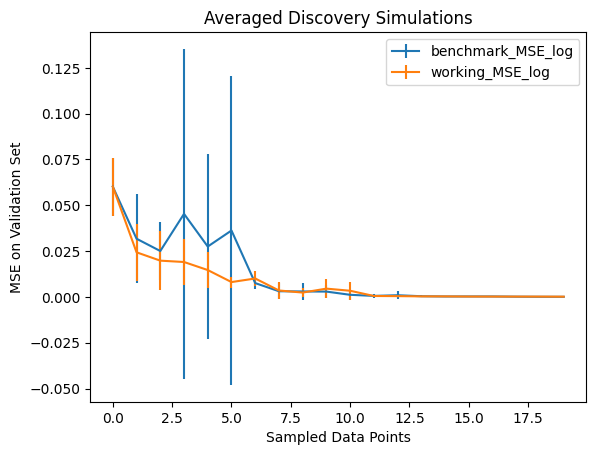

In [ ]:
# plot the data with standard error
plt.errorbar(np.arange(num_cycles), np.mean(benchmark_MSE_plot_data, axis=0), yerr=np.std(benchmark_MSE_plot_data, axis=0), label='benchmark_MSE_log')
plt.errorbar(np.arange(num_cycles), np.mean(working_MSE_plot_data, axis=0), yerr=np.std(working_MSE_plot_data, axis=0), label='working_MSE_log')
plt.xlabel('Sampled Data Points')
plt.ylabel('MSE on Validation Set')
plt.title('Averaged Discovery Simulations')
plt.legend()

## Ground Truth Model Descriptions

### Weber-Fechner-Law

The Weber-Fechner law quantifies the minimum change in a stimulus required to be noticeable. Similar to Steven's power law, the greater the intensity of a stimulus, the larger the change needed to be perceivable. This relationship is hypothesized to be proportional to the logarithm of the ratio between the two stimuli:

$\text{perceived intensity} = \log\left(\dfrac{S_1}{S_2}\right)$


where $S_1$ ($range: [0.01, 5.00]$) is the intensity of a physical stimulus (e.g., the luminosity of a lamp), $S_2$ ($range: [0.01, 5.00]$ ) is a reference stimulus (e.g., the luminosity of a background light), and $y$ is the perceived stimulus intensity (e.g. the perception of the lamp's luminosity).

### Expected Utility Model with Two Choice Options

The expected utility model evaluates decision-making under uncertainty, quantifying the expected value of different choices based on their potential outcomes and associated probabilities. The model assumes that individuals aim to maximize their expected utility when faced with two options. Each option has a specific value and probability, influenced by a certain level of noise.

For two choice options, the expected value of each option is calculated as follows:

$$
E_A = V_A \times P_A
$$

$$
E_B = V_B \times P_B
$$

where:
- $V_A$ and $V_B$ represent the values of options A and B respectively.
- $P_A$ and $P_B$ represent the probabilities associated with these options.

The probability of choosing option A $P_{\text{choose}_A}$ is then determined using the softmax function, which considers the expected values of both options and a choice temperature parameter that influences the sensitivity to differences in expected values:

$$
P_{\text{choose}_A} = \frac{\exp(E_A / \beta)}{\exp(E_A / \beta) + \exp(E_B / \beta)}
$$

In this model:
- $\beta$ controls the degree of randomness in the choice, with higher values leading to more exploration and lower values leading to more deterministic choices based on the expected values.
- The softmax function ensures that the probabilities sum to 1, providing a normalized measure of the likelihood of choosing each option.

This model captures the influence of value, probability, and noise on decision-making, reflecting the complexity and variability of human choices under uncertainty.



### Shepard-Luce Choice Rule

The Shepard-Luce choice rule, as adapted in Logan (2001),  posits that the likelihood of an individual assigning a target object, represented as $x$ , to a specific response category, represented as $i$, is proportional to their psychological similarity $\eta_i(x)$. Here, we considered a version of the model that computes the probability of assigning the target object $x_1$ to one of two response categories, given a distractor object $x_2$:

$y = p(``x_1 \text{ is perceived as category 1''}) =
 \frac{\eta_1(x_1) \cdot \alpha}{\eta_1(x_1) \cdot \alpha + \eta_2(x_1) \cdot \alpha + \eta_1(x_2) \cdot (1 - \alpha) + \eta_2(x_2) \cdot (1 - \alpha)}$

where $\alpha = 0.8$ is an attentional bias toward processing the target object $x_1$, and variables $\eta_i(x_j)$ ($range: [0.125, 10.00]$) are the psychological similarity between object $x_j$ and category $i$.